<a href="https://colab.research.google.com/github/SugnikMukherjee/ModelPredictiveController/blob/main/Actual_MPC_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow

##Tensorflow Implementation

---



In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler
import time
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense,SimpleRNN,LSTM,LSTMCell,GRU,BatchNormalization,Dropout,Flatten,Input,Embedding
from tensorflow.keras.optimizers import Adam,RMSprop,Nadam,SGD

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('/content/jetracer.csv')
df.head()

<Axes: ylabel='curr_accel_x'>

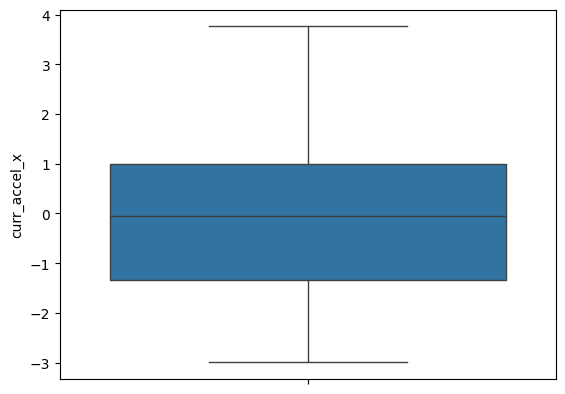

In [ ]:
import seaborn as sns
sns.boxplot(df['curr_accel_x'])

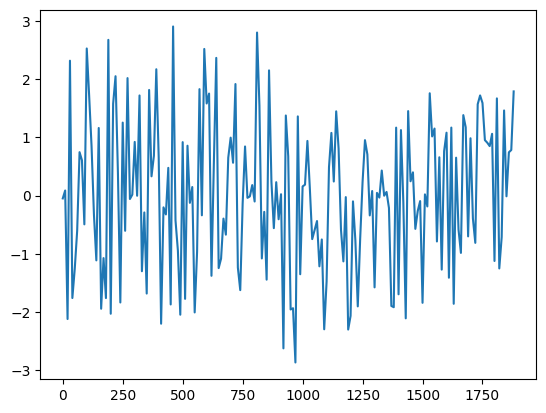

In [ ]:
plt.plot(df[' next_accel_x'][::10])

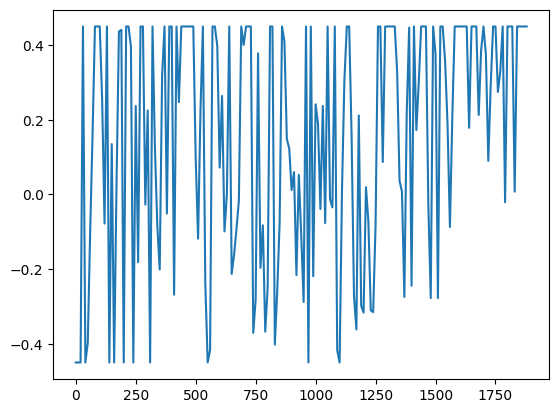

In [ ]:
plt.plot(df[' throttle_pwm'][::10])

<Axes: ylabel=' throttle_pwm'>

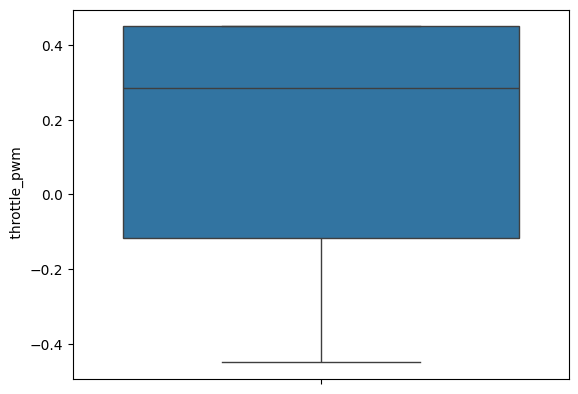

In [ ]:
sns.boxplot(df[' throttle_pwm'])

(189,)

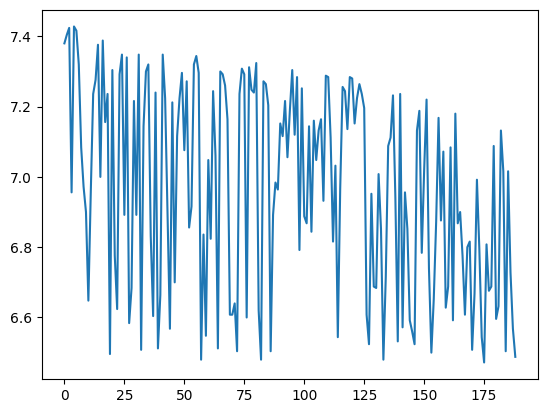

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(df[' voltage'][::10].values)
df[' voltage'][::10].values.shape

###Model_1


In [ ]:
X = np.concatenate((df.iloc[:,:3].values,df.iloc[:,5:6].values),axis = 1)
y = df.iloc[:,3:5].values

In [ ]:
X.shape

(1886, 4)

In [ ]:
y.shape

(1886, 2)

In [ ]:
scaler = MinMaxScaler()
X_scaled= scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y)
X_train,X_test,y_train,y_test = train_test_split(X_scaled,y_scaled,test_size = 0.3,shuffle = False,random_state=42)

In [ ]:
X_train.shape

(1320, 4)

In [ ]:
y_train.shape

(1320, 2)

In [ ]:
!pip install -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.3 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt
def build_model(hp):
  model = Sequential()
  input_dim = X_train.shape[1]
  output_dim = y_train.shape[1]
  model.add(Input(shape = (input_dim,)))
  model.add(BatchNormalization())
  num_layers = hp.Int('num_layers',min_value = 1,max_value = 3,step = 1)
  activation = hp.Choice('activation',values = ['relu','leaky_relu'])
  for i in range(num_layers):
    model.add(Dense(units = hp.Int(f'unit_{i+1}',min_value = 32,max_value = 128,step = 8),activation = activation,kernel_initializer = hp.Choice(f'weight_initializer_{i+1}',values = ['he_normal','glorot_uniform'])))
    model.add(Dropout(hp.Float('drop1',min_value = 0.1,max_value = 0.3,step = 0.1)))
  model.add(Dense(output_dim))
  optimizer = tf.keras.optimizers.AdamW(learning_rate = hp.Float('learning_rate',min_value = 0.001,max_value = 0.002),weight_decay = hp.Float('weight_decay',min_value = 0.004,max_value = 0.006))
  model.compile(optimizer = optimizer,loss = 'mean_squared_error',metrics = [tf.keras.metrics.R2Score()])
  return model

In [ ]:
tuner = kt.RandomSearch(build_model,objective = 'val_loss',max_trials = 100)

In [ ]:
tuner.search(X_train,y_train,epochs = 30,validation_data = (X_test,y_test))

Trial 100 Complete [00h 00m 13s]
val_loss: 0.017209520563483238

Best val_loss So Far: 0.014032474718987942
Total elapsed time: 00h 18m 35s


In [ ]:
tuner.get_best_hyperparameters()[0].values

{'num_layers': 3,
 'activation': 'leaky_relu',
 'unit_1': 96,
 'weight_initializer_1': 'glorot_uniform',
 'drop1': 0.1,
 'learning_rate': 0.0018301279595846136,
 'weight_decay': 0.005617905553295423,
 'unit_2': 48,
 'weight_initializer_2': 'glorot_uniform',
 'unit_3': 96,
 'weight_initializer_3': 'he_normal'}

In [ ]:
models = tuner.get_best_models(num_models = 10)

In [ ]:
i = 1
for model in models:
  print('==================================================================')
  print(f'Model {i}')
  print('==================================================================')
  model.summary()
  i += 1

Model 1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 4)                 16        
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 96)                480       
                                                                 
 dropout (Dropout)           (None, 96)                0         
                                                                 
 dense_1 (Dense)             (None, 48)                4656      
                                                                 
 dropout_1 (Dropout)         (None, 48)                0         
                                                                 
 dense_2 (Dense)             (None, 96)                4704      
                                                

In [ ]:
model = Sequential()
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]

model.add(Input(shape = (input_dim,)))
model.add(BatchNormalization())

model.add(Dense(32,activation = 'relu',kernel_initializer = 'glorot_uniform'))
model.add(Dropout(0.2))
model.add(Dense(128,activation = 'relu',kernel_initializer = 'glorot_uniform'))

model.add(Dense(32,activation = 'relu',kernel_initializer = 'glorot_uniform'))
model.add(Dropout(0.2))
model.add(Dense(128,activation = 'relu',kernel_initializer = 'glorot_uniform'))

model.add(Dense(output_dim))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 4)                 16        
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 32)                160       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               4224      
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                        

In [ ]:
model = models[0]
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.0001,
    patience=10,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False
)
optimizer = tf.keras.optimizers.AdamW(learning_rate = 0.043150655955097456,weight_decay = 0.004505986080612864)
model.compile(optimizer = optimizer,loss = 'mean_squared_error',metrics = [tf.keras.metrics.R2Score()])
history = model.fit(X_train,y_train,epochs = 1000,validation_data = (X_test,y_test),callbacks = callback)

Epoch 1/1000
42/42 [==============================] - 2s 10ms/step - loss: 0.0853 - r2_score: -0.4724 - val_loss: 0.0246 - val_r2_score: -0.1509
Epoch 2/1000
42/42 [==============================] - 0s 5ms/step - loss: 0.0399 - r2_score: 0.3730 - val_loss: 0.0194 - val_r2_score: 0.2353
Epoch 3/1000
42/42 [==============================] - 0s 7ms/step - loss: 0.0376 - r2_score: 0.3969 - val_loss: 0.0241 - val_r2_score: 0.1637
Epoch 4/1000
42/42 [==============================] - 0s 7ms/step - loss: 0.0367 - r2_score: 0.4275 - val_loss: 0.0327 - val_r2_score: -0.3792
Epoch 5/1000
42/42 [==============================] - 0s 7ms/step - loss: 0.0384 - r2_score: 0.3911 - val_loss: 0.0321 - val_r2_score: -0.1102
Epoch 6/1000
42/42 [==============================] - 0s 7ms/step - loss: 0.0438 - r2_score: 0.3765 - val_loss: 0.0340 - val_r2_score: -0.3542
Epoch 7/1000
42/42 [==============================] - 0s 7ms/step - loss: 0.0421 - r2_score: 0.3566 - val_loss: 0.0310 - val_r2_score: -0.6595

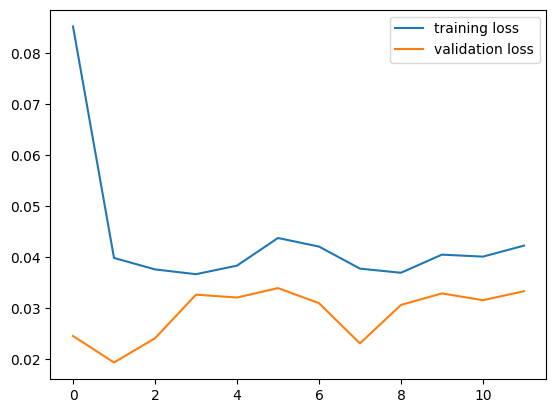

In [ ]:
plt.plot(history.history['loss'],label = 'training loss')
plt.plot(history.history['val_loss'],label = 'validation loss')
plt.legend()
plt.show()

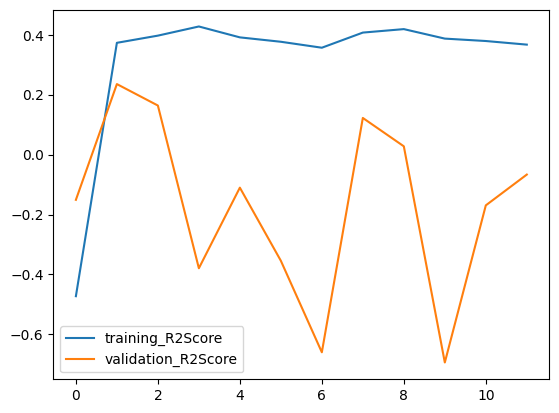

In [ ]:
plt.plot(history.history['r2_score'],label = 'training_R2Score')
plt.plot(history.history['val_r2_score'],label = 'validation_R2Score')
plt.legend()
plt.show()

In [ ]:
%%time
y_pred = model.predict(X_test)
y_pred

18/18 [==============================] - 0s 11ms/step
CPU times: user 271 ms, sys: 7.07 ms, total: 278 ms
Wall time: 705 ms


array([[0.7140415 , 0.4373825 ],
       [0.6463308 , 0.45263603],
       [0.53806907, 0.46310017],
       ...,
       [0.9551892 , 0.2503736 ],
       [0.48562798, 0.36536217],
       [0.28551495, 0.3960179 ]], dtype=float32)

In [ ]:
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

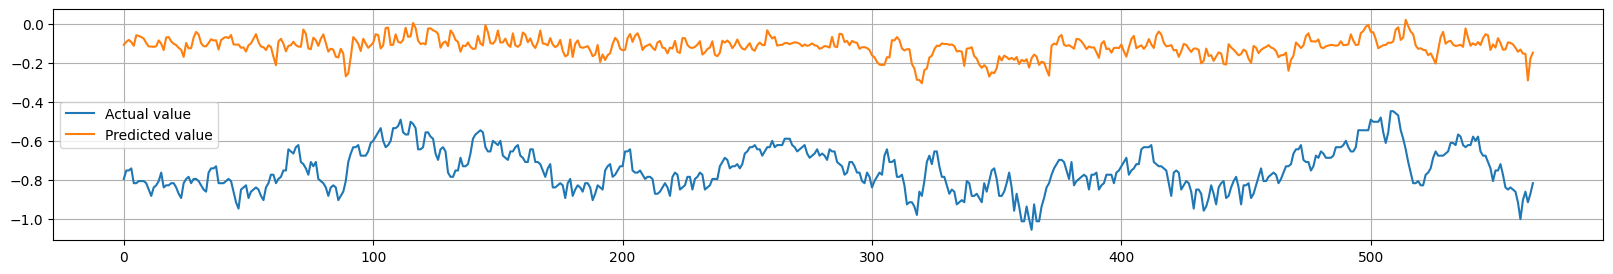

In [ ]:
plt.figure(figsize=(20, 3))
throttle_pwm = []
pred_throttle_pwm = []
for a in y_test:
  throttle_pwm.append(a[1])
for a in y_pred:
  pred_throttle_pwm.append(a[1])
plt.plot(throttle_pwm,label = 'Actual value')
plt.plot(pred_throttle_pwm,label = 'Predicted value')
plt.legend()
plt.grid()
plt.show()

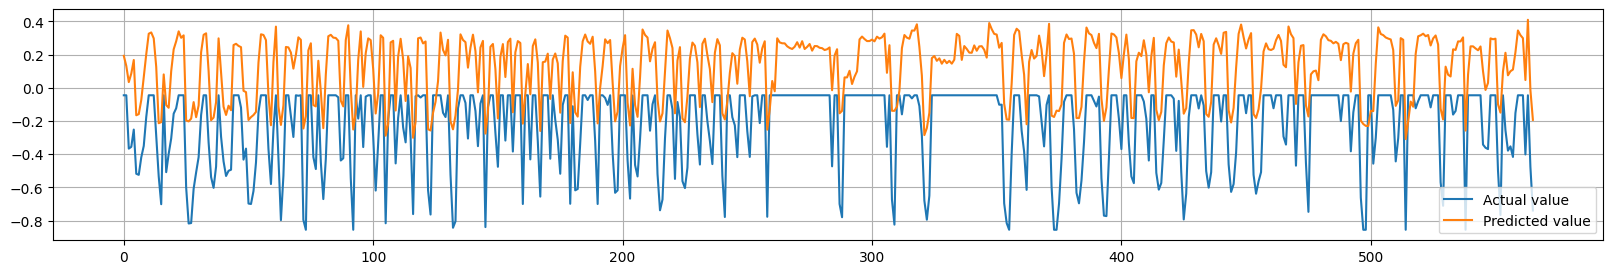

In [ ]:
plt.figure(figsize=(20, 3))
steering_pwm = []
pred_steering_pwm = []
for a in y_test:
  steering_pwm.append(a[0])
for a in y_pred:
  pred_steering_pwm.append(a[0])
plt.plot(steering_pwm,label = 'Actual value')
plt.plot(pred_steering_pwm,label = 'Predicted value')
plt.legend()
plt.grid()
plt.show()

###Model_2



In [ ]:
X = df.iloc[:,5:].values
y = df.iloc[:,3:5].values

In [ ]:
scaler = MinMaxScaler()
X_scaled= scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y)
X_train,X_test,y_train,y_test = train_test_split(X_scaled,y_scaled,test_size = 0.3,shuffle = False,random_state=42)

In [ ]:
X_train.shape

(1320, 4)

In [ ]:
y_train.shape

(1320, 2)

In [ ]:
import keras_tuner as kt
def build_model(hp):
  model = Sequential()
  input_dim = X_train.shape[1]
  output_dim = y_train.shape[1]
  model.add(Input(shape = (input_dim,)))
  model.add(BatchNormalization())
  num_layers = hp.Int('num_layers',min_value = 1,max_value = 3,step = 1)
  activation = hp.Choice('activation',values = ['relu','leaky_relu'])
  for i in range(num_layers):
    model.add(Dense(units = hp.Int(f'unit_{i+1}',min_value = 32,max_value = 128,step = 8),activation = activation,kernel_initializer = hp.Choice(f'weight_initializer_{i+1}',values = ['he_normal','glorot_uniform'])))
    model.add(Dropout(hp.Float('drop1',min_value = 0.1,max_value = 0.3,step = 0.1)))
  model.add(Dense(output_dim))
  optimizer = tf.keras.optimizers.AdamW(learning_rate = hp.Float('learning_rate',min_value = 0.001,max_value = 0.002),weight_decay = hp.Float('weight_decay',min_value = 0.004,max_value = 0.006))
  model.compile(optimizer = optimizer,loss = 'mean_squared_error',metrics = [tf.keras.metrics.R2Score()])
  return model

In [ ]:
tuner = kt.RandomSearch(build_model,objective = 'val_loss',max_trials = 100)

In [ ]:
tuner.search(X_train,y_train,epochs = 30,validation_data = (X_test,y_test))

Trial 100 Complete [00h 00m 12s]
val_loss: 0.01885819248855114

Best val_loss So Far: 0.013958456926047802
Total elapsed time: 00h 23m 02s


In [ ]:
tuner.get_best_hyperparameters()[0].values

{'num_layers': 3,
 'activation': 'leaky_relu',
 'unit_1': 48,
 'weight_initializer_1': 'glorot_uniform',
 'drop1': 0.1,
 'learning_rate': 0.0017327892458308424,
 'weight_decay': 0.004704344484199524,
 'unit_2': 32,
 'weight_initializer_2': 'glorot_uniform',
 'unit_3': 32,
 'weight_initializer_3': 'glorot_uniform'}

In [ ]:
models = tuner.get_best_models(num_models = 10)

In [ ]:
i = 1
for model in models:
  print('==================================================================')
  print(f'Model {i}')
  print('==================================================================')
  model.summary()
  i += 1

Model 1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 4)                 16        
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 48)                240       
                                                                 
 dropout (Dropout)           (None, 48)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1568      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                

In [ ]:
model = models[0]
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.0001,
    patience=10,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False
)
optimizer = tf.keras.optimizers.AdamW(learning_rate = 0.043150655955097456,weight_decay = 0.004505986080612864)
model.compile(optimizer = optimizer,loss = 'mean_squared_error',metrics = [tf.keras.metrics.R2Score()])
history = model.fit(X_train,y_train,epochs = 1000,validation_data = (X_test,y_test),callbacks = callback)

Epoch 1/1000
42/42 [==============================] - 6s 32ms/step - loss: 0.0824 - r2_score: -0.1596 - val_loss: 0.0339 - val_r2_score: -0.5240
Epoch 2/1000
42/42 [==============================] - 1s 15ms/step - loss: 0.0396 - r2_score: 0.4182 - val_loss: 0.0208 - val_r2_score: 0.3579
Epoch 3/1000
42/42 [==============================] - 1s 14ms/step - loss: 0.0372 - r2_score: 0.4594 - val_loss: 0.0236 - val_r2_score: 0.1319
Epoch 4/1000
42/42 [==============================] - 1s 14ms/step - loss: 0.0357 - r2_score: 0.4485 - val_loss: 0.0256 - val_r2_score: 0.0508
Epoch 5/1000
42/42 [==============================] - 0s 11ms/step - loss: 0.0360 - r2_score: 0.4485 - val_loss: 0.0193 - val_r2_score: 0.4305
Epoch 6/1000
42/42 [==============================] - 0s 4ms/step - loss: 0.0393 - r2_score: 0.4468 - val_loss: 0.0200 - val_r2_score: 0.2092
Epoch 7/1000
42/42 [==============================] - 0s 6ms/step - loss: 0.0389 - r2_score: 0.4311 - val_loss: 0.0258 - val_r2_score: 0.1856

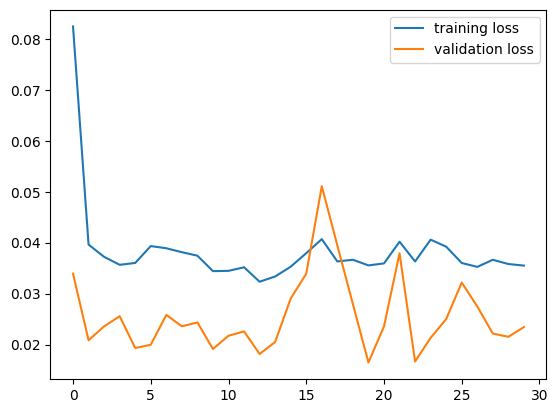

In [ ]:
plt.plot(history.history['loss'],label = 'training loss')
plt.plot(history.history['val_loss'],label = 'validation loss')
plt.legend()
plt.show()

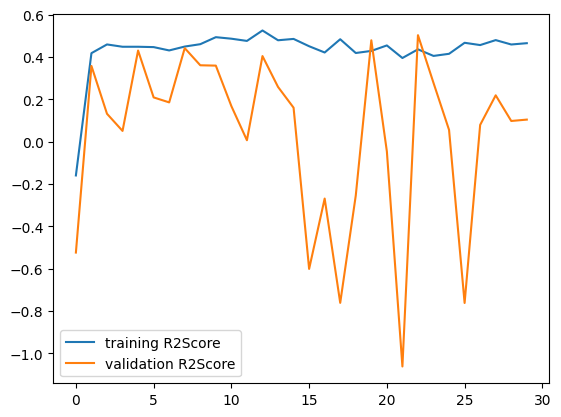

In [ ]:
plt.plot(history.history['r2_score'],label = 'training R2Score')
plt.plot(history.history['val_r2_score'],label = 'validation R2Score')
plt.legend()
plt.show()

In [ ]:
%%time
y_pred = model.predict(X_test)
y_pred

18/18 [==============================] - 0s 3ms/step
CPU times: user 277 ms, sys: 2.83 ms, total: 280 ms
Wall time: 372 ms


array([[0.78698516, 0.49671125],
       [0.7305536 , 0.48765248],
       [0.69430655, 0.47028652],
       ...,
       [0.98192334, 0.11334792],
       [0.29373634, 0.15573606],
       [0.14013174, 0.09574214]], dtype=float32)

In [ ]:
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

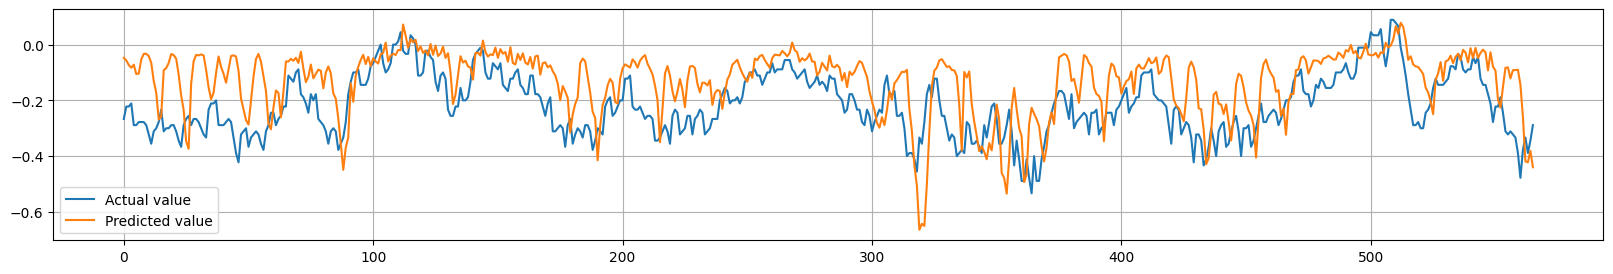

In [ ]:
plt.figure(figsize=(20, 3))
throttle_pwm = []
pred_throttle_pwm = []
for a in y_test:
  throttle_pwm.append(a[1])
for a in y_pred:
  pred_throttle_pwm.append(a[1])
plt.plot(throttle_pwm,label = 'Actual value')
plt.plot(pred_throttle_pwm,label = 'Predicted value')
plt.legend()
plt.grid()
plt.show()

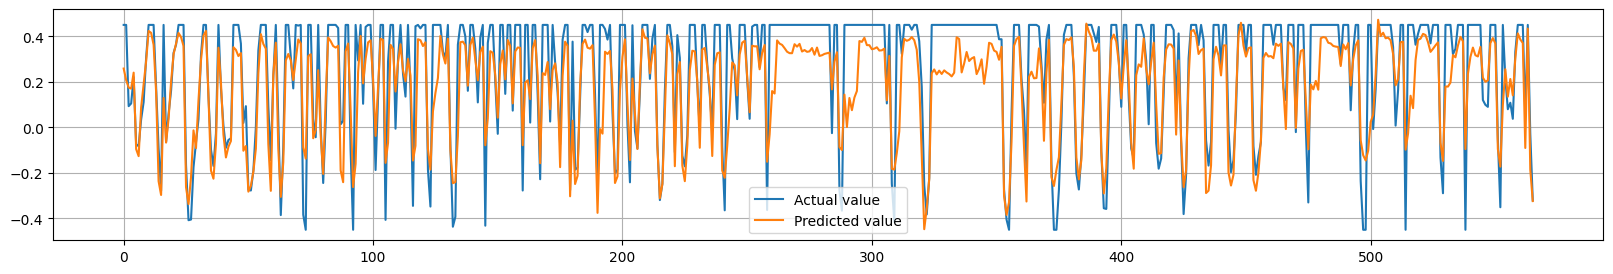

In [ ]:
plt.figure(figsize=(20, 3))
steering_pwm = []
pred_steering_pwm = []
for a in y_test:
  steering_pwm.append(a[0])
for a in y_pred:
  pred_steering_pwm.append(a[0])
plt.plot(steering_pwm,label = 'Actual value')
plt.plot(pred_steering_pwm,label = 'Predicted value')
plt.legend()
plt.grid()
plt.show()

###Tensorflow - Tensor-RT implemetation

---



In [ ]:
!pip install tf2onnx onnx onnx-tf
!sudo apt-get install -y libprotobuf-dev protobuf-compiler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 51.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.1/226.1 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 43.1 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
protobuf-compiler is already the newest version (3.12.4-1ubuntu7.22.04.1).
The following NEW packages will be installed:
  libprotobuf-dev libprotobuf-lite23
0 upgraded, 2 newly installed, 0 to remove and 45 not upgraded.
Need to get 1,555 kB of archives.
After this operation, 12.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libprotobuf-lite23 amd64 3.12.4-1ubuntu7.22.04.1 [209 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libprotobuf-dev amd64 3.12.4-1ubuntu7.22.04.1 [1,347 kB]
Fetche

In [ ]:
import tensorflow as tf
import tf2onnx

# Define the concrete function
@tf.function(input_signature=[tf.TensorSpec([None, 4], tf.float32)])
def model_func(x):
    return model(x)

# Get the concrete function from the model
concrete_func = model_func.get_concrete_function()

# Convert the TensorFlow model to ONNX format
model_proto, external_tensor_storage = tf2onnx.convert.from_function(
    function=model_func,
    input_signature=[tf.TensorSpec([None, 4], tf.float32)],
    opset=13,
    output_path="model.onnx"
)

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
#Uninstall the current CUDA version
!sudo apt-get --purge remove cuda nvidia* libnvidia-*
!sudo dpkg -l | grep cuda- | awk '{print $2}' | xargs -n1 dpkg --purge
!sudo apt-get remove cuda-*
!sudo apt autoremove

In [ ]:
# Installing CUDA 10.0

!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/cuda-repo-ubuntu1804_10.0.130-1_amd64.deb
!sudo dpkg -i cuda-repo-ubuntu1804_10.0.130-1_amd64.deb
!sudo apt-key adv --fetch-keys https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/7fa2af80.pub
!sudo apt-get update
!wget http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64/nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb
!sudo apt install -y ./nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb
!sudo apt-get update

# Install NVIDIA driver
!sudo apt-get -y installnvidia-driver-418

# Install development and runtime libraries (~4GB)
!sudo apt-get install -y \
    cuda-10-0 \
    libcudnn7=7.6.2.24-1+cuda10.0  \
    libcudnn7-dev=7.6.2.24-1+cuda10.0 --allow-change-held-packages

--2024-06-07 06:00:23--  https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/cuda-repo-ubuntu1804_10.0.130-1_amd64.deb
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 152.199.20.126
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|152.199.20.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2942 (2.9K) [application/x-deb]
Saving to: ‘cuda-repo-ubuntu1804_10.0.130-1_amd64.deb’

cuda-repo-ubuntu180 100%[===================>]   2.87K  --.-KB/s    in 0s      

2024-06-07 06:00:24 (108 MB/s) - ‘cuda-repo-ubuntu1804_10.0.130-1_amd64.deb’ saved [2942/2942]

Selecting previously unselected package cuda-repo-ubuntu1804.
(Reading database ... 122032 files and directories currently installed.)
Preparing to unpack cuda-repo-ubuntu1804_10.0.130-1_amd64.deb ...
Unpacking cuda-repo-ubuntu1804 (10.0.130-1) ...
Setting up cuda-repo-ubuntu1804 (10.0.130-1) ...

The public CUDA GPG key does not appear

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [ ]:
!sudo dpkg -i "/content/drive/My Drive/nv-tensorrt-repo-ubuntu1804-cuda10.0-trt7.0.0.11-ga-20191216_1-1_amd64.deb"
!sudo apt-key add /var/nv-tensorrt-repo-cuda10.0-trt7.0.0.11-ga-20191216/7fa2af80.pub
!sudo apt-get update

dpkg: error: cannot access archive '/content/drive/My Drive/nv-tensorrt-repo-ubuntu1804-cuda10.0-trt7.0.0.11-ga-20191216_1-1_amd64.deb': No such file or directory
gpg: can't open '/var/nv-tensorrt-repo-cuda10.0-trt7.0.0.11-ga-20191216/7fa2af80.pub': No such file or directory
Get:1 http://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:7 http://security.ubuntu.com/ubuntu jammy-security InRelease
Err:1 http://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
  The following signatures couldn't be verified because the public key is not available: NO_PUBKEY A4B469963BF863CC
I

In [ ]:
!sudo apt-get install libnvinfer7=7.0.0-1+cuda10.0 libnvonnxparsers7=7.0.0-1+cuda10.0 libnvparsers7=7.0.0-1+cuda10.0 libnvinfer-plugin7=7.0.0-1+cuda10.0 libnvinfer-dev=7.0.0-1+cuda10.0 libnvonnxparsers-dev=7.0.0-1+cuda10.0 libnvparsers-dev=7.0.0-1+cuda10.0 libnvinfer-plugin-dev=7.0.0-1+cuda10.0 python-libnvinfer=7.0.0-1+cuda10.0 python3-libnvinfer=7.0.0-1+cuda10.0

!sudo apt-mark hold libnvinfer7 libnvonnxparsers7 libnvparsers7 libnvinfer-plugin7 libnvinfer-dev libnvonnxparsers-dev libnvparsers-dev libnvinfer-plugin-dev python-libnvinfer python3-libnvinfer

In [ ]:
!sudo apt-get install tensorrt

In [ ]:
!dpkg -l | grep TensorRT

In [ ]:
import tensorrt as trt
print(trt.__version__)

In [ ]:
import tensorrt as trt
import onnx

def onnx_to_trt(onnx_model_path, trt_engine_path):
    # Initialize TensorRT logger
    logger = trt.Logger(trt.Logger.WARNING)

    #Create TensorRT builder
    builder = trt.Builder
    if builder is None:
        print("ERROR: Failed to create TensorRT builder")
        return None

    # Set builder parameters
    builder.max_workspace_size = 1 << 30  # 1GB
    builder.max_batch_size = 1

    # Create TensorRT network
    network = builder(logger).create_network()
    if network is None:
        print("ERROR: Failed to create TensorRT network")
        return None

    # Create ONNX parser
    parser = trt.OnnxParser(network, logger)

    # Load ONNX model
    with open(onnx_model_path, 'rb') as f:
        if not parser.parse(f.read()):
            print("ERROR: Failed to parse ONNX model")
            return None

    # Build TensorRT engine
    engine = builder.build_cuda_engine(network)
    if engine is None:
        print("ERROR: Failed to build TensorRT engine")
        return None

    # Serialize TensorRT engine
    with open(trt_engine_path, 'wb') as f:
        f.write(engine.serialize())

    print("TensorRT engine saved successfully to:", trt_engine_path)

# Path to the ONNX model file
onnx_model_path = "/content/model.onnx"
# Path to save the TensorRT engine
trt_engine_path = "/content/model_trt.engine"

# Convert ONNX to TensorRT
onnx_to_trt(onnx_model_path, trt_engine_path)


##PyTorch Implementation

---



###Model_1

In [ ]:
import os
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
device = ("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using {device} device")

Using cpu device


In [ ]:
X = np.concatenate((df.iloc[:,:3].values,df.iloc[:,5:6].values),axis = 1)
y = df.iloc[:,3:5].values

In [ ]:
ratio = 0.7
total_rows = df.shape[0]
train_size = int(total_rows*ratio)
X_train = X[0:train_size]
X_test = X[train_size:]
y_train = y[0:train_size]
y_test = y[train_size:]

In [ ]:
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)

In [ ]:
X_train.shape

torch.Size([1320, 4])

In [ ]:
y_train.shape

torch.Size([1320, 2])

In [ ]:
!pip install 'ray[tune]'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.9/65.9 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 9.4 MB/s eta 0:00:00


In [ ]:
!pip install pytorch-ignite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 6.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
import os
import tempfile
import ray
from ray import tune
from ray import train
from ray.train import Checkpoint, get_checkpoint
from ray.tune.schedulers import ASHAScheduler
from ray.tune import CLIReporter

In [ ]:
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
class NeuralNetwork(nn.Module):
  def __init__(self,layer_1,layer_2,layer_3,dropout_rate,activation):
    super(NeuralNetwork,self).__init__()
    self.activation = activation
    self.relu_nn_model = nn.Sequential(
        nn.Linear(input_dim,layer_1),
        nn.ReLU(),
        nn.Linear(layer_1,layer_2),
        nn.ReLU(),
        nn.Dropout(p = dropout_rate),
        nn.Linear(layer_2,layer_3),
        nn.ReLU(),
        nn.Linear(layer_3,output_dim)
    )
    self.leaky_relu_nn_model = nn.Sequential(
        nn.Linear(input_dim,layer_1),
        nn.LeakyReLU(),
        nn.Linear(layer_1,layer_2),
        nn.LeakyReLU(),
        nn.Dropout(p = dropout_rate),
        nn.Linear(layer_2,layer_3),
        nn.LeakyReLU(),
        nn.Linear(layer_3,output_dim)
    )
    self.tanh_nn_model = nn.Sequential(
        nn.Linear(input_dim,layer_1),
        nn.Tanh(),
        nn.Linear(layer_1,layer_2),
        nn.Tanh(),
        nn.Dropout(p = dropout_rate),
        nn.Linear(layer_2,layer_3),
        nn.Tanh(),
        nn.Linear(layer_3,output_dim)
    )
  def forward(self,x):
    if self.activation == 'relu':
      y = self.relu_nn_model(x)
      return y
    if self.activation == 'leaky_relu':
      y = self.leaky_relu_nn_model(x)
      return y
    if self.activation == 'tanh':
      y = self.tanh_nn_model(x)
      return y

In [ ]:
def train_model(config):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = NeuralNetwork(config['layer_1'], config['layer_2'], config['layer_3'],config['dropout_rate'],config['activation']).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"], weight_decay=1e-5)
    epochs = 30

    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

    test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

    train_losses = []
    val_losses = []
    total_loss = 0

    for epoch in range(epochs):
        model.train()
        for batch in train_loader:
            X_batch, y_batch = batch
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            train_losses.append(loss.item())
            loss.backward()
            optimizer.step()

        if epoch % 10 == 0:
            print(f'Epoch: {epoch} Loss: {loss.item()}')

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in test_loader:
                X_batch, y_batch = batch
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_val = model(X_batch)
                val_loss += criterion(y_val, y_batch).item()

        val_loss /= len(test_loader)
        val_losses.append(val_loss)
        total_loss += val_loss

    total_loss /= epochs
    return {"loss": total_loss}

In [ ]:
config = {
    "lr": tune.loguniform(1e-4, 1e-1),
    "layer_1": tune.choice([x for x in range(32,144,8)]),
    "layer_2": tune.choice([x for x in range(32,144,8)]),
    "layer_3": tune.choice([x for x in range(32,144,8)]),
    "dropout_rate":tune.choice([0.1*x for x in range(1,4)]),
    "activation":tune.choice(['relu','leaky_relu','tanh'])
}

# Scheduler for hyperparameter tuning
scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    max_t=30,
    grace_period=1,
    reduction_factor=2
)

# Run the hyperparameter tuning
analysis = tune.run(
    train_model,
    resources_per_trial={"cpu": 1},
    config=config,
    num_samples=10,
    scheduler=scheduler
)

best_config = analysis.get_best_config(metric="loss", mode="min")
print("Best config:", best_config)

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-06-11 10:13:42,047	INFO worker.py:1753 -- Started a local Ray instance.
2024-06-11 10:13:47,055	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.


+--------------------------------------------------------------------+
| Configuration for experiment     train_model_2024-06-11_10-13-47   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        AsyncHyperBandScheduler           |
| Number of trials                 10                                |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_model_2024-06-11_10-13-47
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-06-11_10-13-35_337680_174/artifacts/2024-06-11_10-13-47/train_model_2024-06-11_10-13-47/driver_artifacts`

Trial status: 10 PENDING
Current time: 2024-06-11 10:13:48. Total running time: 0s
Logical resource usage: 0/2 CPUs, 0/0 GPUs
+-------------------------------------------------------------------------------------------------

2024-06-11 10:15:46,091	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_model_2024-06-11_10-13-47' in 0.0109s.



Trial train_model_4a6c0_00008 finished iteration 1 at 2024-06-11 10:15:46. Total running time: 1min 58s
+--------------------------------------------------+
| Trial train_model_4a6c0_00008 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         7.38357 |
| time_total_s                             7.38357 |
| training_iteration                             1 |
| loss                                     0.04697 |
+--------------------------------------------------+

Trial train_model_4a6c0_00009 finished iteration 1 at 2024-06-11 10:15:46. Total running time: 1min 58s
+--------------------------------------------------+
| Trial train_model_4a6c0_00009 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         7.34378 |
| time_total_s                             7.343

In [ ]:
model = NeuralNetwork(best_config['layer_1'],best_config['layer_2'],best_config['layer_3'],best_config['dropout_rate'],best_config['activation']).to(device)
print(model)

NeuralNetwork(
  (relu_nn_model): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=120, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.2, inplace=False)
    (5): Linear(in_features=120, out_features=104, bias=True)
    (6): ReLU()
    (7): Linear(in_features=104, out_features=2, bias=True)
  )
  (leaky_relu_nn_model): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=32, out_features=120, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Dropout(p=0.2, inplace=False)
    (5): Linear(in_features=120, out_features=104, bias=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Linear(in_features=104, out_features=2, bias=True)
  )
  (tanh_nn_model): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=120, bias=True)
    (3): Tan

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr = best_config['lr'],weight_decay=1e-5)

In [ ]:
epochs = 30
losses = []
for i in range(epochs):
  y_pred = model.forward(X_train)
  loss = criterion(y_pred,y_train)
  losses.append(loss.detach().numpy())
  if i % 10 == 0:
    print(f'Epoch : {i} and Loss: {loss}')
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

Epoch : 0 and Loss: 0.10568059235811234
Epoch : 10 and Loss: 0.07154218852519989
Epoch : 20 and Loss: 0.06663459539413452


In [ ]:
val_losses = []
with torch.no_grad():
  for i,data in enumerate(X_test):
    y_val = model(data)
    loss = criterion(y_val,y_test)
    val_losses.append(loss.item())
    if i%100 == 0:
      print(f'{i+1}.Loss : {loss}')

1.Loss : 0.06986197829246521


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([566, 2])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


101.Loss : 0.06582984328269958
201.Loss : 0.0687246173620224
301.Loss : 0.06014281511306763
401.Loss : 0.05965602025389671
501.Loss : 0.0862819030880928


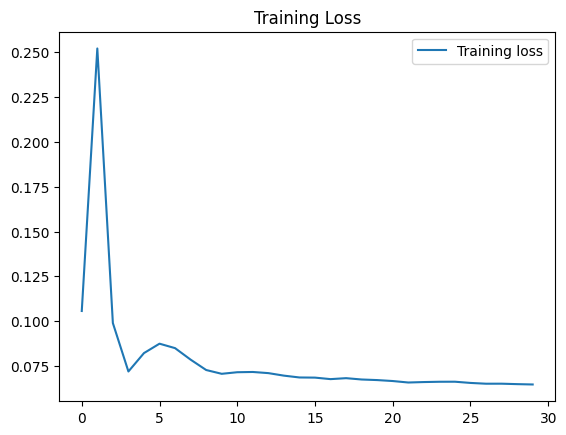

In [ ]:
plt.title('Training Loss')
plt.plot(losses,label = 'Training loss')
plt.legend()
plt.show()

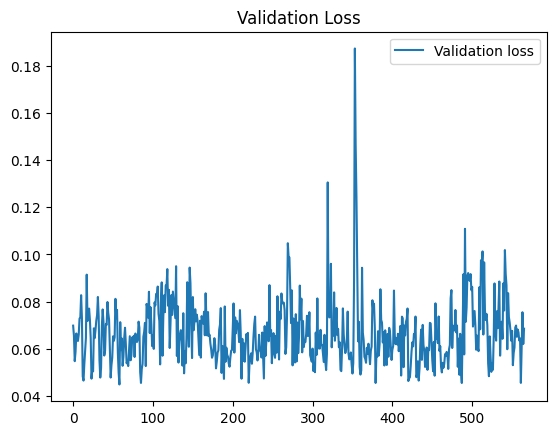

In [ ]:
plt.title('Validation Loss')
plt.plot(val_losses,label = 'Validation loss')
plt.legend()
plt.show()

In [ ]:
y_pred = []
with torch.no_grad():
  for i,data in enumerate(X_test):
    y_val = model(data)
    y_pred.append(y_val)

In [ ]:
y_test.detach().numpy()

array([[ 0.45      , -0.26666668],
       [ 0.45      , -0.22222222],
       [ 0.09299959, -0.22222222],
       ...,
       [ 0.45      , -0.3888889 ],
       [-0.02849947, -0.34444445],
       [-0.32100028, -0.2888889 ]], dtype=float32)

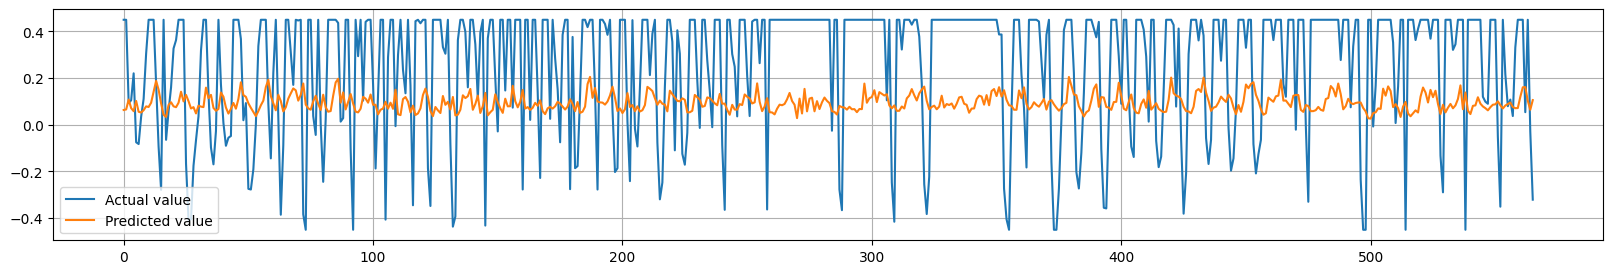

In [ ]:
plt.figure(figsize=(20, 3))
throttle_pwm = []
pred_throttle_pwm = []
for a in y_test.detach().numpy():
  throttle_pwm.append(a[0])
for a in y_pred:
  pred_throttle_pwm.append(a[0])
plt.plot(throttle_pwm,label = 'Actual value')
plt.plot(pred_throttle_pwm,label = 'Predicted value')
plt.legend()
plt.grid()
plt.show()

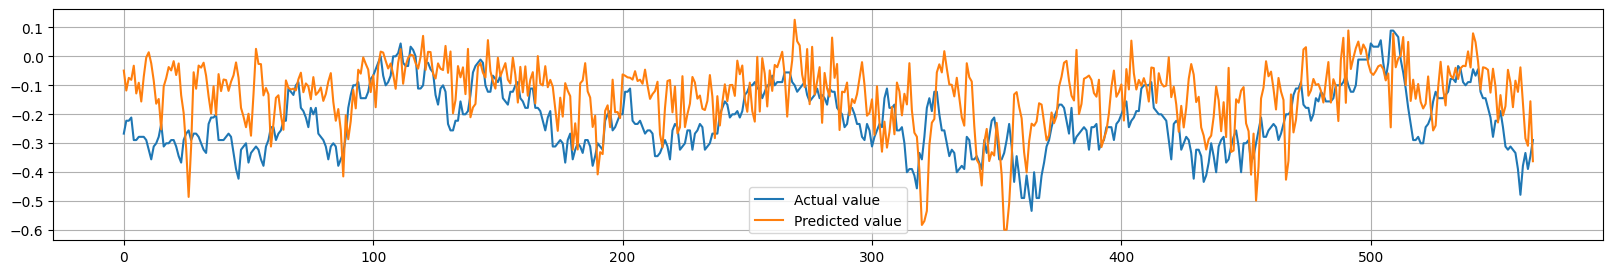

In [ ]:
plt.figure(figsize=(20, 3))
steering_pwm = []
pred_steering_pwm = []
for a in y_test:
  steering_pwm.append(a[1])
for a in y_pred:
  pred_steering_pwm.append(a[1])
plt.plot(steering_pwm,label = 'Actual value')
plt.plot(pred_steering_pwm,label = 'Predicted value')
plt.legend()
plt.grid()
plt.show()

In [ ]:
%%timeit
y_rand = model(torch.randn(1,4))

349 µs ± 36.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
torch.save(model.state_dict(), '/content/pm1.pth')
model.load_state_dict(torch.load('/content/pm1.pth'))

<All keys matched successfully>

###Model_2

In [ ]:
df.head()

curr_accel_x   curr_accel_y   curr_yaw_rate   throttle_pwm   steering_pwm  \
0      0.000000       0.000000        0.000000          -0.45      -0.111111   
1     -0.048281       0.016782       -0.002222          -0.45      -0.111111   
2      0.087396      -0.023934       -0.004435          -0.45      -0.111111   
3      0.095399       0.165994       -0.002357          -0.45      -0.111111   
4      0.006766       0.166401        0.001327          -0.45      -0.111111   

    voltage   next_accel_x   next_accel_y   next_yaw_rate  
0     7.380      -0.048281       0.016782       -0.002222  
1     7.336       0.087396      -0.023934       -0.004435  
2     7.340       0.095399       0.165994       -0.002357  
3     7.364       0.006766       0.166401        0.001327  
4     7.352      -0.000579      -0.061384       -0.002015

In [ ]:
X = df.iloc[:,5:].values
y = df.iloc[:,3:5].values

In [ ]:
ratio = 0.7
total_rows = df.shape[0]
train_size = int(total_rows*ratio)
X_train = X[0:train_size]
X_test = X[train_size:]
y_train = y[0:train_size]
y_test = y[train_size:]

In [ ]:
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)

In [ ]:
!pip install 'ray[tune]'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.9/65.9 MB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 9.9 MB/s eta 0:00:00


In [ ]:
import os
import tempfile
from ray import tune
from ray import train
from ray.train import Checkpoint, get_checkpoint
from ray.tune.schedulers import ASHAScheduler

In [ ]:
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
class NeuralNetwork(nn.Module):
  def __init__(self,layer_1,layer_2,layer_3,dropout_rate,activation):
    super(NeuralNetwork,self).__init__()
    self.activation = activation
    self.relu_nn_model = nn.Sequential(
        nn.Linear(input_dim,layer_1),
        nn.ReLU(),
        nn.Linear(layer_1,layer_2),
        nn.ReLU(),
        nn.Dropout(p = dropout_rate),
        nn.Linear(layer_2,layer_3),
        nn.ReLU(),
        nn.Linear(layer_3,output_dim)
    )
    self.leaky_relu_nn_model = nn.Sequential(
        nn.Linear(input_dim,layer_1),
        nn.LeakyReLU(),
        nn.Linear(layer_1,layer_2),
        nn.LeakyReLU(),
        nn.Dropout(p = dropout_rate),
        nn.Linear(layer_2,layer_3),
        nn.LeakyReLU(),
        nn.Linear(layer_3,output_dim)
    )
    self.tanh_nn_model = nn.Sequential(
        nn.Linear(input_dim,layer_1),
        nn.Tanh(),
        nn.Linear(layer_1,layer_2),
        nn.Tanh(),
        nn.Dropout(p = dropout_rate),
        nn.Linear(layer_2,layer_3),
        nn.Tanh(),
        nn.Linear(layer_3,output_dim)
    )
  def forward(self,x):
    if self.activation == 'relu':
      y = self.relu_nn_model(x)
      return y
    if self.activation == 'leaky_relu':
      y = self.leaky_relu_nn_model(x)
      return y
    if self.activation == 'tanh':
      y = self.tanh_nn_model(x)
      return y

In [ ]:
def train_model(config):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = NeuralNetwork(config['layer_1'], config['layer_2'], config['layer_3'],config['dropout_rate'],config['activation']).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"], weight_decay=1e-5)
    epochs = 30

    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

    test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

    train_losses = []
    val_losses = []
    total_loss = 0

    for epoch in range(epochs):
        model.train()
        for batch in train_loader:
            X_batch, y_batch = batch
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            train_losses.append(loss.item())
            loss.backward()
            optimizer.step()

        if epoch % 10 == 0:
            print(f'Epoch: {epoch} Loss: {loss.item()}')

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in test_loader:
                X_batch, y_batch = batch
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_val = model(X_batch)
                val_loss += criterion(y_val, y_batch).item()

        val_loss /= len(test_loader)
        val_losses.append(val_loss)
        total_loss += val_loss
    total_loss /= epochs
    return {"loss": total_loss}

In [ ]:
config = {
    "lr": tune.loguniform(1e-4, 1e-1),
    "layer_1": tune.choice([x for x in range(32,144,8)]),
    "layer_2": tune.choice([x for x in range(32,144,8)]),
    "layer_3": tune.choice([x for x in range(32,144,8)]),
    "dropout_rate":tune.choice([0.1*x for x in range(1,4)]),
    "activation":tune.choice(['relu','leaky_relu','tanh'])
}

# Scheduler for hyperparameter tuning
scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    max_t=30,
    grace_period=1,
    reduction_factor=2
)

# Run the hyperparameter tuning
analysis = tune.run(
    train_model,
    resources_per_trial={"cpu": 1},
    config=config,
    num_samples=10,
    scheduler=scheduler
)

best_config = analysis.get_best_config(metric="loss", mode="min")
print("Best config:", best_config)

+--------------------------------------------------------------------+
| Configuration for experiment     train_model_2024-06-11_10-17-40   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        AsyncHyperBandScheduler           |
| Number of trials                 10                                |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_model_2024-06-11_10-17-40
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-06-11_10-13-35_337680_174/artifacts/2024-06-11_10-17-40/train_model_2024-06-11_10-17-40/driver_artifacts`

Trial status: 10 PENDING
Current time: 2024-06-11 10:17:40. Total running time: 0s
Logical resource usage: 0/2 CPUs, 0/0 GPUs
+-------------------------------------------------------------------------------------------------

2024-06-11 10:20:06,590	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_model_2024-06-11_10-17-40' in 0.0177s.



Trial train_model_d55d2_00009 finished iteration 1 at 2024-06-11 10:20:06. Total running time: 2min 26s
+--------------------------------------------------+
| Trial train_model_d55d2_00009 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         34.2045 |
| time_total_s                             34.2045 |
| training_iteration                             1 |
| loss                                     0.04336 |
+--------------------------------------------------+

Trial train_model_d55d2_00009 completed after 1 iterations at 2024-06-11 10:20:06. Total running time: 2min 26s

Trial status: 10 TERMINATED
Current time: 2024-06-11 10:20:06. Total running time: 2min 26s
Logical resource usage: 1.0/2 CPUs, 0/0 GPUs
+----------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Tr

In [ ]:
model = NeuralNetwork(best_config['layer_1'],best_config['layer_2'],best_config['layer_3'],best_config['dropout_rate'],best_config['activation']).to(device)
print(model)

NeuralNetwork(
  (relu_nn_model): Sequential(
    (0): Linear(in_features=4, out_features=88, bias=True)
    (1): ReLU()
    (2): Linear(in_features=88, out_features=96, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.1, inplace=False)
    (5): Linear(in_features=96, out_features=64, bias=True)
    (6): ReLU()
    (7): Linear(in_features=64, out_features=2, bias=True)
  )
  (leaky_relu_nn_model): Sequential(
    (0): Linear(in_features=4, out_features=88, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=88, out_features=96, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Dropout(p=0.1, inplace=False)
    (5): Linear(in_features=96, out_features=64, bias=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Linear(in_features=64, out_features=2, bias=True)
  )
  (tanh_nn_model): Sequential(
    (0): Linear(in_features=4, out_features=88, bias=True)
    (1): Tanh()
    (2): Linear(in_features=88, out_features=96, bias=True)
    (3): Tanh()
    (

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr = best_config['lr'],weight_decay=1e-5)

In [ ]:
epochs = 30
losses = []
for i in range(epochs):
  y_pred = model.forward(X_train)
  loss = criterion(y_pred,y_train)
  losses.append(loss.detach().numpy())
  print(f'Epoch : {i} and Loss: {loss}')
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

Epoch : 0 and Loss: 0.15218254923820496
Epoch : 1 and Loss: 0.07666822522878647
Epoch : 2 and Loss: 0.0830550566315651
Epoch : 3 and Loss: 0.07732682675123215
Epoch : 4 and Loss: 0.06388840079307556
Epoch : 5 and Loss: 0.05571461841464043
Epoch : 6 and Loss: 0.052443962544202805
Epoch : 7 and Loss: 0.05459824949502945
Epoch : 8 and Loss: 0.05517900735139847
Epoch : 9 and Loss: 0.0555548295378685
Epoch : 10 and Loss: 0.052947748452425
Epoch : 11 and Loss: 0.051885396242141724
Epoch : 12 and Loss: 0.05130678787827492
Epoch : 13 and Loss: 0.050533000379800797
Epoch : 14 and Loss: 0.0506107397377491
Epoch : 15 and Loss: 0.05140035226941109
Epoch : 16 and Loss: 0.050773702561855316
Epoch : 17 and Loss: 0.04992178827524185
Epoch : 18 and Loss: 0.04910850524902344
Epoch : 19 and Loss: 0.049081508070230484
Epoch : 20 and Loss: 0.048862334340810776
Epoch : 21 and Loss: 0.04895002022385597
Epoch : 22 and Loss: 0.049204207956790924
Epoch : 23 and Loss: 0.04904194921255112
Epoch : 24 and Loss: 0.0

In [ ]:
val_losses = []
with torch.no_grad():
  for i,data in enumerate(X_test):
    y_val = model(data)
    loss = criterion(y_val,y_test)
    val_losses.append(loss.item())
    if i%10 == 0:
      print(f'{i+1}.Loss : {loss}')

1.Loss : 0.05657690763473511
11.Loss : 0.06101291999220848
21.Loss : 0.06764915585517883
31.Loss : 0.05953320488333702
41.Loss : 0.0683414414525032
51.Loss : 0.1265764683485031
61.Loss : 0.12777550518512726
71.Loss : 0.053922634571790695
81.Loss : 0.11769517511129379
91.Loss : 0.0585547611117363
101.Loss : 0.06851489096879959
111.Loss : 0.16976310312747955
121.Loss : 0.06387592107057571
131.Loss : 0.057985737919807434
141.Loss : 0.06469263136386871
151.Loss : 0.07496412843465805
161.Loss : 0.06762246787548065
171.Loss : 0.06939557194709778
181.Loss : 0.0894763395190239
191.Loss : 0.04445597529411316
201.Loss : 0.08290767669677734
211.Loss : 0.060760948807001114
221.Loss : 0.054989323019981384
231.Loss : 0.054718658328056335
241.Loss : 0.07465973496437073
251.Loss : 0.054509688168764114
261.Loss : 0.11633467674255371


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([566, 2])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


271.Loss : 0.06820593774318695
281.Loss : 0.0628688633441925
291.Loss : 0.0925087034702301
301.Loss : 0.05096113309264183
311.Loss : 0.13965895771980286
321.Loss : 0.04500219598412514
331.Loss : 0.07970195263624191
341.Loss : 0.08689332753419876
351.Loss : 0.05367932841181755
361.Loss : 0.04794621840119362
371.Loss : 0.05864376574754715
381.Loss : 0.059320684522390366
391.Loss : 0.0651179775595665
401.Loss : 0.08039099723100662
411.Loss : 0.05504167824983597
421.Loss : 0.05853555351495743
431.Loss : 0.06241396814584732
441.Loss : 0.05376036465167999
451.Loss : 0.05084431543946266
461.Loss : 0.053160764276981354
471.Loss : 0.05387064814567566
481.Loss : 0.1046607717871666
491.Loss : 0.07590669393539429
501.Loss : 0.10864582657814026
511.Loss : 0.10700970888137817
521.Loss : 0.05421769618988037
531.Loss : 0.07223132997751236
541.Loss : 0.07354965806007385
551.Loss : 0.04632534459233284
561.Loss : 0.05843224376440048


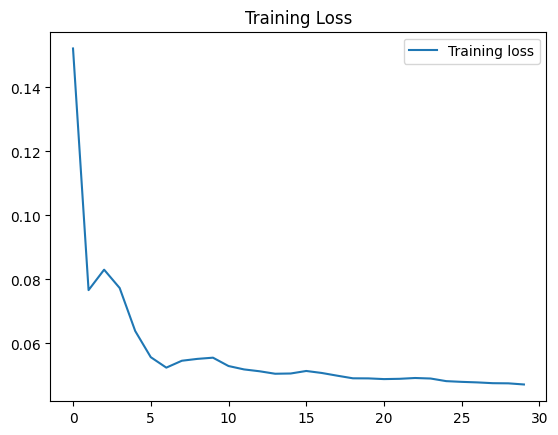

In [ ]:
plt.title('Training Loss')
plt.plot(losses,label = 'Training loss')
plt.legend()
plt.show()

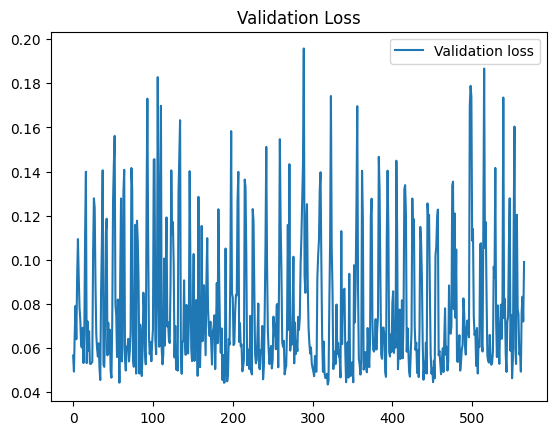

In [ ]:
plt.title('Validation Loss')
plt.plot(val_losses,label = 'Validation loss')
plt.legend()
plt.show()

In [ ]:
y_pred = []
with torch.no_grad():
  for i,data in enumerate(X_test):
    y_val = model(data)
    y_pred.append(y_val)

In [ ]:
y_test.detach().numpy()

array([[ 0.45      , -0.26666668],
       [ 0.45      , -0.22222222],
       [ 0.09299959, -0.22222222],
       ...,
       [ 0.45      , -0.3888889 ],
       [-0.02849947, -0.34444445],
       [-0.32100028, -0.2888889 ]], dtype=float32)

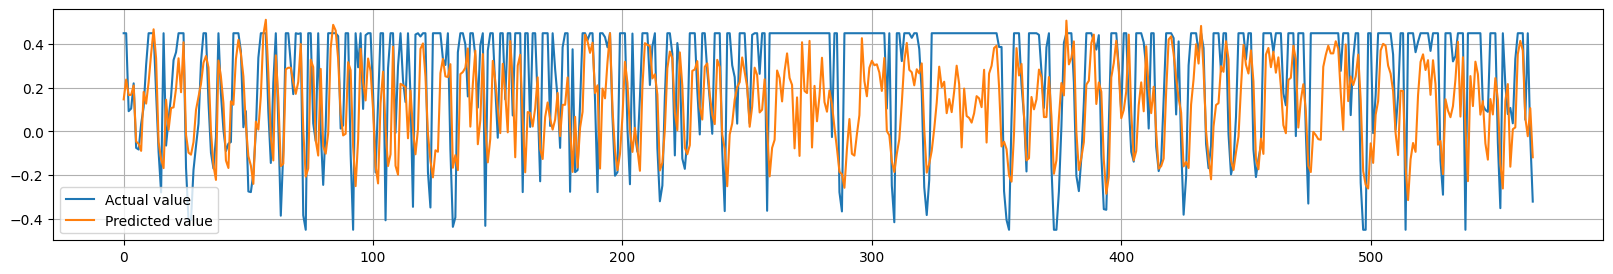

In [ ]:
plt.figure(figsize=(20, 3))
throttle_pwm = []
pred_throttle_pwm = []
for a in y_test.detach().numpy():
  throttle_pwm.append(a[0])
for a in y_pred:
  pred_throttle_pwm.append(a[0])
plt.plot(throttle_pwm,label = 'Actual value')
plt.plot(pred_throttle_pwm,label = 'Predicted value')
plt.legend()
plt.grid()
plt.show()

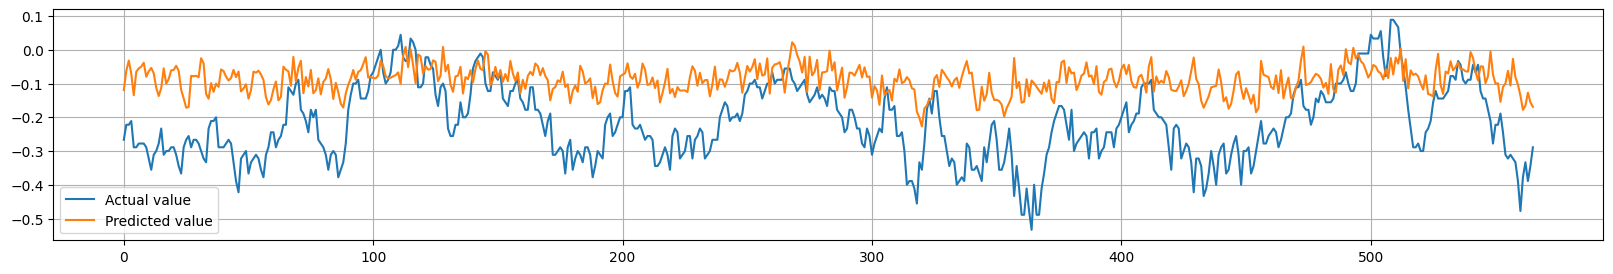

In [ ]:
plt.figure(figsize=(20, 3))
steering_pwm = []
pred_steering_pwm = []
for a in y_test:
  steering_pwm.append(a[1])
for a in y_pred:
  pred_steering_pwm.append(a[1])
plt.plot(steering_pwm,label = 'Actual value')
plt.plot(pred_steering_pwm,label = 'Predicted value')
plt.legend()
plt.grid()
plt.show()

In [ ]:
torch.save(model.state_dict(), '/content/pm2.pth')
model.load_state_dict(torch.load('/content/pm2.pth'))

<All keys matched successfully>

In [ ]:
%%timeit
y_rand = model(torch.randn(1,4))

218 µs ± 56.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


###Model_3

In [ ]:
df.head()

curr_accel_x   curr_accel_y   curr_yaw_rate   throttle_pwm   steering_pwm  \
0      0.000000       0.000000        0.000000          -0.45      -0.111111   
1     -0.048281       0.016782       -0.002222          -0.45      -0.111111   
2      0.087396      -0.023934       -0.004435          -0.45      -0.111111   
3      0.095399       0.165994       -0.002357          -0.45      -0.111111   
4      0.006766       0.166401        0.001327          -0.45      -0.111111   

    voltage   next_accel_x   next_accel_y   next_yaw_rate  
0     7.380      -0.048281       0.016782       -0.002222  
1     7.336       0.087396      -0.023934       -0.004435  
2     7.340       0.095399       0.165994       -0.002357  
3     7.364       0.006766       0.166401        0.001327  
4     7.352      -0.000579      -0.061384       -0.002015

In [ ]:
curr_accel = np.add(np.square(df['curr_accel_x'].values),np.square(df[' curr_accel_y'].values)).reshape(-1,1)
X = np.concatenate((curr_accel,df[' curr_yaw_rate'].values.reshape(-1,1),df[' voltage'].values.reshape(-1,1)),axis = 1)
y = df.iloc[:,3:5].values

In [ ]:
ratio = 0.7
total_rows = df.shape[0]
train_size = int(total_rows*ratio)
X_train = X[0:train_size]
X_test = X[train_size:]
y_train = y[0:train_size]
y_test = y[train_size:]

In [ ]:
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)

In [ ]:
!pip install 'ray[tune]'

In [ ]:
import os
import tempfile
from ray import tune
from ray import train
from ray.train import Checkpoint, get_checkpoint
from ray.tune.schedulers import ASHAScheduler

In [ ]:
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
class NeuralNetwork(nn.Module):
  def __init__(self,layer_1,layer_2,layer_3,dropout_rate,activation):
    super(NeuralNetwork,self).__init__()
    self.activation = activation
    self.relu_nn_model = nn.Sequential(
        nn.Linear(input_dim,layer_1),
        nn.ReLU(),
        nn.Linear(layer_1,layer_2),
        nn.ReLU(),
        nn.Dropout(p = dropout_rate),
        nn.Linear(layer_2,layer_3),
        nn.ReLU(),
        nn.Linear(layer_3,output_dim)
    )
    self.leaky_relu_nn_model = nn.Sequential(
        nn.Linear(input_dim,layer_1),
        nn.LeakyReLU(),
        nn.Linear(layer_1,layer_2),
        nn.LeakyReLU(),
        nn.Dropout(p = dropout_rate),
        nn.Linear(layer_2,layer_3),
        nn.LeakyReLU(),
        nn.Linear(layer_3,output_dim)
    )
    self.tanh_nn_model = nn.Sequential(
        nn.Linear(input_dim,layer_1),
        nn.Tanh(),
        nn.Linear(layer_1,layer_2),
        nn.Tanh(),
        nn.Dropout(p = dropout_rate),
        nn.Linear(layer_2,layer_3),
        nn.Tanh(),
        nn.Linear(layer_3,output_dim)
    )
  def forward(self,x):
    if self.activation == 'relu':
      y = self.relu_nn_model(x)
      return y
    if self.activation == 'leaky_relu':
      y = self.leaky_relu_nn_model(x)
      return y
    if self.activation == 'tanh':
      y = self.tanh_nn_model(x)
      return y

In [ ]:
def train_model(config):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = NeuralNetwork(config['layer_1'], config['layer_2'], config['layer_3'],config['dropout_rate'],config['activation']).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"], weight_decay=1e-5)
    epochs = 30

    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

    test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

    train_losses = []
    val_losses = []
    total_loss = 0
    for epoch in range(epochs):
        model.train()
        for batch in train_loader:
            X_batch, y_batch = batch
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            train_losses.append(loss.item())
            loss.backward()
            optimizer.step()

        if epoch % 10 == 0:
            print(f'Epoch: {epoch} Loss: {loss.item()}')

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in test_loader:
                X_batch, y_batch = batch
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_val = model(X_batch)
                val_loss += criterion(y_val, y_batch).item()

        val_loss /= len(test_loader)
        val_losses.append(val_loss)
        total_loss += val_loss
    total_loss /= epochs
    return {"loss": total_loss}

In [ ]:
config = {
    "lr": tune.loguniform(1e-4, 1e-1),
    "layer_1": tune.choice([x for x in range(32,144,8)]),
    "layer_2": tune.choice([x for x in range(32,144,8)]),
    "layer_3": tune.choice([x for x in range(32,144,8)]),
    "dropout_rate":tune.choice([0.1*x for x in range(1,4)]),
    "activation":tune.choice(['relu','leaky_relu','tanh'])
}

# Scheduler for hyperparameter tuning
scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    max_t=30,
    grace_period=1,
    reduction_factor=2
)

# Run the hyperparameter tuning
analysis = tune.run(
    train_model,
    resources_per_trial={"cpu": 1},
    config=config,
    num_samples=10,
    scheduler=scheduler
)

best_config = analysis.get_best_config(metric="loss", mode="min")
print("Best config:", best_config)

+--------------------------------------------------------------------+
| Configuration for experiment     train_model_2024-06-11_10-20-49   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        AsyncHyperBandScheduler           |
| Number of trials                 10                                |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_model_2024-06-11_10-20-49
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-06-11_10-13-35_337680_174/artifacts/2024-06-11_10-20-49/train_model_2024-06-11_10-20-49/driver_artifacts`

Trial status: 10 PENDING
Current time: 2024-06-11 10:20:49. Total running time: 0s
Logical resource usage: 0/2 CPUs, 0/0 GPUs
+-------------------------------------------------------------------------------------------------

2024-06-11 10:23:01,928	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_model_2024-06-11_10-20-49' in 0.0171s.



Trial train_model_46103_00009 finished iteration 1 at 2024-06-11 10:23:01. Total running time: 2min 12s
+--------------------------------------------------+
| Trial train_model_46103_00009 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         7.62752 |
| time_total_s                             7.62752 |
| training_iteration                             1 |
| loss                                     0.05663 |
+--------------------------------------------------+

Trial train_model_46103_00009 completed after 1 iterations at 2024-06-11 10:23:01. Total running time: 2min 12s

Trial status: 10 TERMINATED
Current time: 2024-06-11 10:23:01. Total running time: 2min 12s
Logical resource usage: 1.0/2 CPUs, 0/0 GPUs
+----------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Tr

In [ ]:
model = NeuralNetwork(best_config['layer_1'],best_config['layer_2'],best_config['layer_3'],best_config['dropout_rate'],best_config['activation']).to(device)
print(model)

NeuralNetwork(
  (relu_nn_model): Sequential(
    (0): Linear(in_features=3, out_features=80, bias=True)
    (1): ReLU()
    (2): Linear(in_features=80, out_features=112, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.1, inplace=False)
    (5): Linear(in_features=112, out_features=56, bias=True)
    (6): ReLU()
    (7): Linear(in_features=56, out_features=2, bias=True)
  )
  (leaky_relu_nn_model): Sequential(
    (0): Linear(in_features=3, out_features=80, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=80, out_features=112, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Dropout(p=0.1, inplace=False)
    (5): Linear(in_features=112, out_features=56, bias=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Linear(in_features=56, out_features=2, bias=True)
  )
  (tanh_nn_model): Sequential(
    (0): Linear(in_features=3, out_features=80, bias=True)
    (1): Tanh()
    (2): Linear(in_features=80, out_features=112, bias=True)
    (3): Tanh()


In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr = best_config['lr'],weight_decay=1e-5)

In [ ]:
epochs = 30
losses = []
for i in range(epochs):
  y_pred = model.forward(X_train)
  loss = criterion(y_pred,y_train)
  losses.append(loss.detach().numpy())
  print(f'Epoch : {i} and Loss: {loss}')
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

Epoch : 0 and Loss: 0.0945407897233963
Epoch : 1 and Loss: 0.08299591392278671
Epoch : 2 and Loss: 0.08420263230800629
Epoch : 3 and Loss: 0.07574104517698288
Epoch : 4 and Loss: 0.07224711775779724
Epoch : 5 and Loss: 0.07607737183570862
Epoch : 6 and Loss: 0.0786828026175499
Epoch : 7 and Loss: 0.07632821798324585
Epoch : 8 and Loss: 0.07343938946723938
Epoch : 9 and Loss: 0.07200820744037628
Epoch : 10 and Loss: 0.07307038456201553
Epoch : 11 and Loss: 0.07431519031524658
Epoch : 12 and Loss: 0.0721781775355339
Epoch : 13 and Loss: 0.07088152319192886
Epoch : 14 and Loss: 0.06958424299955368
Epoch : 15 and Loss: 0.06983032822608948
Epoch : 16 and Loss: 0.07116914540529251
Epoch : 17 and Loss: 0.07058302313089371
Epoch : 18 and Loss: 0.06913761049509048
Epoch : 19 and Loss: 0.06817973405122757
Epoch : 20 and Loss: 0.06870520114898682
Epoch : 21 and Loss: 0.06857824325561523
Epoch : 22 and Loss: 0.06847497075796127
Epoch : 23 and Loss: 0.06804367899894714
Epoch : 24 and Loss: 0.067433

In [ ]:
val_losses = []
with torch.no_grad():
  for i,data in enumerate(X_test):
    y_val = model(data)
    loss = criterion(y_val,y_test)
    val_losses.append(loss.item())
    if i%10 == 0:
      print(f'{i+1}.Loss : {loss}')

1.Loss : 0.07061375677585602
11.Loss : 0.07293685525655746
21.Loss : 0.07226071506738663
31.Loss : 0.09682170301675797
41.Loss : 0.06807946413755417
51.Loss : 0.06294503062963486
61.Loss : 0.060486823320388794
71.Loss : 0.08320925384759903
81.Loss : 0.06785285472869873
91.Loss : 0.0757184624671936
101.Loss : 0.0753127783536911
111.Loss : 0.0646553561091423
121.Loss : 0.05689574405550957
131.Loss : 0.08376095443964005
141.Loss : 0.07085976749658585
151.Loss : 0.07084546238183975
161.Loss : 0.06520736217498779
171.Loss : 0.08310984820127487
181.Loss : 0.08463121205568314
191.Loss : 0.064716637134552
201.Loss : 0.07301615923643112
211.Loss : 0.05684564635157585
221.Loss : 0.050900015980005264
231.Loss : 0.06685612350702286
241.Loss : 0.07209894806146622
251.Loss : 0.0792003646492958
261.Loss : 0.05735758692026138
271.Loss : 0.06537153571844101
281.Loss : 0.07380754500627518
291.Loss : 0.06851010024547577


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([566, 2])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


301.Loss : 0.05825170874595642
311.Loss : 0.0664619579911232
321.Loss : 0.05392327532172203
331.Loss : 0.07172432541847229
341.Loss : 0.08051597326993942
351.Loss : 0.06480970978736877
361.Loss : 0.07355573773384094
371.Loss : 0.059466008096933365
381.Loss : 0.05177127197384834
391.Loss : 0.06109142675995827
401.Loss : 0.07463160157203674
411.Loss : 0.060696255415678024
421.Loss : 0.0527908019721508
431.Loss : 0.07150676846504211
441.Loss : 0.06165585294365883
451.Loss : 0.06806892901659012
461.Loss : 0.06297973543405533
471.Loss : 0.06143437325954437
481.Loss : 0.08259822428226471
491.Loss : 0.06021631136536598
501.Loss : 0.07226396352052689
511.Loss : 0.06846461445093155
521.Loss : 0.06514319032430649
531.Loss : 0.06411263346672058
541.Loss : 0.05502122640609741
551.Loss : 0.07161878794431686
561.Loss : 0.06852736324071884


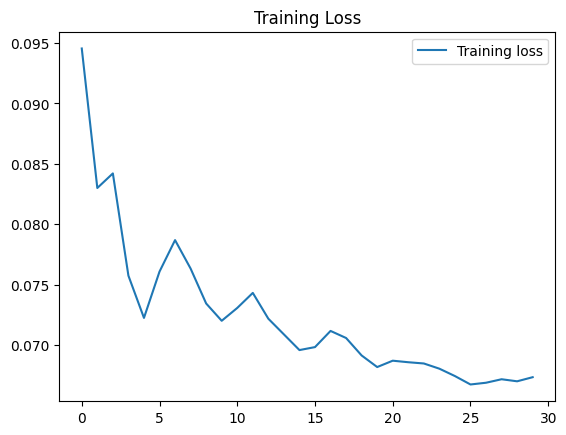

In [ ]:
plt.title('Training Loss')
plt.plot(losses,label = 'Training loss')
plt.legend()
plt.show()

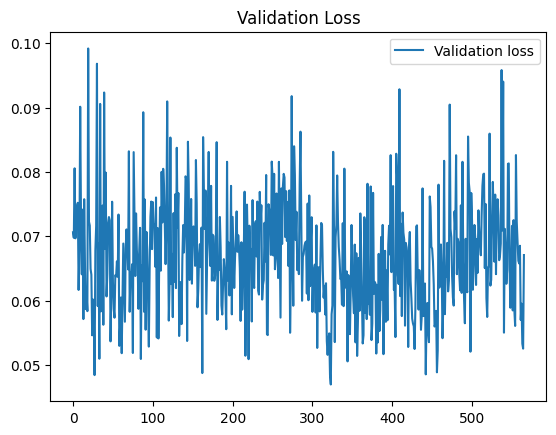

In [ ]:
plt.title('Validation Loss')
plt.plot(val_losses,label = 'Validation loss')
plt.legend()
plt.show()

In [ ]:
y_pred = []
with torch.no_grad():
  for i,data in enumerate(X_test):
    y_val = model(data)
    y_pred.append(y_val)

In [ ]:
y_test.detach().numpy()

array([[ 0.45      , -0.26666668],
       [ 0.45      , -0.22222222],
       [ 0.09299959, -0.22222222],
       ...,
       [ 0.45      , -0.3888889 ],
       [-0.02849947, -0.34444445],
       [-0.32100028, -0.2888889 ]], dtype=float32)

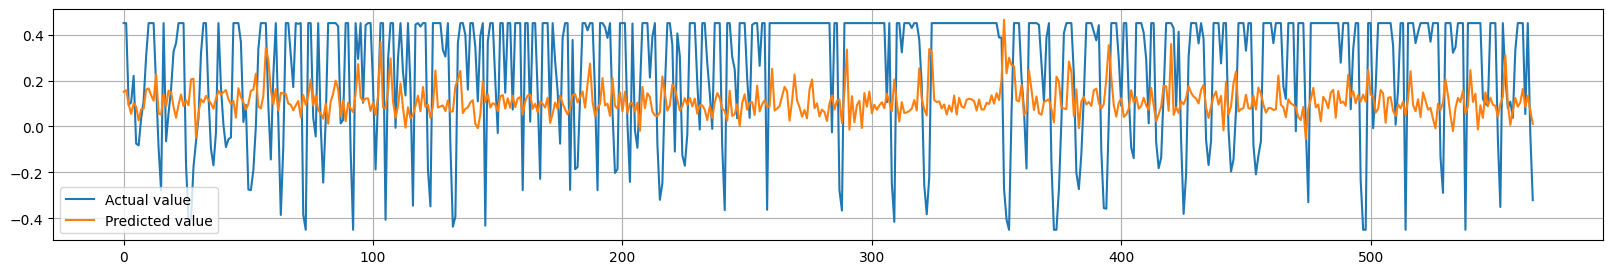

In [ ]:
plt.figure(figsize=(20, 3))
throttle_pwm = []
pred_throttle_pwm = []
for a in y_test.detach().numpy():
  throttle_pwm.append(a[0])
for a in y_pred:
  pred_throttle_pwm.append(a[0])
plt.plot(throttle_pwm,label = 'Actual value')
plt.plot(pred_throttle_pwm,label = 'Predicted value')
plt.legend()
plt.grid()
plt.show()

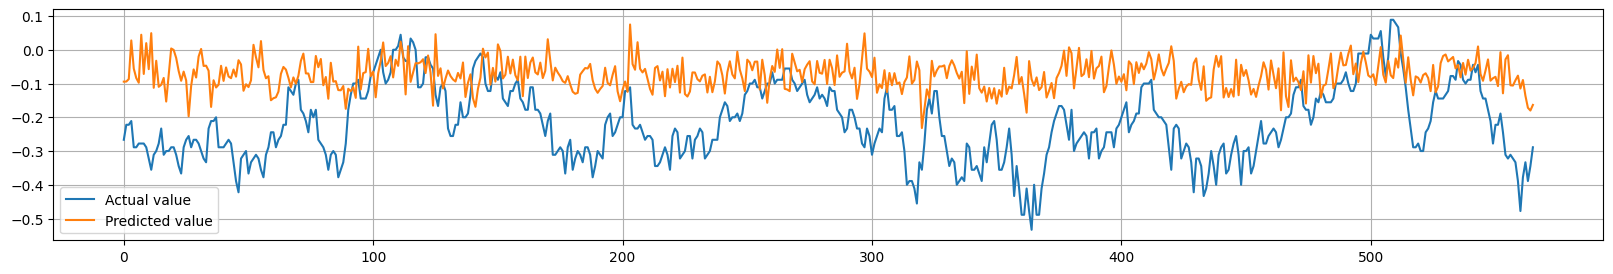

In [ ]:
plt.figure(figsize=(20, 3))
steering_pwm = []
pred_steering_pwm = []
for a in y_test:
  steering_pwm.append(a[1])
for a in y_pred:
  pred_steering_pwm.append(a[1])
plt.plot(steering_pwm,label = 'Actual value')
plt.plot(pred_steering_pwm,label = 'Predicted value')
plt.legend()
plt.grid()
plt.show()

In [ ]:
%%timeit
y_rand = model(torch.randn(1,3))

279 µs ± 92.6 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
torch.save(model.state_dict(), '/content/pm3.pth')
model.load_state_dict(torch.load('/content/pm3.pth'))

<All keys matched successfully>

###Model_4

In [ ]:
df.head()

curr_accel_x   curr_accel_y   curr_yaw_rate   throttle_pwm   steering_pwm  \
0      0.000000       0.000000        0.000000          -0.45      -0.111111   
1     -0.048281       0.016782       -0.002222          -0.45      -0.111111   
2      0.087396      -0.023934       -0.004435          -0.45      -0.111111   
3      0.095399       0.165994       -0.002357          -0.45      -0.111111   
4      0.006766       0.166401        0.001327          -0.45      -0.111111   

    voltage   next_accel_x   next_accel_y   next_yaw_rate  
0     7.380      -0.048281       0.016782       -0.002222  
1     7.336       0.087396      -0.023934       -0.004435  
2     7.340       0.095399       0.165994       -0.002357  
3     7.364       0.006766       0.166401        0.001327  
4     7.352      -0.000579      -0.061384       -0.002015

In [ ]:
next_accel = np.add(np.square(df[' next_accel_x'].values),np.square(df[' next_accel_y'].values)).reshape(-1,1)
X = np.concatenate((next_accel,df[' next_yaw_rate'].values.reshape(-1,1),df[' voltage'].values.reshape(-1,1)),axis = 1)
y = df.iloc[:,3:5].values

In [ ]:
ratio = 0.7
total_rows = df.shape[0]
train_size = int(total_rows*ratio)
X_train = X[0:train_size]
X_test = X[train_size:]
y_train = y[0:train_size]
y_test = y[train_size:]

In [ ]:
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)

In [ ]:
!pip install 'ray[tune]'

In [ ]:
import os
import tempfile
from ray import tune
from ray import train
from ray.train import Checkpoint, get_checkpoint
from ray.tune.schedulers import ASHAScheduler

In [ ]:
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
class NeuralNetwork(nn.Module):
  def __init__(self,layer_1,layer_2,layer_3,dropout_rate,activation):
    super(NeuralNetwork,self).__init__()
    self.activation = activation
    self.relu_nn_model = nn.Sequential(
        nn.Linear(input_dim,layer_1),
        nn.ReLU(),
        nn.Linear(layer_1,layer_2),
        nn.ReLU(),
        nn.Dropout(p = dropout_rate),
        nn.Linear(layer_2,layer_3),
        nn.ReLU(),
        nn.Linear(layer_3,output_dim)
    )
    self.leaky_relu_nn_model = nn.Sequential(
        nn.Linear(input_dim,layer_1),
        nn.LeakyReLU(),
        nn.Linear(layer_1,layer_2),
        nn.LeakyReLU(),
        nn.Dropout(p = dropout_rate),
        nn.Linear(layer_2,layer_3),
        nn.LeakyReLU(),
        nn.Linear(layer_3,output_dim)
    )
    self.tanh_nn_model = nn.Sequential(
        nn.Linear(input_dim,layer_1),
        nn.Tanh(),
        nn.Linear(layer_1,layer_2),
        nn.Tanh(),
        nn.Dropout(p = dropout_rate),
        nn.Linear(layer_2,layer_3),
        nn.Tanh(),
        nn.Linear(layer_3,output_dim)
    )
  def forward(self,x):
    if self.activation == 'relu':
      y = self.relu_nn_model(x)
      return y
    if self.activation == 'leaky_relu':
      y = self.leaky_relu_nn_model(x)
      return y
    if self.activation == 'tanh':
      y = self.tanh_nn_model(x)
      return y

In [ ]:
def train_model(config):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = NeuralNetwork(config['layer_1'], config['layer_2'], config['layer_3'],config['dropout_rate'],config['activation']).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"], weight_decay=1e-5)
    epochs = 30

    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

    test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

    train_losses = []
    val_losses = []
    total_loss = 0

    for epoch in range(epochs):
        model.train()
        for batch in train_loader:
            X_batch, y_batch = batch
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            train_losses.append(loss.item())
            loss.backward()
            optimizer.step()

        if epoch % 10 == 0:
            print(f'Epoch: {epoch} Loss: {loss.item()}')

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in test_loader:
                X_batch, y_batch = batch
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_val = model(X_batch)
                val_loss += criterion(y_val, y_batch).item()

        val_loss /= len(test_loader)
        val_losses.append(val_loss)
        total_loss += val_loss
    total_loss /= epochs
    return {"loss": total_loss}

In [ ]:
config = {
    "lr": tune.loguniform(1e-4, 1e-1),
    "layer_1": tune.choice([x for x in range(32,144,8)]),
    "layer_2": tune.choice([x for x in range(32,144,8)]),
    "layer_3": tune.choice([x for x in range(32,144,8)]),
    "dropout_rate":tune.choice([0.1*x for x in range(1,4)]),
    "activation":tune.choice(['relu','leaky_relu','tanh'])
}

# Scheduler for hyperparameter tuning
scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    max_t=30,
    grace_period=1,
    reduction_factor=2
)

# Run the hyperparameter tuning
analysis = tune.run(
    train_model,
    resources_per_trial={"cpu": 1},
    config=config,
    num_samples=10,
    scheduler=scheduler
)

best_config = analysis.get_best_config(metric="loss", mode="min")
print("Best config:", best_config)

+--------------------------------------------------------------------+
| Configuration for experiment     train_model_2024-06-11_10-24-23   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        AsyncHyperBandScheduler           |
| Number of trials                 10                                |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_model_2024-06-11_10-24-23
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-06-11_10-13-35_337680_174/artifacts/2024-06-11_10-24-23/train_model_2024-06-11_10-24-23/driver_artifacts`

Trial status: 10 PENDING
Current time: 2024-06-11 10:24:23. Total running time: 0s
Logical resource usage: 0/2 CPUs, 0/0 GPUs
+-------------------------------------------------------------------------------------------------

2024-06-11 10:26:30,681	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_model_2024-06-11_10-24-23' in 0.0132s.



Trial train_model_c599e_00008 finished iteration 1 at 2024-06-11 10:26:30. Total running time: 2min 7s
+--------------------------------------------------+
| Trial train_model_c599e_00008 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         9.73965 |
| time_total_s                             9.73965 |
| training_iteration                             1 |
| loss                                     0.04941 |
+--------------------------------------------------+

Trial train_model_c599e_00008 completed after 1 iterations at 2024-06-11 10:26:30. Total running time: 2min 7s

Trial train_model_c599e_00009 finished iteration 1 at 2024-06-11 10:26:30. Total running time: 2min 7s
+--------------------------------------------------+
| Trial train_model_c599e_00009 result             |
+--------------------------------------------------+
| checkpoint_dir_name                       

In [ ]:
model = NeuralNetwork(best_config['layer_1'],best_config['layer_2'],best_config['layer_3'],best_config['dropout_rate'],best_config['activation']).to(device)
print(model)

NeuralNetwork(
  (relu_nn_model): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=104, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.1, inplace=False)
    (5): Linear(in_features=104, out_features=40, bias=True)
    (6): ReLU()
    (7): Linear(in_features=40, out_features=2, bias=True)
  )
  (leaky_relu_nn_model): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=32, out_features=104, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Dropout(p=0.1, inplace=False)
    (5): Linear(in_features=104, out_features=40, bias=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Linear(in_features=40, out_features=2, bias=True)
  )
  (tanh_nn_model): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=104, bias=True)
    (3): Tanh()


In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr = best_config['lr'],weight_decay=1e-5)

In [ ]:
epochs = 30
losses = []
for i in range(epochs):
  y_pred = model.forward(X_train)
  loss = criterion(y_pred,y_train)
  losses.append(loss.detach().numpy())
  print(f'Epoch : {i} and Loss: {loss}')
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

Epoch : 0 and Loss: 0.16884629428386688
Epoch : 1 and Loss: 0.08565978705883026
Epoch : 2 and Loss: 0.07879693806171417
Epoch : 3 and Loss: 0.09907842427492142
Epoch : 4 and Loss: 0.10559534281492233
Epoch : 5 and Loss: 0.09493402391672134
Epoch : 6 and Loss: 0.0809643492102623
Epoch : 7 and Loss: 0.0725133940577507
Epoch : 8 and Loss: 0.07163337618112564
Epoch : 9 and Loss: 0.07523946464061737
Epoch : 10 and Loss: 0.07929905503988266
Epoch : 11 and Loss: 0.08105966448783875
Epoch : 12 and Loss: 0.07998324930667877
Epoch : 13 and Loss: 0.0757339745759964
Epoch : 14 and Loss: 0.07121285796165466
Epoch : 15 and Loss: 0.06885877996683121
Epoch : 16 and Loss: 0.06874126940965652
Epoch : 17 and Loss: 0.06937416642904282
Epoch : 18 and Loss: 0.07091262936592102
Epoch : 19 and Loss: 0.07204356789588928
Epoch : 20 and Loss: 0.07205830514431
Epoch : 21 and Loss: 0.07110671699047089
Epoch : 22 and Loss: 0.06967359781265259
Epoch : 23 and Loss: 0.06848972290754318
Epoch : 24 and Loss: 0.066856212

In [ ]:
val_losses = []
with torch.no_grad():
  for i,data in enumerate(X_test):
    y_val = model(data)
    loss = criterion(y_val,y_test)
    val_losses.append(loss.item())
    if i%10 == 0:
      print(f'{i+1}.Loss : {loss}')

1.Loss : 0.07997407019138336
11.Loss : 0.08021478354930878
21.Loss : 0.07922098785638809
31.Loss : 0.07102594524621964
41.Loss : 0.08919626474380493
51.Loss : 0.09020702540874481
61.Loss : 0.08456192165613174
71.Loss : 0.07277991622686386
81.Loss : 0.09384597092866898
91.Loss : 0.0822688564658165
101.Loss : 0.06962735205888748
111.Loss : 0.0823962539434433
121.Loss : 0.07379282265901566
131.Loss : 0.07015621662139893
141.Loss : 0.06830443441867828
151.Loss : 0.07920099049806595
161.Loss : 0.07886409759521484
171.Loss : 0.06860674917697906
181.Loss : 0.07555420696735382
191.Loss : 0.06989223510026932
201.Loss : 0.06488112360239029
211.Loss : 0.10374950617551804
221.Loss : 0.08524805307388306
231.Loss : 0.06698013097047806
241.Loss : 0.05823561176657677
251.Loss : 0.06307724118232727
261.Loss : 0.08551822602748871
271.Loss : 0.0842740535736084
281.Loss : 0.08701450377702713
291.Loss : 0.07204896956682205
301.Loss : 0.07631339877843857
311.Loss : 0.08206694573163986
321.Loss : 0.085632555

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([566, 2])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


331.Loss : 0.07119344174861908
341.Loss : 0.07557302713394165
351.Loss : 0.07344462722539902
361.Loss : 0.0788654312491417
371.Loss : 0.06983605027198792
381.Loss : 0.07222934812307358
391.Loss : 0.07128845900297165
401.Loss : 0.07090312242507935
411.Loss : 0.08601965010166168
421.Loss : 0.10175587981939316
431.Loss : 0.08007629215717316
441.Loss : 0.07403085380792618
451.Loss : 0.06741444021463394
461.Loss : 0.07712423801422119
471.Loss : 0.08608398586511612
481.Loss : 0.0805482342839241
491.Loss : 0.08297540247440338
501.Loss : 0.08199610561132431
511.Loss : 0.08256796002388
521.Loss : 0.08162076026201248
531.Loss : 0.08137597888708115
541.Loss : 0.09582734853029251
551.Loss : 0.07888209819793701
561.Loss : 0.09386351704597473


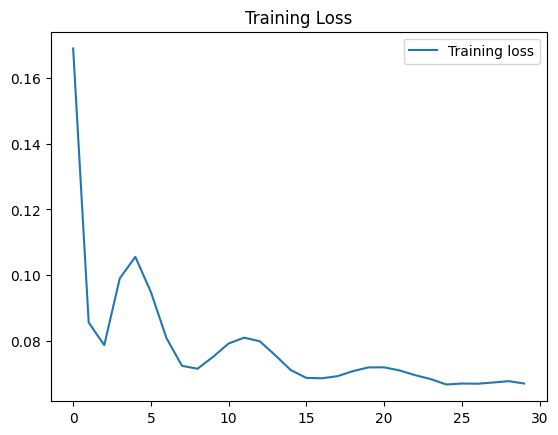

In [ ]:
plt.title('Training Loss')
plt.plot(losses,label = 'Training loss')
plt.legend()
plt.show()

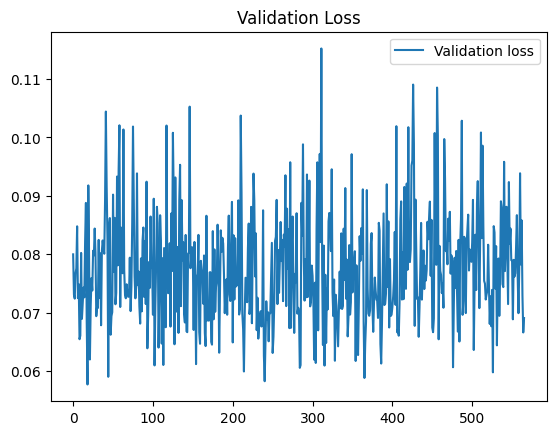

In [ ]:
plt.title('Validation Loss')
plt.plot(val_losses,label = 'Validation loss')
plt.legend()
plt.show()

In [ ]:
y_pred = []
with torch.no_grad():
  for i,data in enumerate(X_test):
    y_val = model(data)
    y_pred.append(y_val)

In [ ]:
y_test.detach().numpy()

array([[ 0.45      , -0.26666668],
       [ 0.45      , -0.22222222],
       [ 0.09299959, -0.22222222],
       ...,
       [ 0.45      , -0.3888889 ],
       [-0.02849947, -0.34444445],
       [-0.32100028, -0.2888889 ]], dtype=float32)

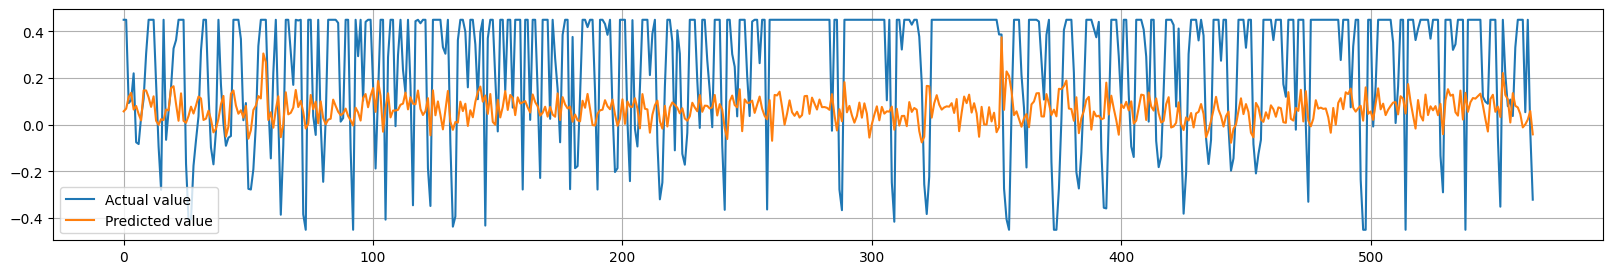

In [ ]:
plt.figure(figsize=(20, 3))
throttle_pwm = []
pred_throttle_pwm = []
for a in y_test.detach().numpy():
  throttle_pwm.append(a[0])
for a in y_pred:
  pred_throttle_pwm.append(a[0])
plt.plot(throttle_pwm,label = 'Actual value')
plt.plot(pred_throttle_pwm,label = 'Predicted value')
plt.legend()
plt.grid()
plt.show()

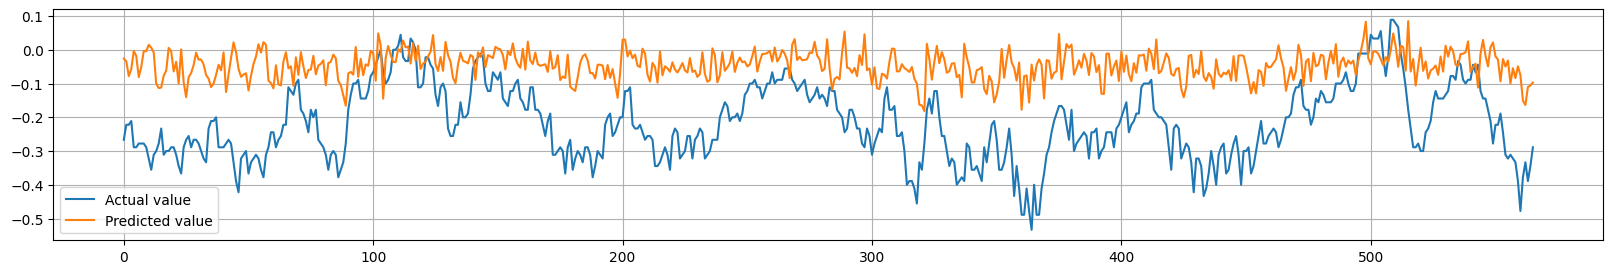

In [ ]:
plt.figure(figsize=(20, 3))
steering_pwm = []
pred_steering_pwm = []
for a in y_test:
  steering_pwm.append(a[1])
for a in y_pred:
  pred_steering_pwm.append(a[1])
plt.plot(steering_pwm,label = 'Actual value')
plt.plot(pred_steering_pwm,label = 'Predicted value')
plt.legend()
plt.grid()
plt.show()

In [ ]:
%%timeit
y_rand = model(torch.randn(1,3))

231 µs ± 55.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
torch.save(model.state_dict(), '/content/pm4.pth')
model.load_state_dict(torch.load('/content/pm4.pth'))

<All keys matched successfully>

###Model_5 - DNN

In [ ]:
df.head()

curr_accel_x   curr_accel_y   curr_yaw_rate   throttle_pwm   steering_pwm  \
0      0.000000       0.000000        0.000000          -0.45      -0.111111   
1     -0.048281       0.016782       -0.002222          -0.45      -0.111111   
2      0.087396      -0.023934       -0.004435          -0.45      -0.111111   
3      0.095399       0.165994       -0.002357          -0.45      -0.111111   
4      0.006766       0.166401        0.001327          -0.45      -0.111111   

    voltage   next_accel_x   next_accel_y   next_yaw_rate  
0     7.380      -0.048281       0.016782       -0.002222  
1     7.336       0.087396      -0.023934       -0.004435  
2     7.340       0.095399       0.165994       -0.002357  
3     7.364       0.006766       0.166401        0.001327  
4     7.352      -0.000579      -0.061384       -0.002015

In [ ]:
X = np.concatenate((df.iloc[:,:3].values,df.iloc[:,5:].values),axis = 1)
y = df.iloc[:,3:5].values

In [ ]:
ratio = 0.7
total_rows = df.shape[0]
train_size = int(total_rows*ratio)
X_train = X[0:train_size]
X_test = X[train_size:]
y_train = y[0:train_size]
y_test = y[train_size:]

In [ ]:
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)

In [ ]:
!pip install 'ray[tune]'

In [ ]:
import os
import tempfile
from ray import tune
from ray import train
from ray.train import Checkpoint, get_checkpoint
from ray.tune.schedulers import ASHAScheduler

In [ ]:
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
class NeuralNetwork(nn.Module):
  def __init__(self,layer_1,layer_2,layer_3,dropout_rate,activation):
    super(NeuralNetwork,self).__init__()
    self.activation = activation
    self.relu_nn_model = nn.Sequential(
        nn.Linear(input_dim,layer_1),
        nn.ReLU(),
        nn.Linear(layer_1,layer_2),
        nn.ReLU(),
        nn.Dropout(p = dropout_rate),
        nn.Linear(layer_2,layer_3),
        nn.ReLU(),
        nn.Linear(layer_3,output_dim)
    )
    self.leaky_relu_nn_model = nn.Sequential(
        nn.Linear(input_dim,layer_1),
        nn.LeakyReLU(),
        nn.Linear(layer_1,layer_2),
        nn.LeakyReLU(),
        nn.Dropout(p = dropout_rate),
        nn.Linear(layer_2,layer_3),
        nn.LeakyReLU(),
        nn.Linear(layer_3,output_dim)
    )
    self.tanh_nn_model = nn.Sequential(
        nn.Linear(input_dim,layer_1),
        nn.Tanh(),
        nn.Linear(layer_1,layer_2),
        nn.Tanh(),
        nn.Dropout(p = dropout_rate),
        nn.Linear(layer_2,layer_3),
        nn.Tanh(),
        nn.Linear(layer_3,output_dim)
    )
  def forward(self,x):
    if self.activation == 'relu':
      y = self.relu_nn_model(x)
      return y
    if self.activation == 'leaky_relu':
      y = self.leaky_relu_nn_model(x)
      return y
    if self.activation == 'tanh':
      y = self.tanh_nn_model(x)
      return y

In [ ]:
def train_model(config):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = NeuralNetwork(config['layer_1'], config['layer_2'], config['layer_3'],config['dropout_rate'],config['activation']).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"], weight_decay=1e-5)
    epochs = 30

    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

    test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

    train_losses = []
    val_losses = []
    total_loss = 0
    for epoch in range(epochs):
        model.train()
        for batch in train_loader:
            X_batch, y_batch = batch
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            train_losses.append(loss.item())
            loss.backward()
            optimizer.step()

        if epoch % 10 == 0:
            print(f'Epoch: {epoch} Loss: {loss.item()}')

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in test_loader:
                X_batch, y_batch = batch
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_val = model(X_batch)
                val_loss += criterion(y_val, y_batch).item()

        val_loss /= len(test_loader)
        val_losses.append(val_loss)
        total_loss += val_loss
    total_loss /= epochs
    return {"loss": total_loss}

In [ ]:
config = {
    "lr": tune.loguniform(1e-4, 1e-1),
    "layer_1": tune.choice([x for x in range(32,144,8)]),
    "layer_2": tune.choice([x for x in range(32,144,8)]),
    "layer_3": tune.choice([x for x in range(32,144,8)]),
    "dropout_rate":tune.choice([0.1*x for x in range(1,4)]),
    "activation":tune.choice(['relu','leaky_relu','tanh'])
}

# Scheduler for hyperparameter tuning
scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    max_t=30,
    grace_period=1,
    reduction_factor=2
)

# Run the hyperparameter tuning
analysis = tune.run(
    train_model,
    resources_per_trial={"cpu": 1},
    config=config,
    num_samples=10,
    scheduler=scheduler
)

best_config = analysis.get_best_config(metric="loss", mode="min")
print("Best config:", best_config)

+--------------------------------------------------------------------+
| Configuration for experiment     train_model_2024-06-11_10-27-28   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        AsyncHyperBandScheduler           |
| Number of trials                 10                                |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_model_2024-06-11_10-27-28
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-06-11_10-13-35_337680_174/artifacts/2024-06-11_10-27-28/train_model_2024-06-11_10-27-28/driver_artifacts`

Trial status: 10 PENDING
Current time: 2024-06-11 10:27:28. Total running time: 0s
Logical resource usage: 0/2 CPUs, 0/0 GPUs
+-------------------------------------------------------------------------------------------------

2024-06-11 10:29:18,309	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_model_2024-06-11_10-27-28' in 0.0151s.



Trial train_model_33dbf_00009 finished iteration 1 at 2024-06-11 10:29:18. Total running time: 1min 49s
+--------------------------------------------------+
| Trial train_model_33dbf_00009 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         7.50203 |
| time_total_s                             7.50203 |
| training_iteration                             1 |
| loss                                     0.05082 |
+--------------------------------------------------+

Trial train_model_33dbf_00009 completed after 1 iterations at 2024-06-11 10:29:18. Total running time: 1min 49s

Trial status: 10 TERMINATED
Current time: 2024-06-11 10:29:18. Total running time: 1min 50s
Logical resource usage: 1.0/2 CPUs, 0/0 GPUs
+----------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Tr

In [ ]:
model = NeuralNetwork(best_config['layer_1'],best_config['layer_2'],best_config['layer_3'],best_config['dropout_rate'],best_config['activation']).to(device)
print(model)

NeuralNetwork(
  (relu_nn_model): Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=56, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.1, inplace=False)
    (5): Linear(in_features=56, out_features=88, bias=True)
    (6): ReLU()
    (7): Linear(in_features=88, out_features=2, bias=True)
  )
  (leaky_relu_nn_model): Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=64, out_features=56, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Dropout(p=0.1, inplace=False)
    (5): Linear(in_features=56, out_features=88, bias=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Linear(in_features=88, out_features=2, bias=True)
  )
  (tanh_nn_model): Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=56, bias=True)
    (3): Tanh()
    (

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr = best_config['lr'],weight_decay=1e-5)

In [ ]:
epochs = 30
losses = []
for i in range(epochs):
  y_pred = model.forward(X_train)
  loss = criterion(y_pred,y_train)
  losses.append(loss.detach().numpy())
  print(f'Epoch : {i} and Loss: {loss}')
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

Epoch : 0 and Loss: 0.08284769207239151
Epoch : 1 and Loss: 0.07503925263881683
Epoch : 2 and Loss: 0.06517092883586884
Epoch : 3 and Loss: 0.05677170678973198
Epoch : 4 and Loss: 0.055447984486818314
Epoch : 5 and Loss: 0.0534660741686821
Epoch : 6 and Loss: 0.048248402774333954
Epoch : 7 and Loss: 0.04668432101607323
Epoch : 8 and Loss: 0.049774084240198135
Epoch : 9 and Loss: 0.04596508666872978
Epoch : 10 and Loss: 0.04405542463064194
Epoch : 11 and Loss: 0.04370870813727379
Epoch : 12 and Loss: 0.04480888321995735
Epoch : 13 and Loss: 0.04333295300602913
Epoch : 14 and Loss: 0.042385611683130264
Epoch : 15 and Loss: 0.04281392693519592
Epoch : 16 and Loss: 0.04285084828734398
Epoch : 17 and Loss: 0.04198689013719559
Epoch : 18 and Loss: 0.041724640876054764
Epoch : 19 and Loss: 0.041825857013463974
Epoch : 20 and Loss: 0.041201114654541016
Epoch : 21 and Loss: 0.04106602072715759
Epoch : 22 and Loss: 0.04019003361463547
Epoch : 23 and Loss: 0.0400397963821888
Epoch : 24 and Loss: 

In [ ]:
val_losses = []
with torch.no_grad():
  for i,data in enumerate(X_test):
    y_val = model(data)
    loss = criterion(y_val,y_test)
    val_losses.append(loss.item())
    if i%10 == 0:
      print(f'{i+1}.Loss : {loss}')

1.Loss : 0.05430776998400688
11.Loss : 0.06608708947896957
21.Loss : 0.07103782147169113
31.Loss : 0.06873806565999985
41.Loss : 0.06480899453163147
51.Loss : 0.16124874353408813
61.Loss : 0.10849941521883011
71.Loss : 0.05149015784263611
81.Loss : 0.20380280911922455
91.Loss : 0.056255191564559937
101.Loss : 0.07284193485975266
111.Loss : 0.13540451228618622
121.Loss : 0.07032772898674011
131.Loss : 0.061848778277635574
141.Loss : 0.04606074094772339
151.Loss : 0.09353766590356827
161.Loss : 0.08339451998472214
171.Loss : 0.06221151724457741
181.Loss : 0.12584158778190613
191.Loss : 0.05791136994957924
201.Loss : 0.06380162388086319
211.Loss : 0.04878353700041771
221.Loss : 0.04724179208278656
231.Loss : 0.043415267020463943
241.Loss : 0.1175295040011406
251.Loss : 0.055149633437395096
261.Loss : 0.07079076766967773
271.Loss : 0.08872732520103455
281.Loss : 0.05056598410010338
291.Loss : 0.050632230937480927
301.Loss : 0.04836666211485863
311.Loss : 0.0859370306134224
321.Loss : 0.069

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([566, 2])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


391.Loss : 0.11298175156116486
401.Loss : 0.15656979382038116
411.Loss : 0.04997390881180763
421.Loss : 0.04963823780417442
431.Loss : 0.04838228598237038
441.Loss : 0.044863011687994
451.Loss : 0.05081961676478386
461.Loss : 0.05557854473590851
471.Loss : 0.04415316507220268
481.Loss : 0.08550271391868591
491.Loss : 0.08755907416343689
501.Loss : 0.06721269339323044
511.Loss : 0.12952469289302826
521.Loss : 0.045200515538454056
531.Loss : 0.05080889165401459
541.Loss : 0.07452834397554398
551.Loss : 0.047205228358507156
561.Loss : 0.0576501302421093


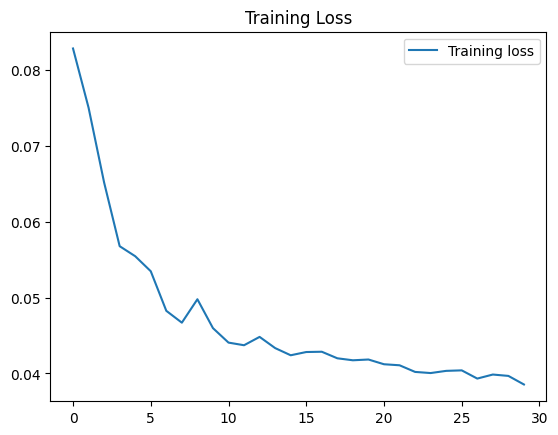

In [ ]:
plt.title('Training Loss')
plt.plot(losses,label = 'Training loss')
plt.legend()
plt.show()

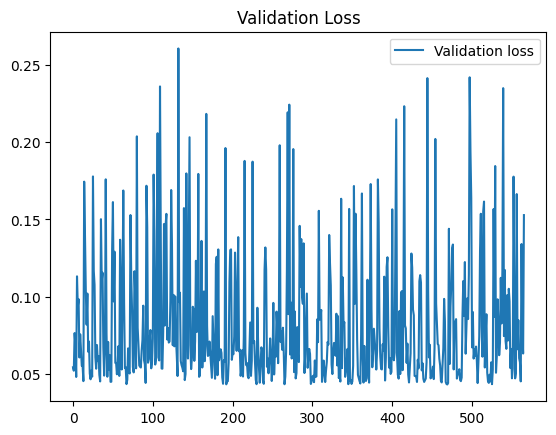

In [ ]:
plt.title('Validation Loss')
plt.plot(val_losses,label = 'Validation loss')
plt.legend()
plt.show()

In [ ]:
y_pred = []
with torch.no_grad():
  for i,data in enumerate(X_test):
    y_val = model(data)
    y_pred.append(y_val)

In [ ]:
y_test.detach().numpy()

array([[ 0.45      , -0.26666668],
       [ 0.45      , -0.22222222],
       [ 0.09299959, -0.22222222],
       ...,
       [ 0.45      , -0.3888889 ],
       [-0.02849947, -0.34444445],
       [-0.32100028, -0.2888889 ]], dtype=float32)

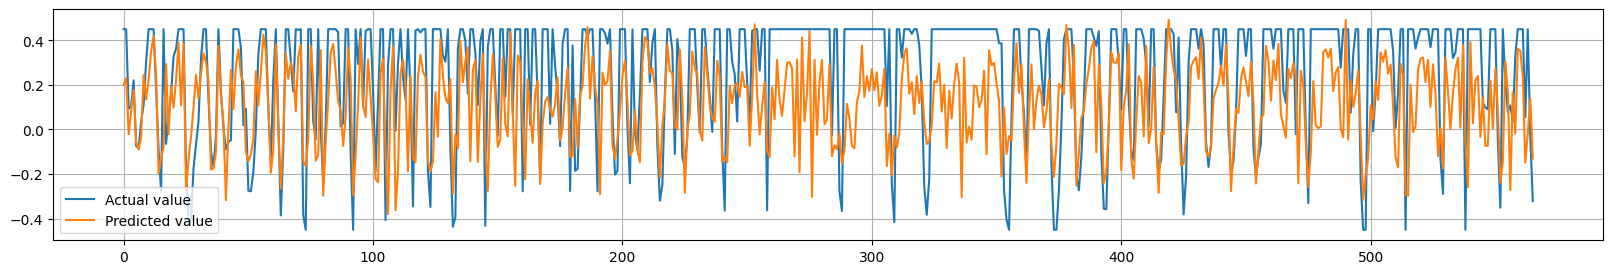

In [ ]:
plt.figure(figsize=(20, 3))
throttle_pwm = []
pred_throttle_pwm = []
for a in y_test.detach().numpy():
  throttle_pwm.append(a[0])
for a in y_pred:
  pred_throttle_pwm.append(a[0])
plt.plot(throttle_pwm,label = 'Actual value')
plt.plot(pred_throttle_pwm,label = 'Predicted value')
plt.legend()
plt.grid()
plt.show()

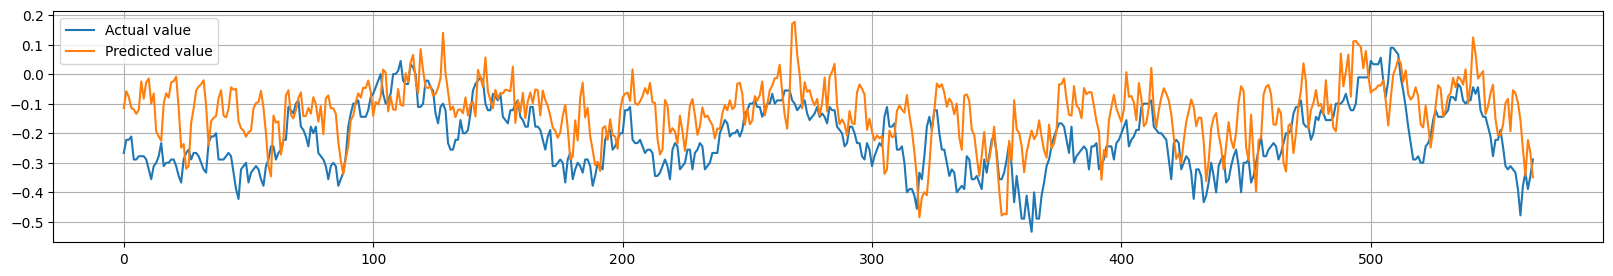

In [ ]:
plt.figure(figsize=(20, 3))
steering_pwm = []
pred_steering_pwm = []
for a in y_test:
  steering_pwm.append(a[1])
for a in y_pred:
  pred_steering_pwm.append(a[1])
plt.plot(steering_pwm,label = 'Actual value')
plt.plot(pred_steering_pwm,label = 'Predicted value')
plt.legend()
plt.grid()
plt.show()

In [ ]:
%%timeit
y_rand = model(torch.randn(1,7))

304 µs ± 17.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
torch.save(model.state_dict(), '/content/pm5.pth')
model.load_state_dict(torch.load('/content/pm5.pth'))

<All keys matched successfully>

###Model_5 - LSTM

In [ ]:
df.head()

curr_accel_x   curr_accel_y   curr_yaw_rate   throttle_pwm   steering_pwm  \
0      0.000000       0.000000        0.000000          -0.45      -0.111111   
1     -0.048281       0.016782       -0.002222          -0.45      -0.111111   
2      0.087396      -0.023934       -0.004435          -0.45      -0.111111   
3      0.095399       0.165994       -0.002357          -0.45      -0.111111   
4      0.006766       0.166401        0.001327          -0.45      -0.111111   

    voltage   next_accel_x   next_accel_y   next_yaw_rate  
0     7.380      -0.048281       0.016782       -0.002222  
1     7.336       0.087396      -0.023934       -0.004435  
2     7.340       0.095399       0.165994       -0.002357  
3     7.364       0.006766       0.166401        0.001327  
4     7.352      -0.000579      -0.061384       -0.002015

In [ ]:
X = np.concatenate((df.iloc[:,:3].values,df.iloc[:,5:].values),axis = 1)
y = df.iloc[:,3:5].values

In [ ]:
ratio = 0.7
total_rows = df.shape[0]
train_size = int(total_rows*ratio)
X_train = X[0:train_size]
X_test = X[train_size:]
y_train = y[0:train_size]
y_test = y[train_size:]

In [ ]:
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)

In [ ]:
from torch.utils.data import Dataset, DataLoader

class SequenceDataset(Dataset):
    def __init__(self, X, y, seq_length):
        self.X = X
        self.y = y
        self.seq_length = seq_length

    def __len__(self):
        return len(self.X) - self.seq_length + 1

    def __getitem__(self, idx):
        return (
            self.X[idx:idx+self.seq_length],
            self.y[idx+self.seq_length-1])

seq_length = 3

train_dataset = SequenceDataset(X_train, y_train, seq_length)
test_dataset = SequenceDataset(X_test, y_test, seq_length)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
!pip install 'ray[tune]'

In [ ]:
import os
import tempfile
from ray import tune
from ray import train
from ray.train import Checkpoint, get_checkpoint
from ray.tune.schedulers import ASHAScheduler

In [ ]:
input_size = X_train.shape[1]
output_size = y_train.shape[1]
class LSTMModel(nn.Module):
    def __init__(self,hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
def train_model(config):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = LSTMModel(config['hidden_size'],config['num_layers']).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"], weight_decay=1e-5)
    epochs = 30

    train_losses = []
    val_losses = []
    total_loss = 0
    for epoch in range(epochs):
        model.train()
        for batch in train_loader:
            X_batch, y_batch = batch
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            train_losses.append(loss.item())
            loss.backward()
            optimizer.step()

        if epoch % 10 == 0:
            print(f'Epoch: {epoch} Loss: {loss.item()}')

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in test_loader:
                X_batch, y_batch = batch
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_val = model(X_batch)
                val_loss += criterion(y_val, y_batch).item()

        val_loss /= len(test_loader)
        val_losses.append(val_loss)
        total_loss += val_loss
    total_loss /= epochs
    return {"loss": total_loss}

In [ ]:
config = {
    "lr": tune.loguniform(1e-4, 1e-1),
    "num_layers": tune.choice([x for x in range(1,4)]),
    "hidden_size":tune.choice([x for x in range(32,144,16)])
}

# Scheduler for hyperparameter tuning
scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    max_t=30,
    grace_period=1,
    reduction_factor=2
)

# Run the hyperparameter tuning
analysis = tune.run(
    train_model,
    resources_per_trial={"cpu": 1},
    config=config,
    num_samples=10,
    scheduler=scheduler
)

best_config = analysis.get_best_config(metric="loss", mode="min")
print("Best config:", best_config)

+--------------------------------------------------------------------+
| Configuration for experiment     train_model_2024-06-10_05-59-51   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        AsyncHyperBandScheduler           |
| Number of trials                 10                                |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_model_2024-06-10_05-59-51
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-06-10_05-44-26_520228_8153/artifacts/2024-06-10_05-59-51/train_model_2024-06-10_05-59-51/driver_artifacts`

Trial status: 10 PENDING
Current time: 2024-06-10 05:59:52. Total running time: 0s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------+
| Trial nam

2024-06-10 06:02:18,781	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_model_2024-06-10_05-59-51' in 0.0106s.



Trial train_model_a71b4_00009 finished iteration 1 at 2024-06-10 06:02:18. Total running time: 2min 26s
+--------------------------------------------------+
| Trial train_model_a71b4_00009 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         15.4521 |
| time_total_s                             15.4521 |
| training_iteration                             1 |
| loss                                     0.04502 |
+--------------------------------------------------+

Trial train_model_a71b4_00009 completed after 1 iterations at 2024-06-10 06:02:18. Total running time: 2min 26s

Trial status: 10 TERMINATED
Current time: 2024-06-10 06:02:18. Total running time: 2min 26s
Logical resource usage: 1.0/2 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       

In [ ]:
model = LSTMModel(best_config['hidden_size'],best_config['num_layers']).to(device)
print(model)

LSTMModel(
  (lstm): LSTM(7, 64, num_layers=3, batch_first=True)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)


In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr = best_config['lr'],weight_decay=1e-5)

In [ ]:
num_epochs = 30
losses = []
for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

Epoch [1/30], Loss: 0.034901153296232224
Epoch [2/30], Loss: 0.02584391087293625
Epoch [3/30], Loss: 0.02016686461865902
Epoch [4/30], Loss: 0.034157730638980865
Epoch [5/30], Loss: 0.016242962330579758
Epoch [6/30], Loss: 0.048115283250808716
Epoch [7/30], Loss: 0.08203744888305664
Epoch [8/30], Loss: 0.02757238782942295
Epoch [9/30], Loss: 0.06472877413034439
Epoch [10/30], Loss: 0.016437094658613205
Epoch [11/30], Loss: 0.032906144857406616
Epoch [12/30], Loss: 0.020525868982076645
Epoch [13/30], Loss: 0.054121945053339005
Epoch [14/30], Loss: 0.01939447596669197
Epoch [15/30], Loss: 0.014022224582731724
Epoch [16/30], Loss: 0.02776915580034256
Epoch [17/30], Loss: 0.02872556447982788
Epoch [18/30], Loss: 0.006037663668394089
Epoch [19/30], Loss: 0.016525084152817726
Epoch [20/30], Loss: 0.031978972256183624
Epoch [21/30], Loss: 0.018031133338809013
Epoch [22/30], Loss: 0.03430328890681267
Epoch [23/30], Loss: 0.009335209615528584
Epoch [24/30], Loss: 0.002455884823575616
Epoch [25/

In [ ]:
val_losses = []
model.eval()
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        output = model(batch_X)
        loss = criterion(output, batch_y)
        val_losses.append(loss.item())

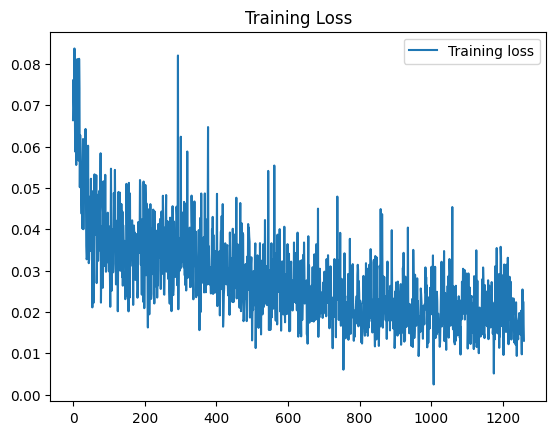

In [ ]:
plt.title('Training Loss')
plt.plot(losses,label = 'Training loss')
plt.legend()
plt.show()

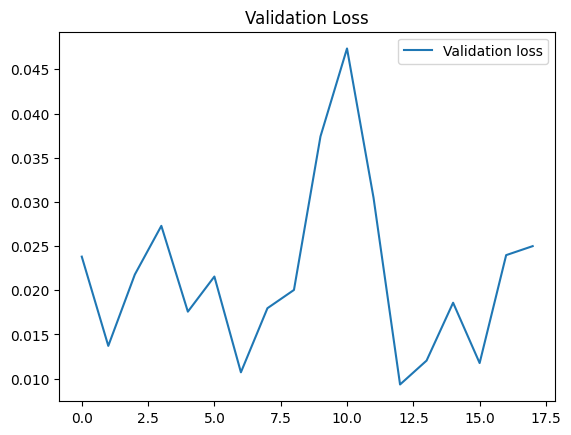

In [ ]:
plt.title('Validation Loss')
plt.plot(val_losses,label = 'Validation loss')
plt.legend()
plt.show()

In [ ]:
y_pred = []
with torch.no_grad():
  for X_batch,y_batch in test_loader:
    y_val = model(X_batch)
    for y_n in y_val:
      y_pred.append(y_n)

In [ ]:
len(y_pred)

564

In [ ]:
y_test[seq_length-1:].shape

torch.Size([564, 2])

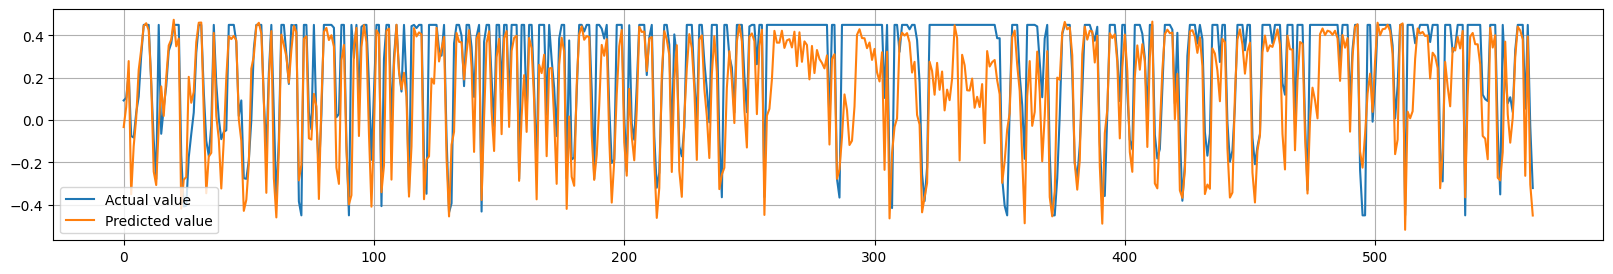

In [ ]:
plt.figure(figsize=(20, 3))
throttle_pwm = []
pred_throttle_pwm = []
for a in y_test[seq_length-1:].detach().numpy():
  throttle_pwm.append(a[0])
for a in y_pred:
  pred_throttle_pwm.append(a[0])
plt.plot(throttle_pwm,label = 'Actual value')
plt.plot(pred_throttle_pwm,label = 'Predicted value')
plt.legend()
plt.grid()
plt.show()

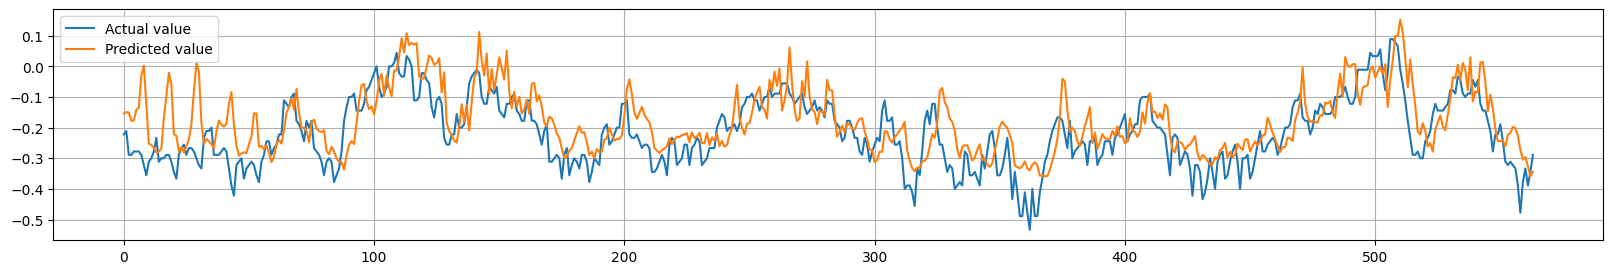

In [ ]:
plt.figure(figsize=(20, 3))
steering_pwm = []
pred_steering_pwm = []
for a in y_test[seq_length-1:].detach().numpy():
  steering_pwm.append(a[1])
for a in y_pred:
  pred_steering_pwm.append(a[1])
plt.plot(steering_pwm,label = 'Actual value')
plt.plot(pred_steering_pwm,label = 'Predicted value')
plt.legend()
plt.grid()
plt.show()

In [ ]:
%%timeit
input_tensor = torch.randn(batch_size, seq_length, input_size).to(device)
y_rand = model(input_tensor)

2 ms ± 150 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
torch.save(model.state_dict(), '/content/pm5_lstm.pth')
model.load_state_dict(torch.load('/content/pm5_lstm.pth'))

<All keys matched successfully>

###Model_5-GRU

In [ ]:
df.head()

curr_accel_x   curr_accel_y   curr_yaw_rate   throttle_pwm   steering_pwm  \
0      0.000000       0.000000        0.000000          -0.45      -0.111111   
1     -0.048281       0.016782       -0.002222          -0.45      -0.111111   
2      0.087396      -0.023934       -0.004435          -0.45      -0.111111   
3      0.095399       0.165994       -0.002357          -0.45      -0.111111   
4      0.006766       0.166401        0.001327          -0.45      -0.111111   

    voltage   next_accel_x   next_accel_y   next_yaw_rate  
0     7.380      -0.048281       0.016782       -0.002222  
1     7.336       0.087396      -0.023934       -0.004435  
2     7.340       0.095399       0.165994       -0.002357  
3     7.364       0.006766       0.166401        0.001327  
4     7.352      -0.000579      -0.061384       -0.002015

In [ ]:
X = np.concatenate((df.iloc[:,:3].values,df.iloc[:,5:].values),axis = 1)
y = df.iloc[:,3:5].values

In [ ]:
ratio = 0.7
total_rows = df.shape[0]
train_size = int(total_rows*ratio)
X_train = X[0:train_size]
X_test = X[train_size:]
y_train = y[0:train_size]
y_test = y[train_size:]

In [ ]:
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)

In [ ]:
from torch.utils.data import Dataset, DataLoader

class SequenceDataset(Dataset):
    def __init__(self, X, y, seq_length):
        self.X = X
        self.y = y
        self.seq_length = seq_length

    def __len__(self):
        return len(self.X) - self.seq_length + 1

    def __getitem__(self, idx):
        return (
            self.X[idx:idx+self.seq_length],
            self.y[idx+self.seq_length-1])

seq_length = 3

train_dataset = SequenceDataset(X_train, y_train, seq_length)
test_dataset = SequenceDataset(X_test, y_test, seq_length)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
!pip install 'ray[tune]'

In [ ]:
import os
import tempfile
from ray import tune
from ray import train
from ray.train import Checkpoint, get_checkpoint
from ray.tune.schedulers import ASHAScheduler

In [ ]:
input_size = X_train.shape[1]
output_size = y_train.shape[1]
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
def train_model(config):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = GRUModel(input_size,config['hidden_size'],config['num_layers'],output_size).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"], weight_decay=1e-5)
    epochs = 30

    train_losses = []
    val_losses = []
    total_loss = 0
    for epoch in range(epochs):
        model.train()
        for batch in train_loader:
            X_batch, y_batch = batch
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            train_losses.append(loss.item())
            loss.backward()
            optimizer.step()

        if epoch % 10 == 0:
            print(f'Epoch: {epoch} Loss: {loss.item()}')

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in test_loader:
                X_batch, y_batch = batch
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_val = model(X_batch)
                val_loss += criterion(y_val, y_batch).item()

        val_loss /= len(test_loader)
        val_losses.append(val_loss)
        total_loss += val_loss
    total_loss /= epochs
    return {"loss": total_loss}

In [ ]:
config = {
    "lr": tune.loguniform(1e-4, 1e-1),
    "num_layers": tune.choice([x for x in range(1,4)]),
    "hidden_size":tune.choice([x for x in range(32,144,16)])
}

# Scheduler for hyperparameter tuning
scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    max_t=30,
    grace_period=1,
    reduction_factor=2
)

# Run the hyperparameter tuning
analysis = tune.run(
    train_model,
    resources_per_trial={"cpu": 1},
    config=config,
    num_samples=10,
    scheduler=scheduler
)

best_config = analysis.get_best_config(metric="loss", mode="min")
print("Best config:", best_config)

+--------------------------------------------------------------------+
| Configuration for experiment     train_model_2024-06-10_05-48-01   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        AsyncHyperBandScheduler           |
| Number of trials                 10                                |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_model_2024-06-10_05-48-01
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-06-10_05-44-26_520228_8153/artifacts/2024-06-10_05-48-01/train_model_2024-06-10_05-48-01/driver_artifacts`

Trial status: 10 PENDING
Current time: 2024-06-10 05:48:01. Total running time: 0s
Logical resource usage: 0/2 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------+
| Trial name 

2024-06-10 05:51:03,586	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_model_2024-06-10_05-48-01' in 0.0190s.



Trial train_model_ffa1d_00009 finished iteration 1 at 2024-06-10 05:51:03. Total running time: 3min 2s
+--------------------------------------------------+
| Trial train_model_ffa1d_00009 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         14.2721 |
| time_total_s                             14.2721 |
| training_iteration                             1 |
| loss                                     0.04096 |
+--------------------------------------------------+

Trial train_model_ffa1d_00009 completed after 1 iterations at 2024-06-10 05:51:03. Total running time: 3min 2s

Trial status: 10 TERMINATED
Current time: 2024-06-10 05:51:03. Total running time: 3min 2s
Logical resource usage: 1.0/2 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------------------------------------------------+
| Trial name                status          

In [ ]:
model = GRUModel(input_size,best_config['hidden_size'],best_config['num_layers'],output_size).to(device)
print(model)

GRUModel(
  (gru): GRU(7, 80, num_layers=2, batch_first=True)
  (fc): Linear(in_features=80, out_features=2, bias=True)
)


In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr = best_config['lr'],weight_decay=1e-5)

In [ ]:
num_epochs = 30
losses = []
for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

Epoch [1/30], Loss: 0.03836703673005104
Epoch [2/30], Loss: 0.042539551854133606
Epoch [3/30], Loss: 0.01930873654782772
Epoch [4/30], Loss: 0.01875474490225315
Epoch [5/30], Loss: 0.02487117610871792
Epoch [6/30], Loss: 0.06492125242948532
Epoch [7/30], Loss: 0.02261023409664631
Epoch [8/30], Loss: 0.04262103512883186
Epoch [9/30], Loss: 0.08639789372682571
Epoch [10/30], Loss: 0.032585810869932175
Epoch [11/30], Loss: 0.015812082216143608
Epoch [12/30], Loss: 0.03983331471681595
Epoch [13/30], Loss: 0.03420155867934227
Epoch [14/30], Loss: 0.020834049209952354
Epoch [15/30], Loss: 0.01418150682002306
Epoch [16/30], Loss: 0.038456786423921585
Epoch [17/30], Loss: 0.02019178308546543
Epoch [18/30], Loss: 0.014607232064008713
Epoch [19/30], Loss: 0.0670548602938652
Epoch [20/30], Loss: 0.02032087929546833
Epoch [21/30], Loss: 0.049784597009420395
Epoch [22/30], Loss: 0.016210023313760757
Epoch [23/30], Loss: 0.018421776592731476
Epoch [24/30], Loss: 0.03879715874791145
Epoch [25/30], Lo

In [ ]:
val_losses = []
model.eval()
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        output = model(batch_X)
        loss = criterion(output, batch_y)
        val_losses.append(loss.item())

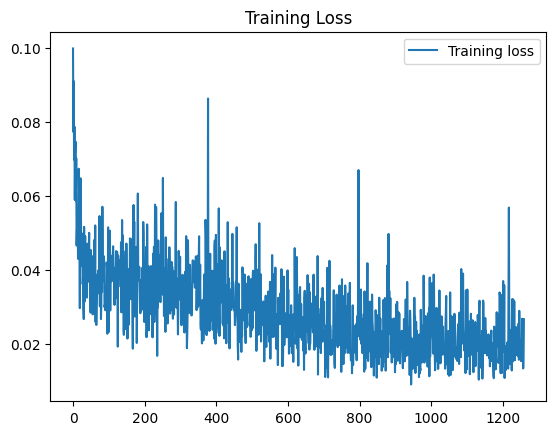

In [ ]:
plt.title('Training Loss')
plt.plot(losses,label = 'Training loss')
plt.legend()
plt.show()

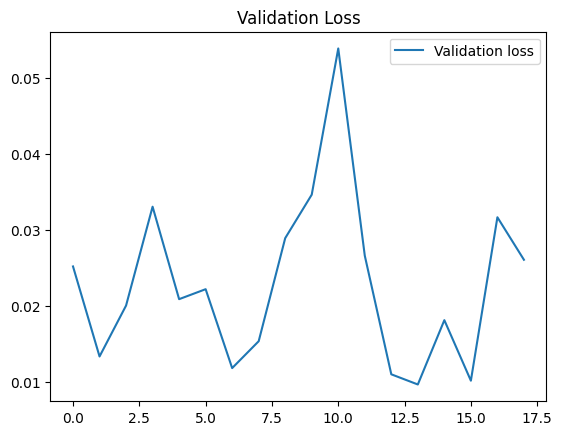

In [ ]:
plt.title('Validation Loss')
plt.plot(val_losses,label = 'Validation loss')
plt.legend()
plt.show()

In [ ]:
y_pred = []
with torch.no_grad():
  for X_batch,y_batch in test_loader:
    y_val = model(X_batch)
    for y_n in y_val:
      y_pred.append(y_n)

In [ ]:
len(y_pred)

564

In [ ]:
y_test[seq_length-1:].shape

torch.Size([564, 2])

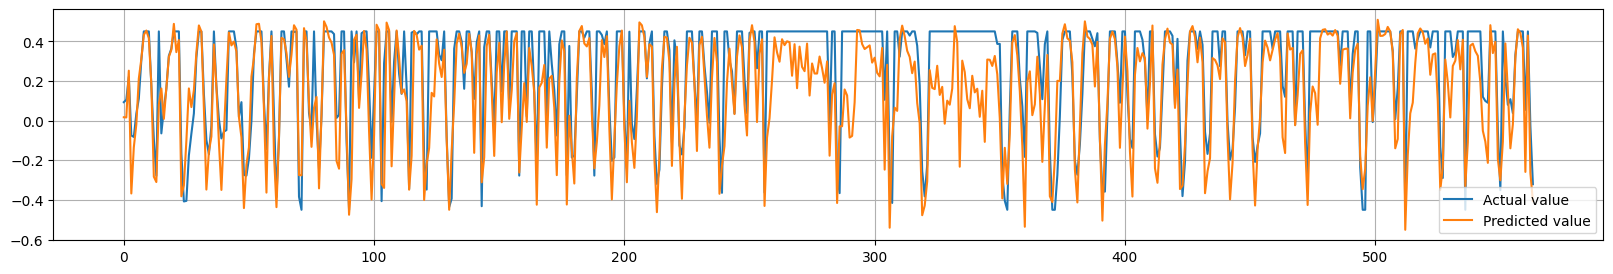

In [ ]:
plt.figure(figsize=(20, 3))
throttle_pwm = []
pred_throttle_pwm = []
for a in y_test[seq_length-1:].detach().numpy():
  throttle_pwm.append(a[0])
for a in y_pred:
  pred_throttle_pwm.append(a[0])
plt.plot(throttle_pwm,label = 'Actual value')
plt.plot(pred_throttle_pwm,label = 'Predicted value')
plt.legend()
plt.grid()
plt.show()

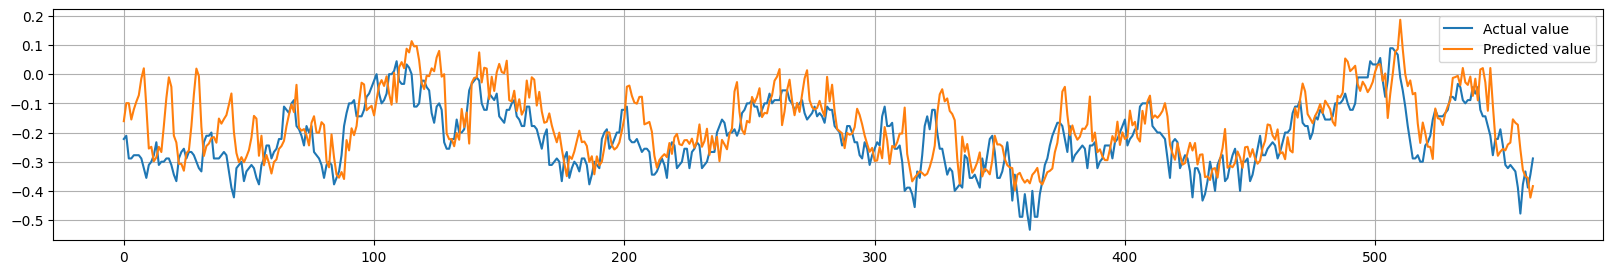

In [ ]:
plt.figure(figsize=(20, 3))
steering_pwm = []
pred_steering_pwm = []
for a in y_test[seq_length-1:].detach().numpy():
  steering_pwm.append(a[1])
for a in y_pred:
  pred_steering_pwm.append(a[1])
plt.plot(steering_pwm,label = 'Actual value')
plt.plot(pred_steering_pwm,label = 'Predicted value')
plt.legend()
plt.grid()
plt.show()

In [ ]:
%%timeit
input_tensor = torch.randn(batch_size, seq_length, input_size).to(device)
y_rand = model(input_tensor)

2.54 ms ± 228 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
torch.save(model.state_dict(), '/content/pm5_gru.pth')
model.load_state_dict(torch.load('/content/pm5_gru.pth'))

<All keys matched successfully>

###Model_6

In [ ]:
import pandas as pd
df = pd.read_csv('/content/modified_jetracer.csv')
df.head()

prev_accel_x   prev_accel_y   prev_yaw_rate   throttle_pwm   steering_pwm  \
0      0.000000       0.000000        0.000000       -0.45000      -0.166667   
1      0.114652      -0.077011       -0.037715       -0.39300      -0.188889   
2      0.037951      -0.098411       -0.005601       -0.38525      -0.188889   
3      0.052028       0.073443       -0.001722       -0.38375      -0.166667   
4     -0.055235      -0.057152        0.000370       -0.37450      -0.166667   

    voltage   curr_accel_x   curr_accel_y   curr_yaw_rate  
0     7.624       0.114652      -0.077011       -0.037715  
1     7.648       0.037951      -0.098411       -0.005601  
2     7.656       0.052028       0.073443       -0.001722  
3     7.656      -0.055235      -0.057152        0.000370  
4     7.656       0.110110       0.075720        0.002598

In [ ]:
import numpy as np
X = np.concatenate((df.iloc[:,:3].values,df.iloc[:,5:].values),axis = 1)
y = df.iloc[:,3:5].values

In [ ]:
ratio = 0.8
total_rows = df.shape[0]
train_size = int(total_rows*ratio)
X_train = X[0:train_size]
X_test = X[train_size:]
y_train = y[0:train_size]
y_test = y[train_size:]

In [ ]:
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)

In [ ]:
!pip install 'ray[tune]'

In [ ]:
X_train.shape

torch.Size([5395, 7])

In [ ]:
y_train.shape

torch.Size([5395, 2])

In [ ]:
import os
import tempfile
from ray import tune
from ray import train
from ray.train import Checkpoint, get_checkpoint
from ray.tune.schedulers import ASHAScheduler

In [ ]:
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
class NeuralNetwork(nn.Module):
  def __init__(self,layer_1,layer_2,layer_3,dropout_rate,activation):
    super(NeuralNetwork,self).__init__()
    self.activation = activation
    self.relu_nn_model = nn.Sequential(
        nn.Linear(input_dim,layer_1),
        nn.ReLU(),
        nn.Linear(layer_1,layer_2),
        nn.ReLU(),
        nn.Dropout(p = dropout_rate),
        nn.Linear(layer_2,layer_3),
        nn.ReLU(),
        nn.Linear(layer_3,output_dim)
    )
    self.leaky_relu_nn_model = nn.Sequential(
        nn.Linear(input_dim,layer_1),
        nn.LeakyReLU(),
        nn.Linear(layer_1,layer_2),
        nn.LeakyReLU(),
        nn.Dropout(p = dropout_rate),
        nn.Linear(layer_2,layer_3),
        nn.LeakyReLU(),
        nn.Linear(layer_3,output_dim)
    )
    self.tanh_nn_model = nn.Sequential(
        nn.Linear(input_dim,layer_1),
        nn.Tanh(),
        nn.Linear(layer_1,layer_2),
        nn.Tanh(),
        nn.Dropout(p = dropout_rate),
        nn.Linear(layer_2,layer_3),
        nn.Tanh(),
        nn.Linear(layer_3,output_dim)
    )
  def forward(self,x):
    if self.activation == 'relu':
      y = self.relu_nn_model(x)
      return y
    if self.activation == 'leaky_relu':
      y = self.leaky_relu_nn_model(x)
      return y
    if self.activation == 'tanh':
      y = self.tanh_nn_model(x)
      return y

In [ ]:
def train_model(config):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = NeuralNetwork(config['layer_1'], config['layer_2'], config['layer_3'],config['dropout_rate'],config['activation']).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"], weight_decay=1e-5)
    epochs = config['epochs']

    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

    test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

    train_losses = []
    val_losses = []
    total_loss = 0

    for epoch in range(epochs):
        model.train()
        for batch in train_loader:
            X_batch, y_batch = batch
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            train_losses.append(loss.item())
            loss.backward()
            optimizer.step()

        if epoch % 10 == 0:
            print(f'Epoch: {epoch} Loss: {loss.item()}')

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in test_loader:
                X_batch, y_batch = batch
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_val = model(X_batch)
                val_loss += criterion(y_val, y_batch).item()

        val_loss /= len(test_loader)
        val_losses.append(val_loss)
        total_loss += val_loss
    total_loss /= epochs
    return {"loss": total_loss}


In [ ]:
config = {
    "lr": tune.loguniform(1e-4, 1e-1),
    "layer_1": tune.choice([x for x in range(32,144,8)]),
    "layer_2": tune.choice([x for x in range(32,144,8)]),
    "layer_3": tune.choice([x for x in range(32,144,8)]),
    "dropout_rate":tune.choice([0.1*x for x in range(1,4)]),
    "activation":tune.choice(['relu','leaky_relu','tanh']),
    "epochs":tune.choice([32,64,128,256])
}

# Scheduler for hyperparameter tuning
scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    max_t=30,
    grace_period=1,
    reduction_factor=2
)

# Run the hyperparameter tuning
analysis = tune.run(
    train_model,
    resources_per_trial={"cpu": 1},
    config=config,
    num_samples=10,
    scheduler=scheduler
)

best_config = analysis.get_best_config(metric="loss", mode="min")
print("Best config:", best_config)

+--------------------------------------------------------------------+
| Configuration for experiment     train_model_2024-06-13_08-18-48   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        AsyncHyperBandScheduler           |
| Number of trials                 10                                |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_model_2024-06-13_08-18-48
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-06-13_05-42-17_106598_218/artifacts/2024-06-13_08-18-48/train_model_2024-06-13_08-18-48/driver_artifacts`

Trial status: 10 PENDING
Current time: 2024-06-13 08:18:49. Total running time: 0s
Logical resource usage: 0/2 CPUs, 0/0 GPUs
+-------------------------------------------------------------------------------------------------

2024-06-13 08:33:14,713	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_model_2024-06-13_08-18-48' in 0.0122s.



Trial train_model_8f96e_00008 finished iteration 1 at 2024-06-13 08:33:14. Total running time: 14min 25s
+--------------------------------------------------+
| Trial train_model_8f96e_00008 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         192.158 |
| time_total_s                             192.158 |
| training_iteration                             1 |
| loss                                      0.0791 |
+--------------------------------------------------+

Trial train_model_8f96e_00008 completed after 1 iterations at 2024-06-13 08:33:14. Total running time: 14min 25s

Trial status: 10 TERMINATED
Current time: 2024-06-13 08:33:14. Total running time: 14min 25s
Logical resource usage: 1.0/2 CPUs, 0/0 GPUs
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
model = NeuralNetwork(best_config['layer_1'],best_config['layer_2'],best_config['layer_3'],best_config['dropout_rate'],best_config['activation']).to(device)
print(model)

NeuralNetwork(
  (relu_nn_model): Sequential(
    (0): Linear(in_features=7, out_features=48, bias=True)
    (1): ReLU()
    (2): Linear(in_features=48, out_features=128, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.1, inplace=False)
    (5): Linear(in_features=128, out_features=120, bias=True)
    (6): ReLU()
    (7): Linear(in_features=120, out_features=2, bias=True)
  )
  (leaky_relu_nn_model): Sequential(
    (0): Linear(in_features=7, out_features=48, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=48, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Dropout(p=0.1, inplace=False)
    (5): Linear(in_features=128, out_features=120, bias=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Linear(in_features=120, out_features=2, bias=True)
  )
  (tanh_nn_model): Sequential(
    (0): Linear(in_features=7, out_features=48, bias=True)
    (1): Tanh()
    (2): Linear(in_features=48, out_features=128, bias=True)
    (3): Tan

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr = best_config['lr'],weight_decay=1e-5)

In [ ]:
epochs = best_config['epochs']
losses = []
for i in range(epochs):
  y_pred = model.forward(X_train)
  loss = criterion(y_pred,y_train)
  losses.append(loss.detach().numpy())
  print(f'Epoch : {i} and Loss: {loss}')
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

Epoch : 0 and Loss: 0.0691402330994606
Epoch : 1 and Loss: 0.06630390137434006
Epoch : 2 and Loss: 0.0649615004658699
Epoch : 3 and Loss: 0.06291402876377106
Epoch : 4 and Loss: 0.06132124736905098
Epoch : 5 and Loss: 0.059611525386571884
Epoch : 6 and Loss: 0.05828894302248955
Epoch : 7 and Loss: 0.05688149482011795
Epoch : 8 and Loss: 0.05552910640835762
Epoch : 9 and Loss: 0.054625872522592545
Epoch : 10 and Loss: 0.05348485708236694
Epoch : 11 and Loss: 0.051990341395139694
Epoch : 12 and Loss: 0.0508582703769207
Epoch : 13 and Loss: 0.050025761127471924
Epoch : 14 and Loss: 0.049142707139253616
Epoch : 15 and Loss: 0.0482146292924881
Epoch : 16 and Loss: 0.04717785120010376
Epoch : 17 and Loss: 0.04643680155277252
Epoch : 18 and Loss: 0.04576478153467178
Epoch : 19 and Loss: 0.044985413551330566
Epoch : 20 and Loss: 0.044446490705013275
Epoch : 21 and Loss: 0.043979957699775696
Epoch : 22 and Loss: 0.0439319871366024
Epoch : 23 and Loss: 0.043406445533037186
Epoch : 24 and Loss: 0

In [ ]:
val_losses = []
with torch.no_grad():
  for i,data in enumerate(X_test):
    y_val = model(data)
    loss = criterion(y_val,y_test)
    val_losses.append(loss.detach().numpy())
    if i%10 == 0:
      print(f'{i+1}.Loss : {loss}')

1.Loss : 0.10566217452287674
11.Loss : 0.10267942398786545
21.Loss : 0.14098632335662842
31.Loss : 0.17185305058956146
41.Loss : 0.15101252496242523
51.Loss : 0.07510150969028473
61.Loss : 0.12387870252132416
71.Loss : 0.17515075206756592
81.Loss : 0.0882827416062355
91.Loss : 0.11676301062107086
101.Loss : 0.0776432529091835
111.Loss : 0.08704834431409836
121.Loss : 0.09689097851514816
131.Loss : 0.08563370257616043
141.Loss : 0.08898705989122391
151.Loss : 0.14648185670375824
161.Loss : 0.1321893185377121
171.Loss : 0.08046620339155197
181.Loss : 0.1454329937696457
191.Loss : 0.07628576457500458
201.Loss : 0.12432418763637543
211.Loss : 0.11525244265794754
221.Loss : 0.14295966923236847
231.Loss : 0.08250086009502411
241.Loss : 0.07723607867956161
251.Loss : 0.10750880092382431
261.Loss : 0.08944465965032578
271.Loss : 0.09547872096300125
281.Loss : 0.12035440653562546
291.Loss : 0.08728203177452087
301.Loss : 0.09133031219244003
311.Loss : 0.1260959357023239
321.Loss : 0.12626096606

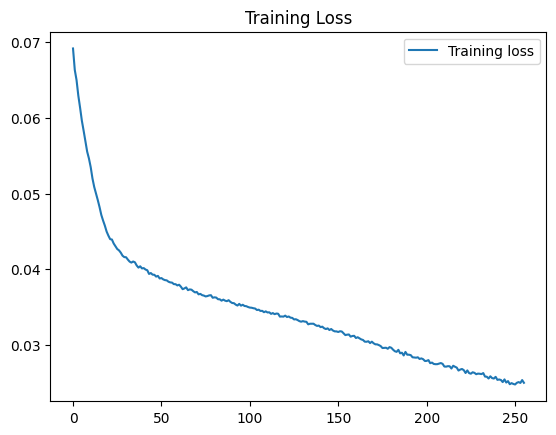

In [ ]:
plt.title('Training Loss')
plt.plot(losses,label = 'Training loss')
plt.legend()
plt.show()

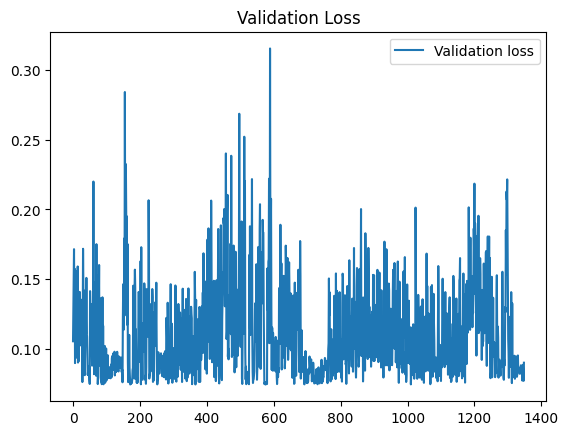

In [ ]:
plt.title('Validation Loss')
plt.plot(val_losses,label = 'Validation loss')
plt.legend()
plt.show()

In [ ]:
y_pred = []
with torch.no_grad():
  for i,data in enumerate(X_test):
    y_val = model(data)
    y_pred.append(y_val)

In [ ]:
y_test.detach().numpy()

array([[ 0.45      ,  0.3888889 ],
       [ 0.12924993,  0.35555556],
       [-0.1375001 ,  0.31111112],
       ...,
       [-0.45      , -0.31111112],
       [-0.45      , -0.31111112],
       [-0.45      , -0.3       ]], dtype=float32)

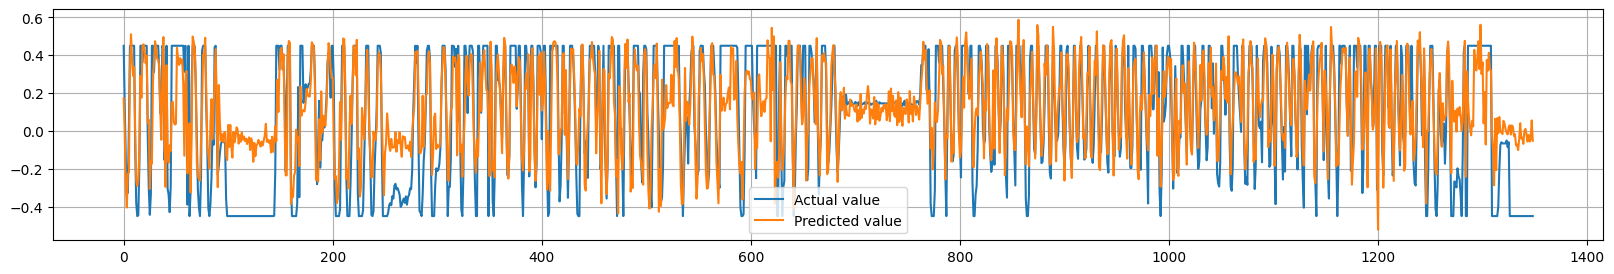

In [ ]:
plt.figure(figsize=(20, 3))
throttle_pwm = []
pred_throttle_pwm = []
for a in y_test.detach().numpy():
  throttle_pwm.append(a[0])
for a in y_pred:
  pred_throttle_pwm.append(a[0])
plt.plot(throttle_pwm,label = 'Actual value')
plt.plot(pred_throttle_pwm,label = 'Predicted value')
plt.legend()
plt.grid()
plt.show()

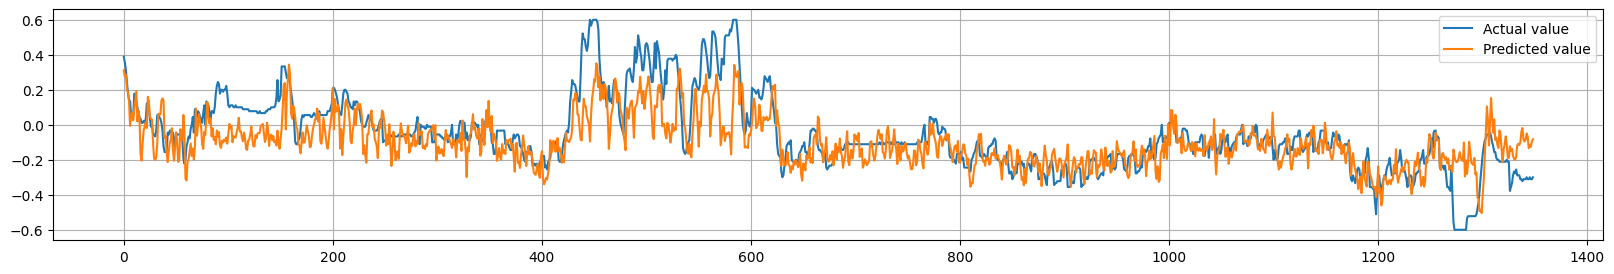

In [ ]:
plt.figure(figsize=(20, 3))
steering_pwm = []
pred_steering_pwm = []
for a in y_test.detach().numpy():
  steering_pwm.append(a[1])
for a in y_pred:
  pred_steering_pwm.append(a[1])
plt.plot(steering_pwm,label = 'Actual value')
plt.plot(pred_steering_pwm,label = 'Predicted value')
plt.legend()
plt.grid()
plt.show()

In [ ]:
%%timeit
y_rand = model(torch.randn(1,7))

222 µs ± 45.5 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
torch.save(model.state_dict(), '/content/pm6.pth')
model.load_state_dict(torch.load('/content/pm6.pth'))

<All keys matched successfully>

###Model_7-DNN

In [ ]:
import pandas as pd
df = pd.read_csv('/content/modified_jetracer.csv')
df.head()

prev_accel_x   prev_accel_y   prev_yaw_rate   throttle_pwm   steering_pwm  \
0      0.000000       0.000000        0.000000       -0.45000      -0.166667   
1      0.114652      -0.077011       -0.037715       -0.39300      -0.188889   
2      0.037951      -0.098411       -0.005601       -0.38525      -0.188889   
3      0.052028       0.073443       -0.001722       -0.38375      -0.166667   
4     -0.055235      -0.057152        0.000370       -0.37450      -0.166667   

    voltage   curr_accel_x   curr_accel_y   curr_yaw_rate  
0     7.624       0.114652      -0.077011       -0.037715  
1     7.648       0.037951      -0.098411       -0.005601  
2     7.656       0.052028       0.073443       -0.001722  
3     7.656      -0.055235      -0.057152        0.000370  
4     7.656       0.110110       0.075720        0.002598

In [ ]:
import numpy as np
curr_accel =  np.array([np.linalg.norm(x) * ((x[0] * x[1]) / (abs(x[0]) * abs(x[1]))) if np.linalg.norm(x) != 0 else np.linalg.norm(x) for x in df.iloc[:, 6:8].values]).reshape(-1,1)
prev_accel =  np.array([np.linalg.norm(x) * ((x[0] * x[1]) / (abs(x[0]) * abs(x[1]))) if np.linalg.norm(x) != 0 else np.linalg.norm(x) for x in df.iloc[:, 6:8].values]).reshape(-1,1)
X = np.concatenate((curr_accel,prev_accel,df[' prev_yaw_rate'].values.reshape(-1,1),df[' curr_yaw_rate'].values.reshape(-1,1),df[' voltage'].values.reshape(-1,1)),axis = 1)
y = df.iloc[:,3:5].values

In [ ]:
ratio = 0.8
total_rows = df.shape[0]
train_size = int(total_rows*ratio)
X_train = X[0:train_size]
X_test = X[train_size:]
y_train = y[0:train_size]
y_test = y[train_size:]

In [ ]:
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)

In [ ]:
X_train.shape

torch.Size([5395, 5])

In [ ]:
y_train.shape

torch.Size([5395, 2])

In [ ]:
!pip install 'ray[tune]'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.9/65.9 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 13.4 MB/s eta 0:00:00


In [ ]:
import os
import tempfile
from ray import tune
from ray import train
from ray.train import Checkpoint, get_checkpoint
from ray.tune.schedulers import ASHAScheduler

In [ ]:
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
class NeuralNetwork(nn.Module):
  def __init__(self,layer_1,layer_2,layer_3,dropout_rate,activation):
    super(NeuralNetwork,self).__init__()
    self.activation = activation
    self.relu_nn_model = nn.Sequential(
        nn.Linear(input_dim,layer_1),
        nn.ReLU(),
        nn.Linear(layer_1,layer_2),
        nn.ReLU(),
        nn.Dropout(p = dropout_rate),
        nn.Linear(layer_2,layer_3),
        nn.ReLU(),
        nn.Linear(layer_3,output_dim)
    )
    self.leaky_relu_nn_model = nn.Sequential(
        nn.Linear(input_dim,layer_1),
        nn.LeakyReLU(),
        nn.Linear(layer_1,layer_2),
        nn.LeakyReLU(),
        nn.Dropout(p = dropout_rate),
        nn.Linear(layer_2,layer_3),
        nn.LeakyReLU(),
        nn.Linear(layer_3,output_dim)
    )
    self.tanh_nn_model = nn.Sequential(
        nn.Linear(input_dim,layer_1),
        nn.Tanh(),
        nn.Linear(layer_1,layer_2),
        nn.Tanh(),
        nn.Dropout(p = dropout_rate),
        nn.Linear(layer_2,layer_3),
        nn.Tanh(),
        nn.Linear(layer_3,output_dim)
    )
  def forward(self,x):
    if self.activation == 'relu':
      y = self.relu_nn_model(x)
      return y
    if self.activation == 'leaky_relu':
      y = self.leaky_relu_nn_model(x)
      return y
    if self.activation == 'tanh':
      y = self.tanh_nn_model(x)
      return y

In [ ]:
def train_model(config):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = NeuralNetwork(config['layer_1'], config['layer_2'], config['layer_3'],config['dropout_rate'],config['activation']).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"], weight_decay=1e-5)
    epochs = config['epochs']

    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

    test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

    train_losses = []
    val_losses = []
    total_loss = 0

    for epoch in range(epochs):
        model.train()
        for batch in train_loader:
            X_batch, y_batch = batch
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            train_losses.append(loss.item())
            loss.backward()
            optimizer.step()

        if epoch % 10 == 0:
            print(f'Epoch: {epoch} Loss: {loss.item()}')

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in test_loader:
                X_batch, y_batch = batch
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_val = model(X_batch)
                val_loss += criterion(y_val, y_batch).item()

        val_loss /= len(test_loader)
        val_losses.append(val_loss)
        total_loss += val_loss
    total_loss /= epochs
    return {"loss": total_loss}


In [ ]:
config = {
    "lr": tune.loguniform(1e-4, 1e-1),
    "layer_1": tune.choice([x for x in range(32,144,8)]),
    "layer_2": tune.choice([x for x in range(32,144,8)]),
    "layer_3": tune.choice([x for x in range(32,144,8)]),
    "dropout_rate":tune.choice([0.1*x for x in range(1,4)]),
    "activation":tune.choice(['relu','leaky_relu','tanh']),
    "epochs":tune.choice([32,64,128,256])
}

# Scheduler for hyperparameter tuning
scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    max_t=30,
    grace_period=1,
    reduction_factor=2
)

# Run the hyperparameter tuning
analysis = tune.run(
    train_model,
    resources_per_trial={"cpu": 1},
    config=config,
    num_samples=10,
    scheduler=scheduler
)

best_config = analysis.get_best_config(metric="loss", mode="min")
print("Best config:", best_config)

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-06-17 07:13:33,357	INFO worker.py:1753 -- Started a local Ray instance.
2024-06-17 07:13:36,676	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.


+--------------------------------------------------------------------+
| Configuration for experiment     train_model_2024-06-17_07-13-36   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        AsyncHyperBandScheduler           |
| Number of trials                 10                                |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_model_2024-06-17_07-13-36
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-06-17_07-13-27_541409_689/artifacts/2024-06-17_07-13-36/train_model_2024-06-17_07-13-36/driver_artifacts`

Trial status: 10 PENDING
Current time: 2024-06-17 07:13:38. Total running time: 1s
Logical resource usage: 0/2 CPUs, 0/0 GPUs
+-------------------------------------------------------------------------------------------------

2024-06-17 07:22:16,207	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_model_2024-06-17_07-13-36' in 0.0099s.



Trial train_model_1d6f0_00007 finished iteration 1 at 2024-06-17 07:22:16. Total running time: 8min 38s
+-------------------------------------------------+
| Trial train_model_1d6f0_00007 result            |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                         181.25 |
| time_total_s                             181.25 |
| training_iteration                            1 |
| loss                                      0.077 |
+-------------------------------------------------+

Trial train_model_1d6f0_00007 completed after 1 iterations at 2024-06-17 07:22:16. Total running time: 8min 38s

Trial status: 10 TERMINATED
Current time: 2024-06-17 07:22:16. Total running time: 8min 38s
Logical resource usage: 1.0/2 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| 

In [ ]:
model = NeuralNetwork(best_config['layer_1'],best_config['layer_2'],best_config['layer_3'],best_config['dropout_rate'],best_config['activation']).to(device)
print(model)

NeuralNetwork(
  (relu_nn_model): Sequential(
    (0): Linear(in_features=5, out_features=40, bias=True)
    (1): ReLU()
    (2): Linear(in_features=40, out_features=72, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.2, inplace=False)
    (5): Linear(in_features=72, out_features=80, bias=True)
    (6): ReLU()
    (7): Linear(in_features=80, out_features=2, bias=True)
  )
  (leaky_relu_nn_model): Sequential(
    (0): Linear(in_features=5, out_features=40, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=40, out_features=72, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Dropout(p=0.2, inplace=False)
    (5): Linear(in_features=72, out_features=80, bias=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Linear(in_features=80, out_features=2, bias=True)
  )
  (tanh_nn_model): Sequential(
    (0): Linear(in_features=5, out_features=40, bias=True)
    (1): Tanh()
    (2): Linear(in_features=40, out_features=72, bias=True)
    (3): Tanh()
    (

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr = best_config['lr'],weight_decay=1e-5)

In [ ]:
epochs = best_config['epochs']
losses = []
for i in range(epochs):
  y_pred = model.forward(X_train)
  loss = criterion(y_pred,y_train)
  losses.append(loss.detach().numpy())
  print(f'Epoch : {i} and Loss: {loss}')
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

Epoch : 0 and Loss: 0.07400885224342346
Epoch : 1 and Loss: 0.06874297559261322
Epoch : 2 and Loss: 0.0704621970653534
Epoch : 3 and Loss: 0.06805327534675598
Epoch : 4 and Loss: 0.06553172320127487
Epoch : 5 and Loss: 0.06536798924207687
Epoch : 6 and Loss: 0.06513182818889618
Epoch : 7 and Loss: 0.06436354666948318
Epoch : 8 and Loss: 0.06329865753650665
Epoch : 9 and Loss: 0.06309234350919724
Epoch : 10 and Loss: 0.062310751527547836
Epoch : 11 and Loss: 0.06212686374783516
Epoch : 12 and Loss: 0.061592549085617065
Epoch : 13 and Loss: 0.06145871803164482
Epoch : 14 and Loss: 0.06094412878155708
Epoch : 15 and Loss: 0.061138685792684555
Epoch : 16 and Loss: 0.0606653206050396
Epoch : 17 and Loss: 0.05964731052517891
Epoch : 18 and Loss: 0.05984322354197502
Epoch : 19 and Loss: 0.059466179460287094
Epoch : 20 and Loss: 0.05956970155239105
Epoch : 21 and Loss: 0.059061113744974136
Epoch : 22 and Loss: 0.05865040794014931
Epoch : 23 and Loss: 0.05826038122177124
Epoch : 24 and Loss: 0.

In [ ]:
val_losses = []
with torch.no_grad():
  for i,data in enumerate(X_test):
    y_val = model(data)
    loss = criterion(y_val,y_test)
    val_losses.append(loss.detach().numpy())
    if i%10 == 0:
      print(f'{i+1}.Loss : {loss}')

1.Loss : 0.11108405143022537
11.Loss : 0.08371931314468384
21.Loss : 0.07865061610937119
31.Loss : 0.08323066681623459
41.Loss : 0.08765272051095963
51.Loss : 0.08380956202745438
61.Loss : 0.1089557632803917
71.Loss : 0.0945233479142189
81.Loss : 0.09020231664180756
91.Loss : 0.10140864551067352
101.Loss : 0.08059722930192947
111.Loss : 0.08865725249052048
121.Loss : 0.09357351064682007
131.Loss : 0.07908009737730026
141.Loss : 0.08350212126970291
151.Loss : 0.0767982006072998
161.Loss : 0.1701899766921997
171.Loss : 0.07846692949533463
181.Loss : 0.0793243870139122
191.Loss : 0.0885101929306984
201.Loss : 0.08121714740991592
211.Loss : 0.07492980360984802
221.Loss : 0.08657988160848618
231.Loss : 0.07643774896860123
241.Loss : 0.08391282707452774
251.Loss : 0.09736106544733047
261.Loss : 0.08064769953489304
271.Loss : 0.08190307766199112
281.Loss : 0.08252206444740295
291.Loss : 0.07960474491119385

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1349, 2])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



301.Loss : 0.08539009839296341
311.Loss : 0.10328184813261032
321.Loss : 0.08818992227315903
331.Loss : 0.0774458572268486
341.Loss : 0.07861681282520294
351.Loss : 0.08925747126340866
361.Loss : 0.07908577471971512
371.Loss : 0.07847268879413605
381.Loss : 0.07591110467910767
391.Loss : 0.09993118792772293
401.Loss : 0.09405174851417542
411.Loss : 0.08727636933326721
421.Loss : 0.09540032595396042
431.Loss : 0.07879914343357086
441.Loss : 0.09259588271379471
451.Loss : 0.1321975290775299
461.Loss : 0.22542360424995422
471.Loss : 0.13316793739795685
481.Loss : 0.08837604522705078
491.Loss : 0.08311495184898376
501.Loss : 0.10705575346946716
511.Loss : 0.12290168553590775
521.Loss : 0.07831084728240967
531.Loss : 0.1704753041267395
541.Loss : 0.08271884173154831
551.Loss : 0.07849272340536118
561.Loss : 0.11965134739875793
571.Loss : 0.09483911097049713
581.Loss : 0.08211135864257812
591.Loss : 0.3918198347091675
601.Loss : 0.07770936191082001
611.Loss : 0.08198780566453934
621.Loss : 

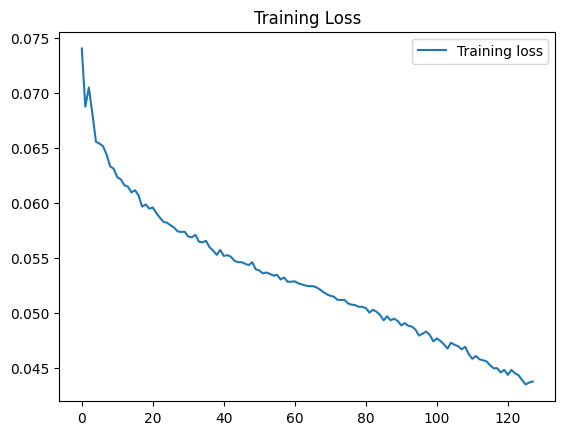

In [ ]:
plt.title('Training Loss')
plt.plot(losses,label = 'Training loss')
plt.legend()
plt.show()

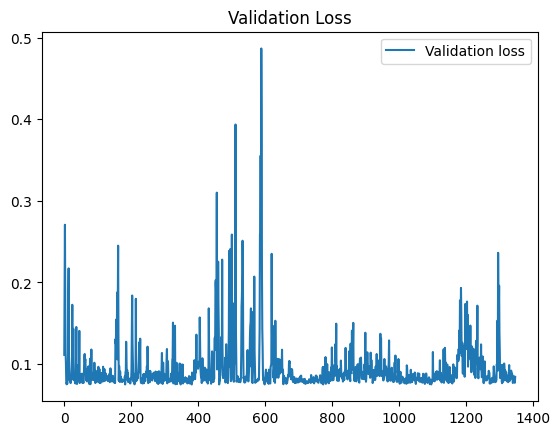

In [ ]:
plt.title('Validation Loss')
plt.plot(val_losses,label = 'Validation loss')
plt.legend()
plt.show()

In [ ]:
y_pred = []
with torch.no_grad():
  for i,data in enumerate(X_test):
    y_val = model(data)
    y_pred.append(y_val)

In [ ]:
y_test.detach().numpy()

array([[ 0.45      ,  0.3888889 ],
       [ 0.12924993,  0.35555556],
       [-0.1375001 ,  0.31111112],
       ...,
       [-0.45      , -0.31111112],
       [-0.45      , -0.31111112],
       [-0.45      , -0.3       ]], dtype=float32)

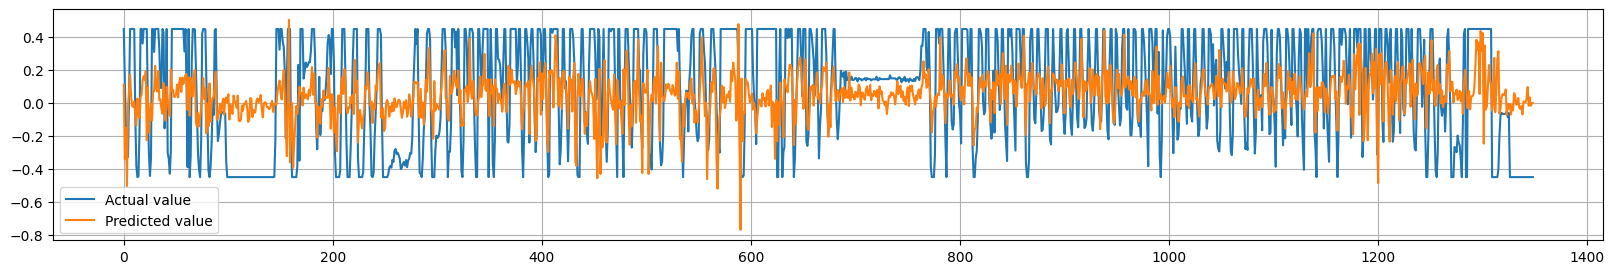

In [ ]:
plt.figure(figsize=(20, 3))
throttle_pwm = []
pred_throttle_pwm = []
for a in y_test.detach().numpy():
  throttle_pwm.append(a[0])
for a in y_pred:
  pred_throttle_pwm.append(a[0])
plt.plot(throttle_pwm,label = 'Actual value')
plt.plot(pred_throttle_pwm,label = 'Predicted value')
plt.legend()
plt.grid()
plt.show()

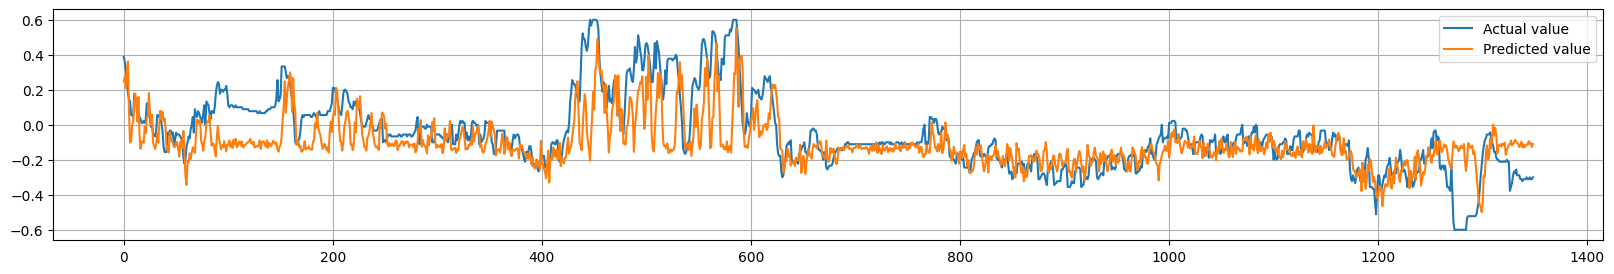

In [ ]:
plt.figure(figsize=(20, 3))
steering_pwm = []
pred_steering_pwm = []
for a in y_test.detach().numpy():
  steering_pwm.append(a[1])
for a in y_pred:
  pred_steering_pwm.append(a[1])
plt.plot(steering_pwm,label = 'Actual value')
plt.plot(pred_steering_pwm,label = 'Predicted value')
plt.legend()
plt.grid()
plt.show()

In [ ]:
%%timeit
y_rand = model(torch.randn(1,5))

254 µs ± 76.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
torch.save(model.state_dict(), '/content/pm7.pth')
model.load_state_dict(torch.load('/content/pm7.pth'))

<All keys matched successfully>

###Model_7 - LSTM

In [ ]:
df.head()

prev_accel_x   prev_accel_y   prev_yaw_rate   throttle_pwm   steering_pwm  \
0      0.000000       0.000000        0.000000       -0.45000      -0.166667   
1      0.114652      -0.077011       -0.037715       -0.39300      -0.188889   
2      0.037951      -0.098411       -0.005601       -0.38525      -0.188889   
3      0.052028       0.073443       -0.001722       -0.38375      -0.166667   
4     -0.055235      -0.057152        0.000370       -0.37450      -0.166667   

    voltage   curr_accel_x   curr_accel_y   curr_yaw_rate  
0     7.624       0.114652      -0.077011       -0.037715  
1     7.648       0.037951      -0.098411       -0.005601  
2     7.656       0.052028       0.073443       -0.001722  
3     7.656      -0.055235      -0.057152        0.000370  
4     7.656       0.110110       0.075720        0.002598

In [ ]:
import numpy as np
curr_accel =  np.array([np.linalg.norm(x) * ((x[0] * x[1]) / (abs(x[0]) * abs(x[1]))) if np.linalg.norm(x) != 0 else np.linalg.norm(x) for x in df.iloc[:, 6:8].values]).reshape(-1,1)
prev_accel =  np.array([np.linalg.norm(x) * ((x[0] * x[1]) / (abs(x[0]) * abs(x[1]))) if np.linalg.norm(x) != 0 else np.linalg.norm(x) for x in df.iloc[:, 6:8].values]).reshape(-1,1)
X = np.concatenate((curr_accel,prev_accel,df[' prev_yaw_rate'].values.reshape(-1,1),df[' curr_yaw_rate'].values.reshape(-1,1),df[' voltage'].values.reshape(-1,1)),axis = 1)
y = df.iloc[:,3:5].values

In [ ]:
ratio = 0.8
total_rows = df.shape[0]
train_size = int(total_rows*ratio)
X_train = X[0:train_size]
X_test = X[train_size:]
y_train = y[0:train_size]
y_test = y[train_size:]

In [ ]:
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)

In [ ]:
from torch.utils.data import Dataset, DataLoader

class SequenceDataset(Dataset):
    def __init__(self, X, y, seq_length):
        self.X = X
        self.y = y
        self.seq_length = seq_length

    def __len__(self):
        return len(self.X) - self.seq_length + 1

    def __getitem__(self, idx):
        return (
            self.X[idx:idx+self.seq_length],
            self.y[idx+self.seq_length-1])

seq_length = 3

train_dataset = SequenceDataset(X_train, y_train, seq_length)
test_dataset = SequenceDataset(X_test, y_test, seq_length)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
!pip install 'ray[tune]'

In [ ]:
import os
import tempfile
from ray import tune
from ray import train
from ray.train import Checkpoint, get_checkpoint
from ray.tune.schedulers import ASHAScheduler

In [ ]:
input_size = X_train.shape[1]
output_size = y_train.shape[1]
class LSTMModel(nn.Module):
    def __init__(self,hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
def train_model(config):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = LSTMModel(config['hidden_size'],config['num_layers']).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"], weight_decay=1e-5)
    epochs = config['epochs']

    train_losses = []
    val_losses = []
    total_loss = 0
    for epoch in range(epochs):
        model.train()
        for batch in train_loader:
            X_batch, y_batch = batch
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            train_losses.append(loss.item())
            loss.backward()
            optimizer.step()

        if epoch % 10 == 0:
            print(f'Epoch: {epoch} Loss: {loss.item()}')

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in test_loader:
                X_batch, y_batch = batch
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_val = model(X_batch)
                val_loss += criterion(y_val, y_batch).item()

        val_loss /= len(test_loader)
        val_losses.append(val_loss)
        total_loss += val_loss
    total_loss /= epochs
    return {"loss": total_loss}

In [ ]:
config = {
    "lr": tune.loguniform(1e-4, 1e-1),
    "num_layers": tune.choice([x for x in range(1,4)]),
    "hidden_size":tune.choice([x for x in range(32,144,16)]),
    "epochs":tune.choice([32,64,128,256])
}

# Scheduler for hyperparameter tuning
scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    max_t=30,
    grace_period=1,
    reduction_factor=2
)

# Run the hyperparameter tuning
analysis = tune.run(
    train_model,
    resources_per_trial={"cpu": 1},
    config=config,
    num_samples=10,
    scheduler=scheduler
)

best_config = analysis.get_best_config(metric="loss", mode="min")
print("Best config:", best_config)

+--------------------------------------------------------------------+
| Configuration for experiment     train_model_2024-06-17_07-23-52   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        AsyncHyperBandScheduler           |
| Number of trials                 10                                |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_model_2024-06-17_07-23-52
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-06-17_07-13-27_541409_689/artifacts/2024-06-17_07-23-52/train_model_2024-06-17_07-23-52/driver_artifacts`

Trial status: 10 PENDING
Current time: 2024-06-17 07:23:53. Total running time: 0s
Logical resource usage: 0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------+
| T

2024-06-17 07:52:33,139	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_model_2024-06-17_07-23-52' in 0.0146s.



Trial train_model_8c980_00007 finished iteration 1 at 2024-06-17 07:52:33. Total running time: 28min 40s
+--------------------------------------------------+
| Trial train_model_8c980_00007 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         746.956 |
| time_total_s                             746.956 |
| training_iteration                             1 |
| loss                                     0.03699 |
+--------------------------------------------------+

Trial train_model_8c980_00007 completed after 1 iterations at 2024-06-17 07:52:33. Total running time: 28min 40s

Trial status: 10 TERMINATED
Current time: 2024-06-17 07:52:33. Total running time: 28min 40s
Logical resource usage: 1.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               

In [ ]:
model = LSTMModel(best_config['hidden_size'],best_config['num_layers']).to(device)
print(model)

LSTMModel(
  (lstm): LSTM(5, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)


In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr = best_config['lr'],weight_decay=1e-5)

In [ ]:
num_epochs = best_config['epochs']
losses = []
for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

Epoch [1/64], Loss: 0.05323219299316406
Epoch [2/64], Loss: 0.04342138022184372
Epoch [3/64], Loss: 0.03443175181746483
Epoch [4/64], Loss: 0.02908511832356453
Epoch [5/64], Loss: 0.018329648301005363
Epoch [6/64], Loss: 0.021395929157733917
Epoch [7/64], Loss: 0.0274459570646286
Epoch [8/64], Loss: 0.02652694843709469
Epoch [9/64], Loss: 0.024095064029097557
Epoch [10/64], Loss: 0.03915432095527649
Epoch [11/64], Loss: 0.018742870539426804
Epoch [12/64], Loss: 0.015104953199625015
Epoch [13/64], Loss: 0.013636032119393349
Epoch [14/64], Loss: 0.037936341017484665
Epoch [15/64], Loss: 0.022960485890507698
Epoch [16/64], Loss: 0.03477600961923599
Epoch [17/64], Loss: 0.034304581582546234
Epoch [18/64], Loss: 0.020691391080617905
Epoch [19/64], Loss: 0.018361771479249
Epoch [20/64], Loss: 0.020324110984802246
Epoch [21/64], Loss: 0.02196958288550377
Epoch [22/64], Loss: 0.02078752964735031
Epoch [23/64], Loss: 0.03429005667567253
Epoch [24/64], Loss: 0.029456106945872307
Epoch [25/64], L

In [ ]:
val_losses = []
model.eval()
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        output = model(batch_X)
        loss = criterion(output, batch_y)
        val_losses.append(loss.item())

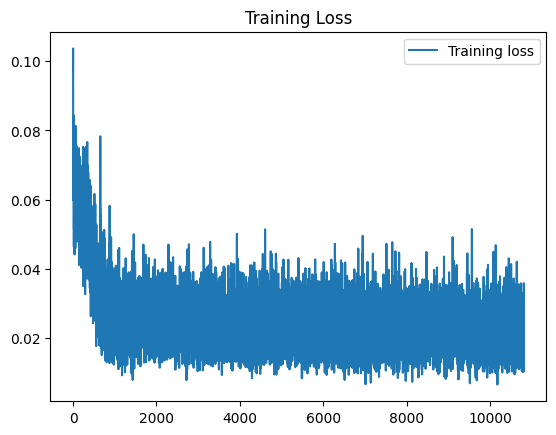

In [ ]:
plt.title('Training Loss')
plt.plot(losses,label = 'Training loss')
plt.legend()
plt.show()

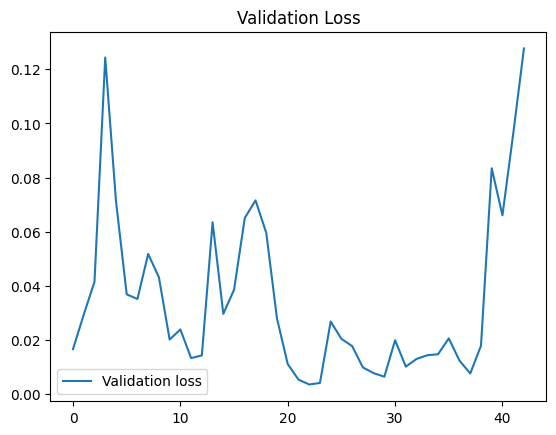

In [ ]:
plt.title('Validation Loss')
plt.plot(val_losses,label = 'Validation loss')
plt.legend()
plt.show()

In [ ]:
y_pred = []
with torch.no_grad():
  for X_batch,y_batch in test_loader:
    y_val = model(X_batch)
    for y_n in y_val:
      y_pred.append(y_n)

In [ ]:
len(y_pred)

1347

In [ ]:
y_test[seq_length-1:].shape

torch.Size([1347, 2])

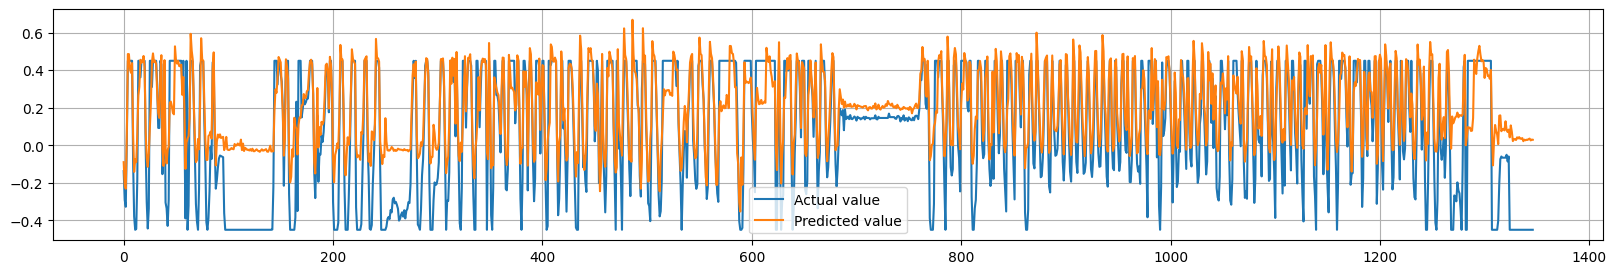

In [ ]:
plt.figure(figsize=(20, 3))
throttle_pwm = []
pred_throttle_pwm = []
for a in y_test[seq_length-1:].detach().numpy():
  throttle_pwm.append(a[0])
for a in y_pred:
  pred_throttle_pwm.append(a[0])
plt.plot(throttle_pwm,label = 'Actual value')
plt.plot(pred_throttle_pwm,label = 'Predicted value')
plt.legend()
plt.grid()
plt.show()

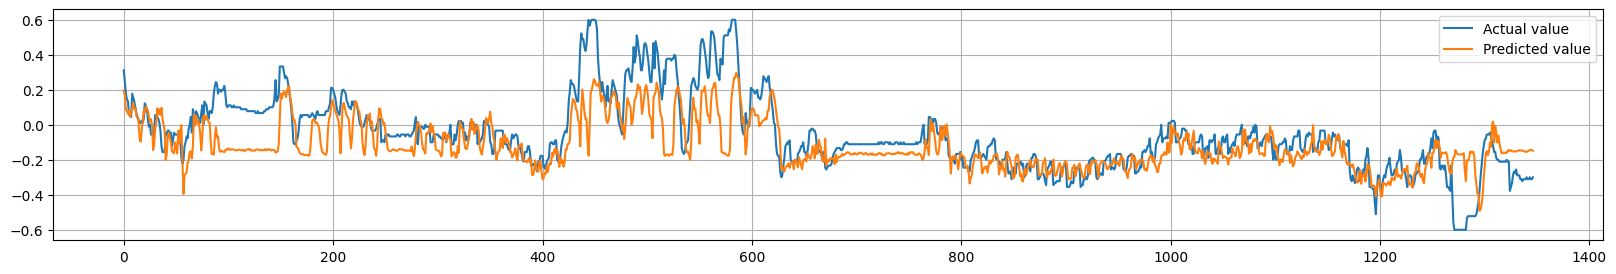

In [ ]:
plt.figure(figsize=(20, 3))
steering_pwm = []
pred_steering_pwm = []
for a in y_test[seq_length-1:].detach().numpy():
  steering_pwm.append(a[1])
for a in y_pred:
  pred_steering_pwm.append(a[1])
plt.plot(steering_pwm,label = 'Actual value')
plt.plot(pred_steering_pwm,label = 'Predicted value')
plt.legend()
plt.grid()
plt.show()

In [ ]:
%%timeit
input_tensor = torch.randn(batch_size, seq_length, input_size).to(device)
y_rand = model(input_tensor)

1.4 ms ± 248 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
torch.save(model.state_dict(), '/content/pm7_lstm.pth')
model.load_state_dict(torch.load('/content/pm7_lstm.pth'))

<All keys matched successfully>

###Model_7-GRU

In [ ]:
df.head()

prev_accel_x   prev_accel_y   prev_yaw_rate   throttle_pwm   steering_pwm  \
0      0.000000       0.000000        0.000000       -0.45000      -0.166667   
1      0.114652      -0.077011       -0.037715       -0.39300      -0.188889   
2      0.037951      -0.098411       -0.005601       -0.38525      -0.188889   
3      0.052028       0.073443       -0.001722       -0.38375      -0.166667   
4     -0.055235      -0.057152        0.000370       -0.37450      -0.166667   

    voltage   curr_accel_x   curr_accel_y   curr_yaw_rate  
0     7.624       0.114652      -0.077011       -0.037715  
1     7.648       0.037951      -0.098411       -0.005601  
2     7.656       0.052028       0.073443       -0.001722  
3     7.656      -0.055235      -0.057152        0.000370  
4     7.656       0.110110       0.075720        0.002598

In [ ]:
import numpy as np
curr_accel =  np.array([np.linalg.norm(x) * ((x[0] * x[1]) / (abs(x[0]) * abs(x[1]))) if np.linalg.norm(x) != 0 else np.linalg.norm(x) for x in df.iloc[:, 6:8].values]).reshape(-1,1)
prev_accel =  np.array([np.linalg.norm(x) * ((x[0] * x[1]) / (abs(x[0]) * abs(x[1]))) if np.linalg.norm(x) != 0 else np.linalg.norm(x) for x in df.iloc[:, 6:8].values]).reshape(-1,1)
X = np.concatenate((curr_accel,prev_accel,df[' prev_yaw_rate'].values.reshape(-1,1),df[' curr_yaw_rate'].values.reshape(-1,1),df[' voltage'].values.reshape(-1,1)),axis = 1)
y = df.iloc[:,3:5].values

In [ ]:
ratio = 0.8
total_rows = df.shape[0]
train_size = int(total_rows*ratio)
X_train = X[0:train_size]
X_test = X[train_size:]
y_train = y[0:train_size]
y_test = y[train_size:]

In [ ]:
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)

In [ ]:
X_train.shape

torch.Size([5395, 5])

In [ ]:
y_train.shape

torch.Size([5395, 2])

In [ ]:
from torch.utils.data import Dataset, DataLoader

class SequenceDataset(Dataset):
    def __init__(self, X, y, seq_length):
        self.X = X
        self.y = y
        self.seq_length = seq_length

    def __len__(self):
        return len(self.X) - self.seq_length + 1

    def __getitem__(self, idx):
        return (
            self.X[idx:idx+self.seq_length],
            self.y[idx+self.seq_length-1])

seq_length = 3

train_dataset = SequenceDataset(X_train, y_train, seq_length)
test_dataset = SequenceDataset(X_test, y_test, seq_length)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
!pip install 'ray[tune]'

In [ ]:
import os
import tempfile
from ray import tune
from ray import train
from ray.train import Checkpoint, get_checkpoint
from ray.tune.schedulers import ASHAScheduler

In [ ]:
input_size = X_train.shape[1]
output_size = y_train.shape[1]
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
def train_model(config):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = GRUModel(input_size,config['hidden_size'],config['num_layers'],output_size).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"], weight_decay=1e-5)
    epochs = config['epochs']

    train_losses = []
    val_losses = []
    total_loss = 0
    for epoch in range(epochs):
        model.train()
        for batch in train_loader:
            X_batch, y_batch = batch
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            train_losses.append(loss.item())
            loss.backward()
            optimizer.step()

        if epoch % 10 == 0:
            print(f'Epoch: {epoch} Loss: {loss.item()}')

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in test_loader:
                X_batch, y_batch = batch
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_val = model(X_batch)
                val_loss += criterion(y_val, y_batch).item()

        val_loss /= len(test_loader)
        val_losses.append(val_loss)
        total_loss += val_loss
    total_loss /= epochs
    return {"loss": total_loss}

In [ ]:
config = {
    "lr": tune.loguniform(1e-4, 1e-1),
    "num_layers": tune.choice([x for x in range(1,4)]),
    "hidden_size":tune.choice([x for x in range(32,144,16)]),
    "epochs":tune.choice([32,64,128,256])
}

# Scheduler for hyperparameter tuning
scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    max_t=30,
    grace_period=1,
    reduction_factor=2
)

# Run the hyperparameter tuning
analysis = tune.run(
    train_model,
    resources_per_trial={"cpu": 1},
    config=config,
    num_samples=10,
    scheduler=scheduler
)

best_config = analysis.get_best_config(metric="loss", mode="min")
print("Best config:", best_config)

+--------------------------------------------------------------------+
| Configuration for experiment     train_model_2024-06-17_07-56-10   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        AsyncHyperBandScheduler           |
| Number of trials                 10                                |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_model_2024-06-17_07-56-10
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-06-17_07-13-27_541409_689/artifacts/2024-06-17_07-56-10/train_model_2024-06-17_07-56-10/driver_artifacts`

Trial status: 10 PENDING
Current time: 2024-06-17 07:56:10. Total running time: 0s
Logical resource usage: 0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------+
| T

2024-06-17 08:15:51,127	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_model_2024-06-17_07-56-10' in 0.0095s.



Trial train_model_0f51f_00009 finished iteration 1 at 2024-06-17 08:15:51. Total running time: 19min 40s
+--------------------------------------------------+
| Trial train_model_0f51f_00009 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         253.449 |
| time_total_s                             253.449 |
| training_iteration                             1 |
| loss                                     0.03915 |
+--------------------------------------------------+

Trial train_model_0f51f_00009 completed after 1 iterations at 2024-06-17 08:15:51. Total running time: 19min 40s

Trial status: 10 TERMINATED
Current time: 2024-06-17 08:15:51. Total running time: 19min 40s
Logical resource usage: 1.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               

In [ ]:
model = GRUModel(input_size,best_config['hidden_size'],best_config['num_layers'],output_size).to(device)
print(model)

GRUModel(
  (gru): GRU(5, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)


In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr = best_config['lr'],weight_decay=1e-5)

In [ ]:
num_epochs = best_config['epochs']
losses = []
for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

Epoch [1/256], Loss: 0.057523615658283234
Epoch [2/256], Loss: 0.06453247368335724
Epoch [3/256], Loss: 0.061563849449157715
Epoch [4/256], Loss: 0.026880614459514618
Epoch [5/256], Loss: 0.020812295377254486
Epoch [6/256], Loss: 0.020127881318330765
Epoch [7/256], Loss: 0.023751376196742058
Epoch [8/256], Loss: 0.021621698513627052
Epoch [9/256], Loss: 0.025245144963264465
Epoch [10/256], Loss: 0.02828587219119072
Epoch [11/256], Loss: 0.020400604233145714
Epoch [12/256], Loss: 0.02574513666331768
Epoch [13/256], Loss: 0.032497260719537735
Epoch [14/256], Loss: 0.02263462357223034
Epoch [15/256], Loss: 0.0167654138058424
Epoch [16/256], Loss: 0.021591559052467346
Epoch [17/256], Loss: 0.01914338767528534
Epoch [18/256], Loss: 0.01492222398519516
Epoch [19/256], Loss: 0.011799512431025505
Epoch [20/256], Loss: 0.012202206067740917
Epoch [21/256], Loss: 0.015244434587657452
Epoch [22/256], Loss: 0.023579727858304977
Epoch [23/256], Loss: 0.04270990565419197
Epoch [24/256], Loss: 0.02614

In [ ]:
val_losses = []
model.eval()
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        output = model(batch_X)
        loss = criterion(output, batch_y)
        val_losses.append(loss.item())

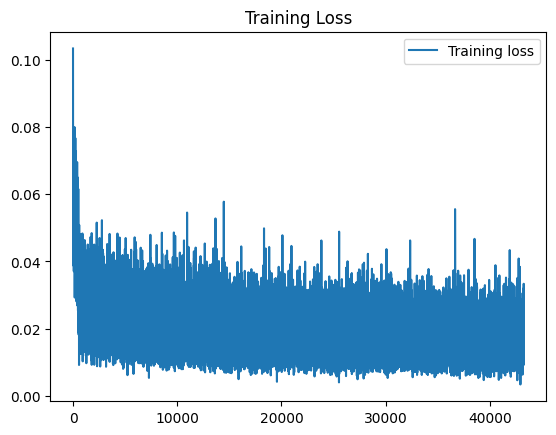

In [ ]:
plt.title('Training Loss')
plt.plot(losses,label = 'Training loss')
plt.legend()
plt.show()

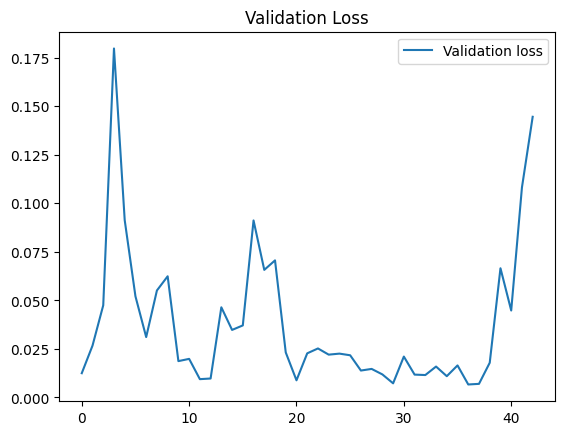

In [ ]:
plt.title('Validation Loss')
plt.plot(val_losses,label = 'Validation loss')
plt.legend()
plt.show()

In [ ]:
y_pred = []
with torch.no_grad():
  for X_batch,y_batch in test_loader:
    y_val = model(X_batch)
    for y_n in y_val:
      y_pred.append(y_n)

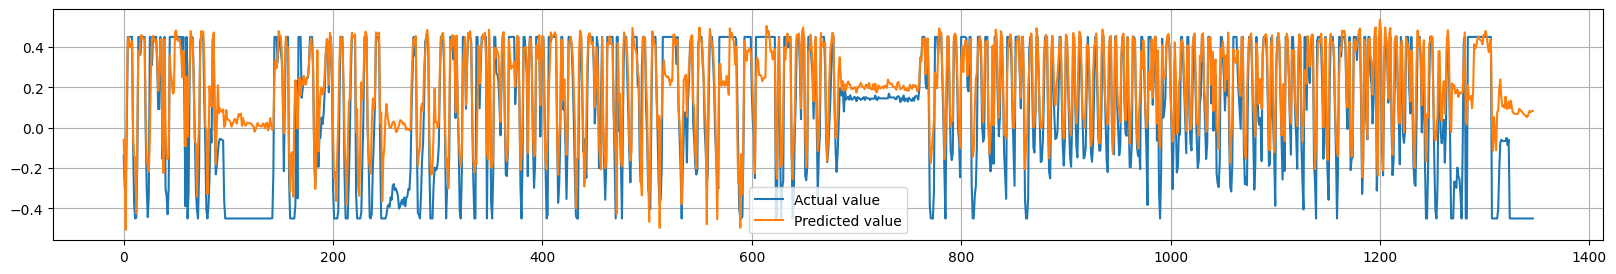

In [ ]:
plt.figure(figsize=(20, 3))
throttle_pwm = []
pred_throttle_pwm = []
for a in y_test[seq_length-1:].detach().numpy():
  throttle_pwm.append(a[0])
for a in y_pred:
  pred_throttle_pwm.append(a[0])
plt.plot(throttle_pwm,label = 'Actual value')
plt.plot(pred_throttle_pwm,label = 'Predicted value')
plt.legend()
plt.grid()
plt.show()

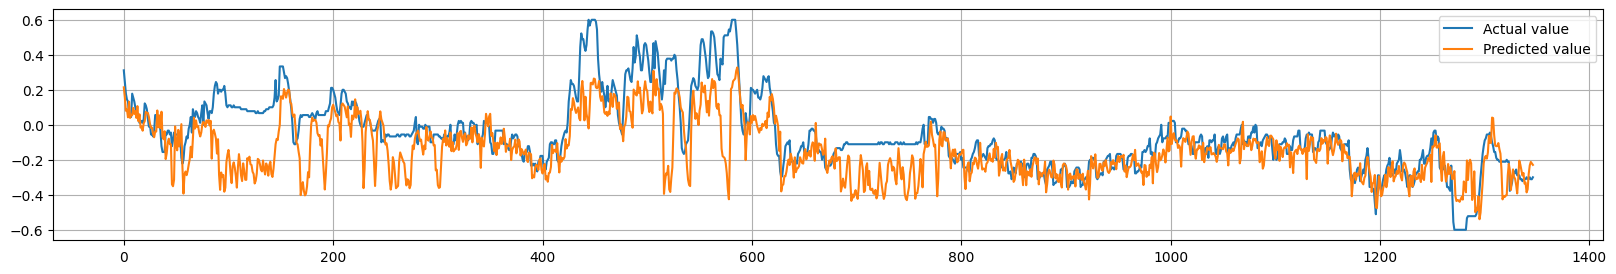

In [ ]:
plt.figure(figsize=(20, 3))
steering_pwm = []
pred_steering_pwm = []
for a in y_test[seq_length-1:].detach().numpy():
  steering_pwm.append(a[1])
for a in y_pred:
  pred_steering_pwm.append(a[1])
plt.plot(steering_pwm,label = 'Actual value')
plt.plot(pred_steering_pwm,label = 'Predicted value')
plt.legend()
plt.grid()
plt.show()

In [ ]:
%%timeit
input_tensor = torch.randn(batch_size, seq_length, input_size).to(device)
y_rand = model(input_tensor)

1.6 ms ± 347 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
torch.save(model.state_dict(), '/content/pm7_gru.pth')
model.load_state_dict(torch.load('/content/pm7_gru.pth'))

<All keys matched successfully>

### Model_8

In [ ]:
import pandas as pd
df = pd.read_csv('/content/modified_jetracer.csv')
df.head()

prev_accel_x   prev_accel_y   prev_yaw_rate   throttle_pwm   steering_pwm  \
0      0.000000       0.000000        0.000000       -0.45000      -0.166667   
1      0.114652      -0.077011       -0.037715       -0.39300      -0.188889   
2      0.037951      -0.098411       -0.005601       -0.38525      -0.188889   
3      0.052028       0.073443       -0.001722       -0.38375      -0.166667   
4     -0.055235      -0.057152        0.000370       -0.37450      -0.166667   

    voltage   curr_accel_x   curr_accel_y   curr_yaw_rate  
0     7.624       0.114652      -0.077011       -0.037715  
1     7.648       0.037951      -0.098411       -0.005601  
2     7.656       0.052028       0.073443       -0.001722  
3     7.656      -0.055235      -0.057152        0.000370  
4     7.656       0.110110       0.075720        0.002598

In [ ]:
dt = 0.2
prev_vel_x = [0]
prev_vel_y = [0]
yaw = [0]
for prev_accel_x in df['prev_accel_x'].values:
  prev_vel = prev_vel_x[-1] + prev_accel_x*dt
  prev_vel_x.append(prev_vel)
for prev_accel_y in df[' prev_accel_y'].values:
  prev_vel = prev_vel_y[-1] + prev_accel_y*dt
  prev_vel_y.append(prev_vel)
vel = np.sqrt(np.add(np.square(prev_vel_x),np.square(prev_vel_y))).reshape(-1,1)
for yaw_rate in df[' prev_yaw_rate'].values:
  next_yaw = yaw[-1] + yaw_rate*dt
  yaw.append(next_yaw)
yaw = np.array(yaw).reshape(-1,1)
X = np.concatenate((vel[:-2],yaw[:-2],df.iloc[:-1,:6].values),axis = 1)
y = np.concatenate((vel[1:-1],yaw[1:-1],df.iloc[1:,:3].values,df.iloc[1:,5:6].values),axis = 1)

In [ ]:
ratio = 0.8
total_rows = df.shape[0]
train_size = int(total_rows*ratio)
X_train = X[0:train_size]
X_test = X[train_size:]
y_train = y[0:train_size]
y_test = y[train_size:]

In [ ]:
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)

In [ ]:
!pip install 'ray[tune]'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.9/65.9 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 10.1 MB/s eta 0:00:00


In [ ]:
import os
import tempfile
from ray import tune
from ray import train
from ray.train import Checkpoint, get_checkpoint
from ray.tune.schedulers import ASHAScheduler

In [ ]:
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
class NeuralNetwork(nn.Module):
  def __init__(self,layer_1,layer_2,layer_3,dropout_rate,activation):
    super(NeuralNetwork,self).__init__()
    self.activation = activation
    self.relu_nn_model = nn.Sequential(
        nn.Linear(input_dim,layer_1),
        nn.ReLU(),
        nn.Linear(layer_1,layer_2),
        nn.ReLU(),
        nn.Dropout(p = dropout_rate),
        nn.Linear(layer_2,layer_3),
        nn.ReLU(),
        nn.Linear(layer_3,output_dim)
    )
    self.leaky_relu_nn_model = nn.Sequential(
        nn.Linear(input_dim,layer_1),
        nn.LeakyReLU(),
        nn.Linear(layer_1,layer_2),
        nn.LeakyReLU(),
        nn.Dropout(p = dropout_rate),
        nn.Linear(layer_2,layer_3),
        nn.LeakyReLU(),
        nn.Linear(layer_3,output_dim)
    )
    self.tanh_nn_model = nn.Sequential(
        nn.Linear(input_dim,layer_1),
        nn.Tanh(),
        nn.Linear(layer_1,layer_2),
        nn.Tanh(),
        nn.Dropout(p = dropout_rate),
        nn.Linear(layer_2,layer_3),
        nn.Tanh(),
        nn.Linear(layer_3,output_dim)
    )
  def forward(self,x):
    if self.activation == 'relu':
      y = self.relu_nn_model(x)
      return y
    if self.activation == 'leaky_relu':
      y = self.leaky_relu_nn_model(x)
      return y
    if self.activation == 'tanh':
      y = self.tanh_nn_model(x)
      return y

In [ ]:
def train_model(config):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = NeuralNetwork(config['layer_1'], config['layer_2'], config['layer_3'],config['dropout_rate'],config['activation']).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"], weight_decay=1e-5)
    epochs = config['epochs']

    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

    test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

    train_losses = []
    val_losses = []
    total_loss = 0

    for epoch in range(epochs):
        model.train()
        for batch in train_loader:
            X_batch, y_batch = batch
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            train_losses.append(loss.item())
            loss.backward()
            optimizer.step()

        if epoch % 10 == 0:
            print(f'Epoch: {epoch} Loss: {loss.item()}')

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in test_loader:
                X_batch, y_batch = batch
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_val = model(X_batch)
                val_loss += criterion(y_val, y_batch).item()

        val_loss /= len(test_loader)
        val_losses.append(val_loss)
        total_loss += val_loss
    total_loss /= epochs
    return {"loss": total_loss}


In [ ]:
config = {
    "lr": tune.loguniform(1e-4, 1e-1),
    "layer_1": tune.choice([x for x in range(32,144,8)]),
    "layer_2": tune.choice([x for x in range(32,144,8)]),
    "layer_3": tune.choice([x for x in range(32,144,8)]),
    "dropout_rate":tune.choice([0.1*x for x in range(1,4)]),
    "activation":tune.choice(['relu','leaky_relu','tanh']),
    "epochs":tune.choice([32,64,128,256])
}

# Scheduler for hyperparameter tuning
scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    max_t=30,
    grace_period=1,
    reduction_factor=2
)

# Run the hyperparameter tuning
analysis = tune.run(
    train_model,
    resources_per_trial={"cpu": 1},
    config=config,
    num_samples=10,
    scheduler=scheduler
)

best_config = analysis.get_best_config(metric="loss", mode="min")
print("Best config:", best_config)

+--------------------------------------------------------------------+
| Configuration for experiment     train_model_2024-06-20_12-10-26   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        AsyncHyperBandScheduler           |
| Number of trials                 10                                |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_model_2024-06-20_12-10-26
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-06-20_11-50-46_618736_361/artifacts/2024-06-20_12-10-26/train_model_2024-06-20_12-10-26/driver_artifacts`

Trial status: 10 PENDING
Current time: 2024-06-20 12:10:26. Total running time: 0s
Logical resource usage: 0/2 CPUs, 0/0 GPUs
+-------------------------------------------------------------------------------------------------

2024-06-20 12:22:57,945	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_model_2024-06-20_12-10-26' in 0.0097s.



Trial train_model_13f0a_00009 finished iteration 1 at 2024-06-20 12:22:57. Total running time: 12min 31s
+--------------------------------------------------+
| Trial train_model_13f0a_00009 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         171.769 |
| time_total_s                             171.769 |
| training_iteration                             1 |
| loss                                      262.09 |
+--------------------------------------------------+

Trial train_model_13f0a_00009 completed after 1 iterations at 2024-06-20 12:22:57. Total running time: 12min 31s

Trial status: 10 TERMINATED
Current time: 2024-06-20 12:22:57. Total running time: 12min 31s
Logical resource usage: 1.0/2 CPUs, 0/0 GPUs
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
model = NeuralNetwork(best_config['layer_1'],best_config['layer_2'],best_config['layer_3'],best_config['dropout_rate'],best_config['activation']).to(device)
print(model)

NeuralNetwork(
  (relu_nn_model): Sequential(
    (0): Linear(in_features=8, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=40, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.1, inplace=False)
    (5): Linear(in_features=40, out_features=80, bias=True)
    (6): ReLU()
    (7): Linear(in_features=80, out_features=6, bias=True)
  )
  (leaky_relu_nn_model): Sequential(
    (0): Linear(in_features=8, out_features=120, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=120, out_features=40, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Dropout(p=0.1, inplace=False)
    (5): Linear(in_features=40, out_features=80, bias=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Linear(in_features=80, out_features=6, bias=True)
  )
  (tanh_nn_model): Sequential(
    (0): Linear(in_features=8, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=40, bias=True)
    (3): Tanh()

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr = best_config['lr'],weight_decay=1e-5)

In [ ]:
epochs = best_config['epochs']
losses = []
for i in range(epochs):
  y_pred = model.forward(X_train)
  loss = criterion(y_pred,y_train)
  losses.append(loss.detach().numpy())
  print(f'Epoch : {i} and Loss: {loss}')
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

Epoch : 0 and Loss: 685.7440795898438
Epoch : 1 and Loss: 651.1446533203125
Epoch : 2 and Loss: 618.6460571289062
Epoch : 3 and Loss: 578.4307861328125
Epoch : 4 and Loss: 528.6577758789062
Epoch : 5 and Loss: 466.97576904296875
Epoch : 6 and Loss: 399.9432067871094
Epoch : 7 and Loss: 325.2804260253906
Epoch : 8 and Loss: 248.59152221679688
Epoch : 9 and Loss: 173.17893981933594
Epoch : 10 and Loss: 108.80565643310547
Epoch : 11 and Loss: 67.94490051269531
Epoch : 12 and Loss: 61.20960235595703
Epoch : 13 and Loss: 88.18294525146484
Epoch : 14 and Loss: 120.16971588134766
Epoch : 15 and Loss: 127.2370834350586
Epoch : 16 and Loss: 112.7903060913086
Epoch : 17 and Loss: 85.1926040649414
Epoch : 18 and Loss: 60.20591354370117
Epoch : 19 and Loss: 43.7347297668457
Epoch : 20 and Loss: 37.56508255004883
Epoch : 21 and Loss: 38.081825256347656
Epoch : 22 and Loss: 41.952945709228516
Epoch : 23 and Loss: 45.45206069946289
Epoch : 24 and Loss: 48.83500671386719
Epoch : 25 and Loss: 47.038772

In [ ]:
val_losses = []
with torch.no_grad():
  for i,data in enumerate(X_test):
    y_val = model(data)
    loss = criterion(y_val,y_test)
    val_losses.append(loss.detach().numpy())
    if i%10 == 0:
      print(f'{i+1}.Loss : {loss}')

1.Loss : 99.23627471923828
11.Loss : 87.02569580078125
21.Loss : 25.7232723236084
31.Loss : 43.216312408447266
41.Loss : 50.44416809082031
51.Loss : 26.081653594970703
61.Loss : 14.290107727050781
71.Loss : 51.600284576416016
81.Loss : 38.55211639404297
91.Loss : 16.273073196411133
101.Loss : 64.76998901367188
111.Loss : 85.29651641845703
121.Loss : 32.04118347167969
131.Loss : 14.634908676147461
141.Loss : 61.82765197753906
151.Loss : 21.858680725097656
161.Loss : 23.516860961914062


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1348, 6])) that is different to the input size (torch.Size([6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


171.Loss : 22.053327560424805
181.Loss : 37.70677947998047
191.Loss : 66.0082015991211
201.Loss : 16.084903717041016
211.Loss : 30.063383102416992
221.Loss : 13.286970138549805
231.Loss : 29.65347671508789
241.Loss : 33.687313079833984
251.Loss : 12.949478149414062
261.Loss : 28.248605728149414
271.Loss : 49.53319549560547
281.Loss : 34.03341293334961
291.Loss : 20.155994415283203
301.Loss : 14.312068939208984
311.Loss : 50.40657043457031
321.Loss : 49.91908264160156
331.Loss : 29.123767852783203
341.Loss : 48.11830139160156
351.Loss : 70.46207427978516
361.Loss : 47.898277282714844
371.Loss : 94.93522644042969
381.Loss : 49.35356903076172
391.Loss : 17.768840789794922
401.Loss : 22.704660415649414
411.Loss : 61.09945297241211
421.Loss : 64.1073226928711
431.Loss : 28.412641525268555
441.Loss : 38.02717208862305
451.Loss : 56.741668701171875
461.Loss : 15.433835983276367
471.Loss : 21.441452026367188
481.Loss : 36.08524703979492
491.Loss : 20.39354705810547
501.Loss : 15.22837829589843

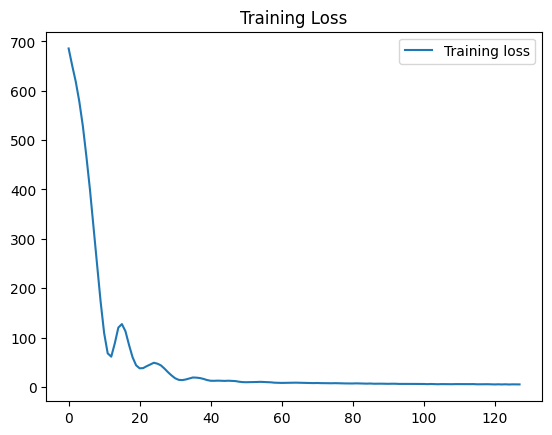

In [ ]:
plt.title('Training Loss')
plt.plot(losses,label = 'Training loss')
plt.legend()
plt.show()

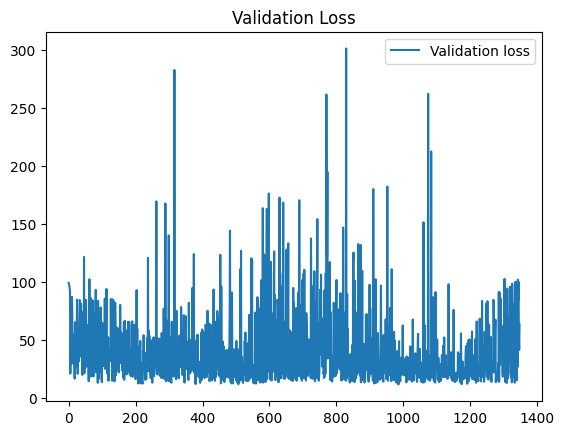

In [ ]:
plt.title('Validation Loss')
plt.plot(val_losses,label = 'Validation loss')
plt.legend()
plt.show()

In [ ]:
y_pred = []
with torch.no_grad():
  for i,data in enumerate(X_test):
    y_val = model(data)
    y_pred.append(y_val)

In [ ]:
y_test.detach().numpy()

array([[ 1.3139442e+02,  5.5976669e+01,  2.8260985e-01, -1.6305658e+00,
        -8.1976992e-01,  7.0720000e+00],
       [ 1.3106512e+02,  5.5812714e+01,  4.3055326e-01, -1.5377924e+00,
        -9.1635495e-01,  7.2800002e+00],
       [ 1.3074574e+02,  5.5629444e+01, -1.2762916e+00, -1.1339805e+00,
        -1.0701044e+00,  7.3000002e+00],
       ...,
       [ 1.3871135e+02,  4.5959831e+01, -7.7572083e-03,  4.1343994e-02,
        -2.9265916e-03,  7.2839999e+00],
       [ 1.3871965e+02,  4.5959248e+01, -7.2409131e-02,  7.6702997e-02,
        -5.1937113e-03,  7.2800002e+00],
       [ 1.3873900e+02,  4.5958206e+01,  4.8106037e-02, -3.0349165e-02,
        -7.8795367e-04,  7.2800002e+00]], dtype=float32)

###Pytorch - Tensor -RT Implementation

---



In [ ]:
torch.save(model.state_dict(), 'model.pth')

In [ ]:
model.load_state_dict(torch.load('pm1.pth'))

<All keys matched successfully>

In [ ]:
from torch2trt import torch2trt
data = torch.zeros((1, 3, 224, 224)).cuda().half()
model_trt = torch2trt(model, [data], fp16_mode=True)

In [ ]:
torch.save(model_trt.state_dict(), 'test_road_following_trt.pth')

In [ ]:
import torch
from torch2trt import TRTModule

model_trt = TRTModule()
model_trt.load_state_dict(torch.load('test_road_following_trt.pth'))

##Model Predictive Controller Implementation

---



In [ ]:
import time
from scipy.integrate import odeint
# import rospy

In [ ]:
!pip install control

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 513.9/513.9 kB 6.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import control as ct
import control.optimal as opt
import matplotlib.pyplot as plt
import math

def vehicle_update(t, x, u, params={}):
    # v_x = x[0]*np.cos(x[1]) + u[0]*np.cos(x[1])*t
    # v_y = x[0]*np.sin(x[1]) + u[0]*np.sin(x[1])*t
    # v = math.sqrt(v_x**2 + v_y**2)
    # psi = x[1] + u[1]*t

    return np.array([u[0], u[1]])

def vehicle_output(t, x, u, params):
    return x                            # return full state

# Define the vehicle steering dynamics as an input/output system
vehicle = ct.NonlinearIOSystem(
    vehicle_update, vehicle_output, states=2, name='vehicle',
    inputs=('acceleration', 'yaw_rate'), outputs=('velocity', 'yaw'))

<ipython-input-4-58af014a1950>:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(211)


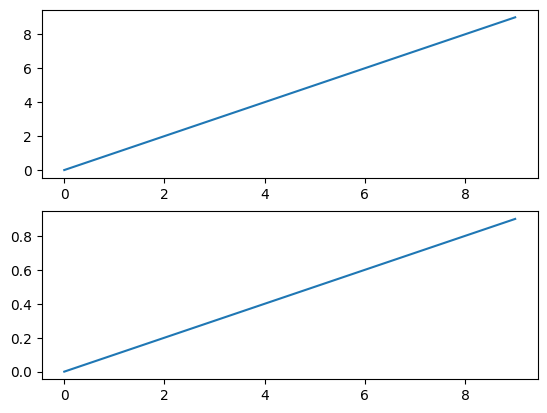

In [ ]:
x0 = np.array([0.,0.])
plt.plot(x0[0], x0[1], 'ro')
xs = x0.copy().reshape(1, -1)
u0 = np.array([1, 0.1])
t =  np.arange(10)
for i in range(1, len(t)):
    x0 = odeint(vehicle_update, x0, [t[i-1], t[i]], args=(u0,), tfirst=True)[-1]
    xs = np.vstack([xs, x0])
plt.subplot(211)
plt.plot(t,xs.T[0],label = 'Velocity')
plt.subplot(212)
plt.plot(t,xs.T[1],label = 'Yaw')

In [ ]:
x0 = np.array([0.,0.]); u0 = np.array([0, 0])
xf = np.array([5, 0]); uf = np.array([0, 0])

In [ ]:
Q = np.diag([0.1, 0.01])          # don't turn too sharply
R = np.diag([10, 100])               # keep inputs small
P = np.diag([100, 100])   # get close to final point
traj_cost = opt.quadratic_cost(vehicle, Q, R, x0=xf, u0=uf)
term_cost = opt.quadratic_cost(vehicle, P, 0, x0=xf)

In [ ]:
a_max, w_max = 5,1.9
constraints = [opt.input_range_constraint(vehicle, [-a_max, -w_max], [a_max, w_max])]

Summary statistics:
* Cost function calls: 82
* Constraint calls: 126
* System simulations: 1
* Final cost: 250.8362499999946
	timestep - 1	|	execution time = 0.280
Summary statistics:
* Cost function calls: 291
* Constraint calls: 340
* System simulations: 1
* Final cost: 203.1769362779577
	timestep - 2	|	execution time = 0.571
Summary statistics:
* Cost function calls: 460
* Constraint calls: 513
* System simulations: 1
* Final cost: 164.46749377261887
	timestep - 3	|	execution time = 0.770
Summary statistics:
* Cost function calls: 544
* Constraint calls: 599
* System simulations: 1
* Final cost: 133.1370470373675
	timestep - 4	|	execution time = 0.919
Summary statistics:
* Cost function calls: 501
* Constraint calls: 555
* System simulations: 1
* Final cost: 107.77277258724187
	timestep - 5	|	execution time = 0.762
Summary statistics:
* Cost function calls: 544
* Constraint calls: 599
* System simulations: 1
* Final cost: 87.24104509953875
	timestep - 6	|	execution time = 0.486
Sum

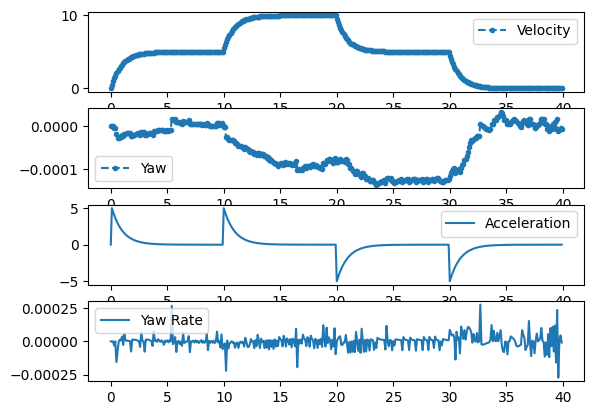

In [ ]:
horizon = 10
Tf, dt = 40, 0.1 # sampling time
timepts = np.arange(0, Tf, dt)
xs, us = x0.copy().reshape(1, -1), [[0, 0]]
for i in range(1, len(timepts)):
    if timepts[i] == 10: #seconds
      xf = np.array([10, 0])
      traj_cost = opt.quadratic_cost(vehicle, Q, R, x0=xf, u0= us[-1])
      term_cost = opt.quadratic_cost(vehicle, P, 0, x0=xf)
    elif timepts[i] == 20:
      xf = np.array([5, 0])
      traj_cost = opt.quadratic_cost(vehicle, Q, R, x0=xf, u0= us[-1])
      term_cost = opt.quadratic_cost(vehicle, P, 0, x0=xf)
    elif timepts[i] == 30:
      xf = np.array([0, 0])
      traj_cost = opt.quadratic_cost(vehicle, Q, R, x0=xf, u0= us[-1])
      term_cost = opt.quadratic_cost(vehicle, P, 0, x0=xf)
    start = time.time()
    result = opt.solve_ocp(vehicle, np.arange(horizon) * dt, xs[-1], traj_cost, constraints,
                        terminal_cost=term_cost, initial_guess=us[-1], print_summary=True)
    end = time.time()
    print(f'\ttimestep - {i}\t|\texecution time = {end - start:.3f}')
    t = [timepts[i - 1], timepts[i]]
    us = np.vstack([us, result.inputs.T[0]])
    x_ = odeint(vehicle_update, xs[-1], t, args=(us[-1],), tfirst=True)[-1]
    xs = np.vstack([xs, x_])
plt.subplot(411)
plt.plot(timepts, xs.T[0], '--.',label = 'Velocity')
plt.legend()
plt.subplot(412)
plt.plot(timepts, xs.T[1], '--.',label = 'Yaw')
plt.legend()
plt.subplot(413)
plt.plot(timepts, us[:, 0],label = 'Acceleration')
plt.legend()
plt.subplot(414)
plt.plot(timepts, us[:, 1],label = 'Yaw Rate')
plt.legend()

In [ ]:
print(xs[99])
print(xs[199])
print(xs[299])
print(xs[-1])

[4.99979770e+00 1.69194658e-06]
[ 9.99972822e+00 -8.41189784e-05]
[ 5.00001811e+00 -1.23099885e-04]
[ 1.92830450e-04 -5.68089999e-06]


Summary statistics:
* Cost function calls: 82
* Constraint calls: 126
* System simulations: 1
* Final cost: 250.8362499999946
	timestep - 1	|	execution time = 0.064
Summary statistics:
* Cost function calls: 375
* Constraint calls: 426
* System simulations: 1
* Final cost: 203.17693653299403
	timestep - 2	|	execution time = 0.224
Summary statistics:
* Cost function calls: 543
* Constraint calls: 598
* System simulations: 1
* Final cost: 164.4686430358875
	timestep - 3	|	execution time = 0.345
Summary statistics:
* Cost function calls: 461
* Constraint calls: 514
* System simulations: 1
* Final cost: 133.1352082561108
	timestep - 4	|	execution time = 0.257
Summary statistics:
* Cost function calls: 584
* Constraint calls: 640
* System simulations: 1
* Final cost: 107.77063031008505
	timestep - 5	|	execution time = 0.332
Summary statistics:
* Cost function calls: 544
* Constraint calls: 599
* System simulations: 1
* Final cost: 87.2391146291512
	timestep - 6	|	execution time = 0.340
Summ

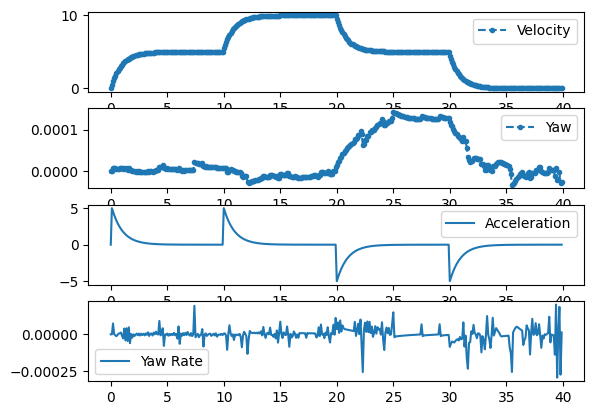

In [ ]:
horizon = 10
Tf, dt = 40, 0.1
timepts = np.arange(0, Tf, dt)
xs, us = x0.copy().reshape(1, -1), [[0, 0]]
for i in range(1, len(timepts)):
    if timepts[i] == 10: #seconds
      xf = np.array([10, 0])
      traj_cost = opt.quadratic_cost(vehicle, Q, R, x0=xf, u0= us[-1])
      term_cost = opt.quadratic_cost(vehicle, P, 0, x0=xf)
    elif timepts[i] == 20:
      xf = np.array([5, 0])
      traj_cost = opt.quadratic_cost(vehicle, Q, R, x0=xf, u0= us[-1])
      term_cost = opt.quadratic_cost(vehicle, P, 0, x0=xf)
    elif timepts[i] == 30:
      xf = np.array([0, 0])
      traj_cost = opt.quadratic_cost(vehicle, Q, R, x0=xf, u0= us[-1])
      term_cost = opt.quadratic_cost(vehicle, P, 0, x0=xf)
    start = time.time()
    lin_vehicle = ct.linearize(vehicle, xs[-1], us[-1])
    # traj_cost = opt.quadratic_cost(lin_vehicle, Q, R, x0=xf, u0=uf)
    # term_cost = opt.quadratic_cost(lin_vehicle, P, 0, x0=xf)
    result = opt.solve_ocp(lin_vehicle, np.arange(horizon) * dt, xs[-1], traj_cost, constraints,
                        terminal_cost=term_cost, initial_guess=us[-1], print_summary=True)
    end = time.time()
    print(f'\ttimestep - {i}\t|\texecution time = {end - start:.3f}')
    t = [timepts[i - 1], timepts[i]]
    us = np.vstack([us, result.inputs.T[0]])
    x_ = odeint(vehicle_update, xs[-1], t, args=(us[-1],), tfirst=True)[-1]
    xs = np.vstack([xs, x_])

plt.subplot(411)
plt.plot(timepts, xs.T[0], '--.',label = 'Velocity')
plt.legend()
plt.subplot(412)
plt.plot(timepts, xs.T[1], '--.',label = 'Yaw')
plt.legend()
plt.subplot(413)
plt.plot(timepts, us[:, 0],label = 'Acceleration')
plt.legend()
plt.subplot(414)
plt.plot(timepts, us[:, 1],label = 'Yaw Rate')
plt.legend()

In [ ]:
print(xs[99])
print(xs[199])
print(xs[299])
print(xs[-1])

[4.99990043e+00 6.84624679e-06]
[9.99987280e+00 1.05390658e-05]
[5.00001907e+00 1.27253594e-04]
[ 1.78847422e-04 -2.81724081e-05]


In [ ]:
import rospy
from time import time
from sensor_msgs.msg import Imu, Float64
from tf.transformations import euler_from_quaternion
from simulate_kinematic_car_ros import get_pressed_key

# Initialize global variables
v = yaw = ax = ay = gz = voltage = 0

dt = 0.1

def update_from_imu(msg):
    global ax, ay, gz
    ax = msg.linear_acceleration.x
    ay = msg.linear_acceleration.y
    gz = msg.angular_velocity.z
    o = msg.pose.orientation
    q = [o.x, o.y, o.z, o.w]
    yaw = euler_from_quaternion(q)[-1]
    v = np.sqrt(ax ** 2 + ay ** 2) * dt
    rospy.sleep(dt)

def update_voltage(msg):
    global voltage
    voltage = msg.data
    # Here you can log the voltage or use it in some way, if needed
    print(f"Voltage: {voltage:.2f} V")

if __name__ == "__main__":
    rospy.init_node('car_driver_pid')
    rospy.Subscriber("imu/data", Imu, update_from_imu)
    rospy.Subscriber("voltage", Float64, update_voltage)
    rospy.spin()


In [ ]:
#Code 1 for mpc
import torch
from torch2trt import TRTModule
import rospy
from time import time
from sensor_msgs.msg import Imu, Float64
from tf.transformations import euler_from_quaternion
import numpy as np
import control as ct
import control.optimal as opt
import math
from scipy.integrate import odeint
from std_msgs.msg import Float64MultiArray

# Initialize global variables
v = yaw = ax = ay = gz = 0
voltage = 0

# Sampling time
dt = 0.1

# Define the vehicle dynamics update function
def vehicle_update(t, x, u, params={}):
    return np.array([u[0], u[1]])

# Define the vehicle output function
def vehicle_output(t, x, u, params):
    return x

# Callback to update IMU data
def update_from_imu(msg):
    global ax, ay, gz, yaw, v
    ax = msg.linear_acceleration.x
    ay = msg.linear_acceleration.y
    gz = msg.angular_velocity.z
    o = msg.orientation
    q = [o.w]
    yaw = euler_from_quaternion(q)[-1]
    v = np.sqrt(ax ** 2 + ay ** 2) * dt
    rospy.sleep(dt)

# Callback to update voltage data
def update_voltage(msg):
    global voltage
    voltage = msg.data
    rospy.sleep(dt)
if __name__ == "__main__":
    # Initialize the ROS node
    rospy.init_node('car_driver_pid')

    # Subscribe to the IMU and voltage topics
    rospy.Subscriber("imu/data", Imu, update_from_imu)
    rospy.Subscriber("voltage", Float64, update_voltage)

    # Publisher for the neural network input data
    nn_input_publisher = rospy.Publisher("nn_input_data", Float64MultiArray, queue_size=10)

    # Load the TensorRT model
    model_trt = TRTModule()
    model_trt.load_state_dict(torch.load('pm7_trt.pth'))

    # Define the vehicle system
    vehicle = ct.NonlinearIOSystem(
        vehicle_update, vehicle_output, states=2, name='vehicle',
        inputs=('acceleration', 'yaw_rate'), outputs=('velocity', 'yaw')
    )

    # Initial and final states and inputs
    x0 = np.array([0., 0.])
    u0 = np.array([0, 0])
    xf = np.array([5, 0])
    uf = np.array([0, 0])

    # Define cost matrices
    Q = np.diag([0.1, 0.01])  # State cost
    R = np.diag([10, 100])    # Input cost
    P = np.diag([100, 100])   # Final state cost

    # Define trajectory and terminal cost
    traj_cost = opt.quadratic_cost(vehicle, Q, R, x0=xf, u0=uf)
    term_cost = opt.quadratic_cost(vehicle, P, 0, x0=xf)

    # Simulation parameters
    horizon = 10
    Tf, dt = 40, 0.1
    timepts = np.arange(0, Tf, dt)
    xs, us = x0.copy().reshape(1, -1), [[0, 0]]

    # Main control loop
    for i in range(1, len(timepts)):
        if timepts[i] == 10:
            xf = np.array([10, 0])
        elif timepts[i] == 20:
            xf = np.array([5, 0])
        elif timepts[i] == 30:
            xf = np.array([0, 0])
        traj_cost = opt.quadratic_cost(vehicle, Q, R, x0=xf, u0=us[-1])
        term_cost = opt.quadratic_cost(vehicle, P, 0, x0=xf)
        start = time()
        result = opt.solve_ocp(vehicle, np.arange(horizon) * dt, xs[-1], traj_cost, terminal_cost=term_cost, initial_guess=us[-1], print_summary=True)
        end = time()
        print(f'\ttimestep - {i}\t|\texecution time = {end - start:.3f}')
        t = [timepts[i - 1], timepts[i]]
        us = np.vstack([us, result.inputs.T[0]])
        x_ = odeint(vehicle_update, xs[-1], t, args=(us[-1],), tfirst=True)[-1]
        xs = np.vstack([xs, x_])

        # Use the neural network model for predictions
        prev_acc = math.sqrt(ax ** 2 + ay ** 2)
        y_pred = model_trt(torch.Tensor([prev_acc, us[-1][0],us[-1][1],gz,voltage]))
        model_output = y_pred.detach().numpy()
        # Prepare the data for publishing
        nn_input_data = Float64MultiArray()
        nn_input_data.data = [v, yaw, ax, ay, gz, model_output[0], model_output[1], voltage]
        nn_input_publisher.publish(nn_input_data)
    rospy.spin()

In [ ]:
#Code 2 for mpc
import sys
import math
import time
import rospy
import numpy as np
from numpy.linalg import norm
from geometry_msgs.msg import Vector3, Quaternion
from tf.transformations import euler_from_quaternion, quaternion_from_euler
from sensor_msgs.msg import Imu
from std_msgs.msg import Float64MultiArray

# Initialize global variables
v = yaw = ax = ay = gz = 0
voltage = 8.4

# Sampling time
dt = 0.1

#Input and Output Dimensions
input_dim = 8
output_dim = 6

class NeuralNetwork(nn.Module):
  def __init__(self,layer_1,layer_2,layer_3,dropout_rate,activation):
    super(NeuralNetwork,self).__init__()
    self.activation = activation
    self.relu_nn_model = nn.Sequential(
        nn.Linear(input_dim,layer_1),
        nn.ReLU(),
        nn.Linear(layer_1,layer_2),
        nn.ReLU(),
        nn.Dropout(p = dropout_rate),
        nn.Linear(layer_2,layer_3),
        nn.ReLU(),
        nn.Linear(layer_3,output_dim)
    )
    self.leaky_relu_nn_model = nn.Sequential(
        nn.Linear(input_dim,layer_1),
        nn.LeakyReLU(),
        nn.Linear(layer_1,layer_2),
        nn.LeakyReLU(),
        nn.Dropout(p = dropout_rate),
        nn.Linear(layer_2,layer_3),
        nn.LeakyReLU(),
        nn.Linear(layer_3,output_dim)
    )
    self.tanh_nn_model = nn.Sequential(
        nn.Linear(input_dim,layer_1),
        nn.Tanh(),
        nn.Linear(layer_1,layer_2),
        nn.Tanh(),
        nn.Dropout(p = dropout_rate),
        nn.Linear(layer_2,layer_3),
        nn.Tanh(),
        nn.Linear(layer_3,output_dim)
    )
  def forward(self,x):
    if self.activation == 'relu':
      y = self.relu_nn_model(x)
      return y
    if self.activation == 'leaky_relu':
      y = self.leaky_relu_nn_model(x)
      return y
    if self.activation == 'tanh':
      y = self.tanh_nn_model(x)
      return y


model = NeuralNetwork(120,40,80,0.1,'leaky_relu')

def deadReckoning(self):
    global vx,vy,ax,ay,dt
    vx += ax * dt
    vy += ay * dt
    v = math.sqrt(vx**2 + vy**2)


def nn_input_callback(msg):
    input_data = torch.Tensor(msg.data)
    output_data = model(input_data)
    result = output_data.detach().numpy()
    v = result[0]
    yaw =result[1]
    ax = result[2]
    ay = result[3]
    gz = result[4]


if __name__ == '__main__':
    rospy.init_node('filtered_imu_data_publisher')
    rospy.Subscriber("nn_input_data", Float64MultiArray, nn_input_callback)
    imu_pub = rospy.Publisher('imu/data', Imu, queue_size=10)

    try:
        print('started publishing imu data ...')
        msg = Imu()
        msg.header.seq = 0
        msg.header.frame_id = 'imu_link'

        while not rospy.is_shutdown():
            accl = np.array([ax, ay,0])
            gyro = np.array([0,0,gz])

            msg.header.seq += 1
            msg.header.stamp = rospy.Time.now()
            quat = quaternion_from_euler(yaw)
            msg.orientation = Quaternion(*quat)
            msg.linear_acceleration = Vector3(*accl)
            msg.angular_velocity = Vector3(*gyro)
            imu_pub.publish(msg)
            deadReckoning()
            rospy.sleep(0.001)

    except (KeyboardInterrupt, Exception, rospy.ROSException) as e:
        print(e, '\nexecution stopped ...')
